In [1]:
SEED = 1221

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
train_url = "https://raw.githubusercontent.com/aliduabubakari/Diversiboard-Topcrowd-data-science-challenge/main/Data/Train%20data.csv"
test_url = "https://raw.githubusercontent.com/aliduabubakari/Diversiboard-Topcrowd-data-science-challenge/main/Data/Test%20data.csv"

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)


In [3]:
# Preview train dataset
train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [4]:
# Check size and shape of datasets
train.shape, test.shape

((20191, 10), (9999, 9))

In [5]:
train.dtypes

id                  int64
Sex                object
Length            float64
Diameter          float64
Height            float64
Weight            float64
Shucked Weight    float64
Viscera Weight    float64
Shell Weight      float64
Age                 int64
dtype: object

<a name="Statistics"></a>
## 3. Statistical Summaries

In [6]:
# Train statistical summary
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,20191.0,10095.000000,5828.783978,0.000000,5047.500000,10095.000000,15142.500000,20190.000000
Length,20191.0,1.317672,0.288066,0.187500,1.150000,1.375000,1.537500,1.950000
Diameter,20191.0,1.024637,0.237790,0.137500,0.887500,1.075000,1.200000,1.612500
Height,20191.0,0.348064,0.093185,0.000000,0.287500,0.362500,0.412500,2.825000
Weight,20191.0,23.400403,12.717732,0.056699,13.437663,23.785231,32.318430,78.797435
Shucked Weight,20191.0,10.121481,5.644895,0.028349,5.712424,9.908150,14.068439,42.184056
Viscera Weight,20191.0,5.061241,2.801545,0.042524,2.849125,4.975337,7.002326,19.589505
Shell Weight,20191.0,6.724716,3.599905,0.042524,3.968930,6.803880,9.128539,28.491248
Age,20191.0,9.953246,3.170614,1.000000,8.000000,10.000000,11.000000,29.000000


### Univariate Analysis 

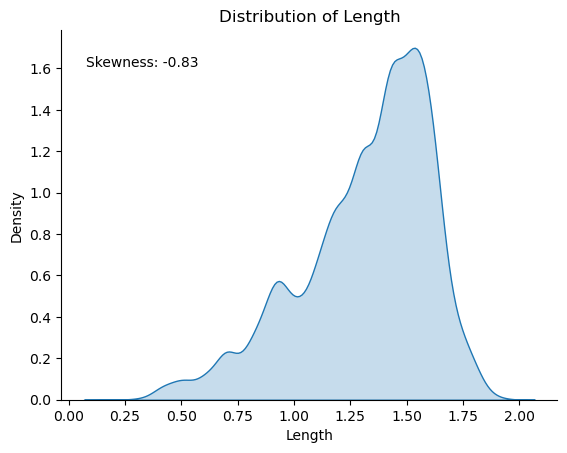

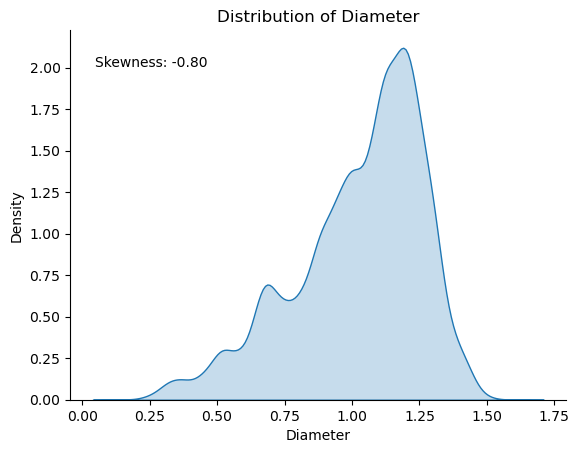

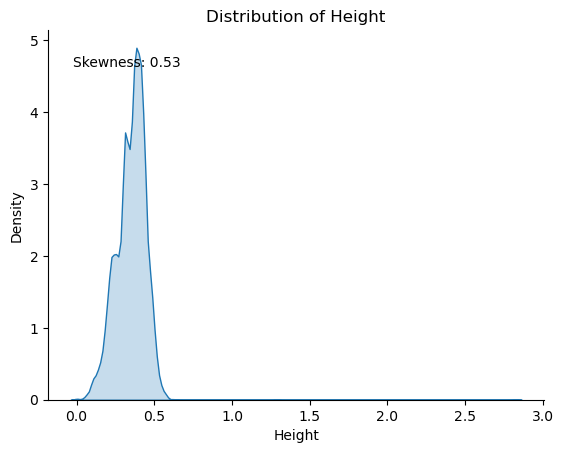

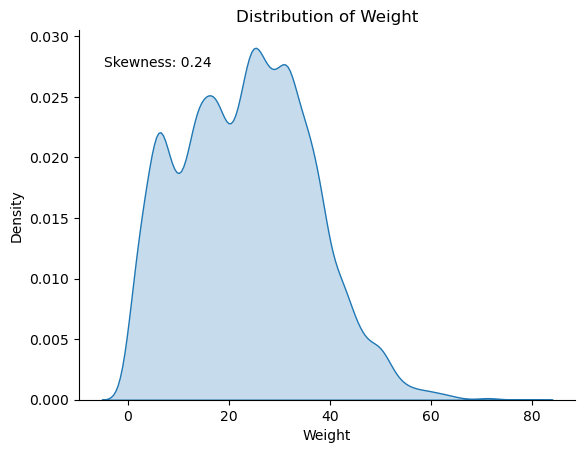

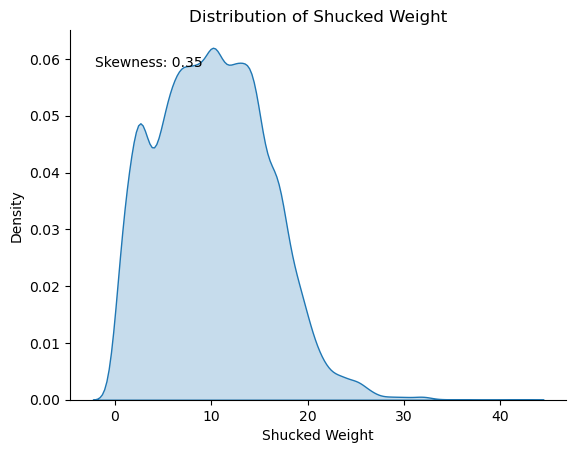

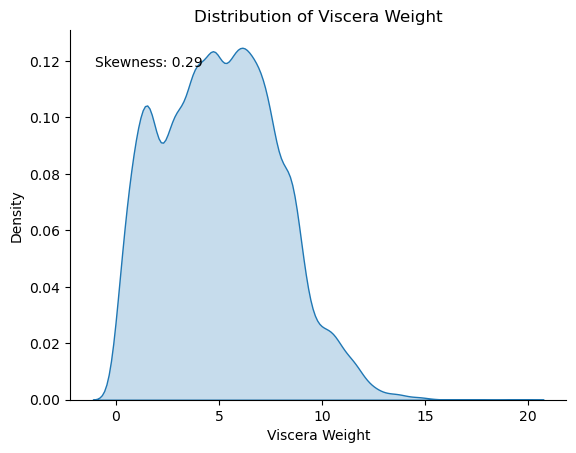

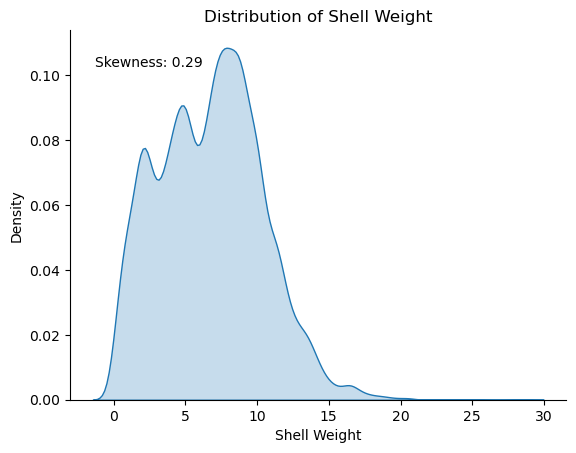

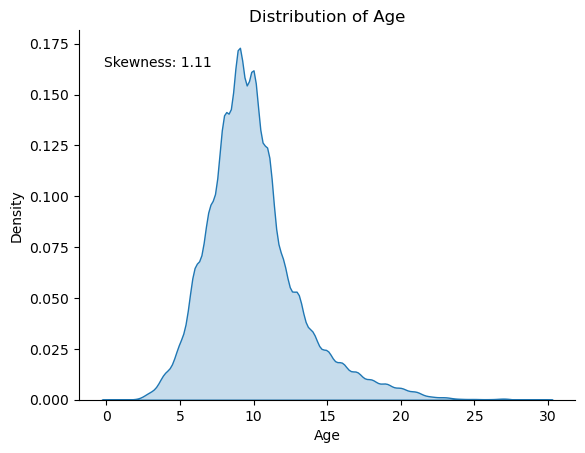

In [7]:
# Select only the numeric columns
numeric_columns = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight', 'Age']

# Plot KDE plots for each numeric column
for column in numeric_columns:
    fig, ax = plt.subplots()
    sns.kdeplot(data=train[column], fill=True, ax=ax)
    sns.despine()
    plt.title(f"Distribution of {column}")
    
    # Calculate skewness
    skewness = train[column].skew()
    plt.text(0.05, 0.9, f"Skewness: {skewness:.2f}", transform=ax.transAxes)
    
    # Identify potential outliers using Tukey's fences
    q1 = np.percentile(train[column], 25)
    q3 = np.percentile(train[column], 75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    plt.show()


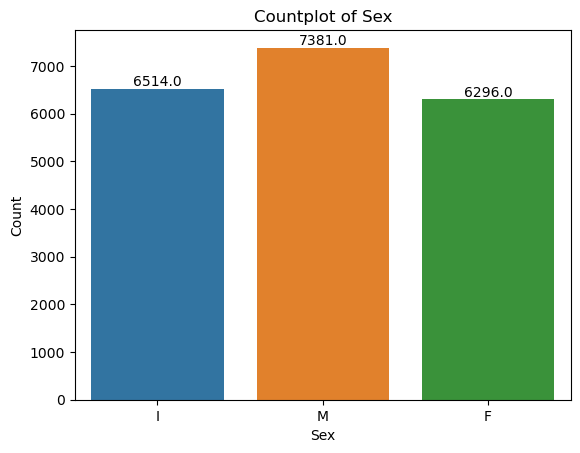

In [8]:
# Create the countplot
ax = sns.countplot(data=train, x='Sex')

# Set labels and title
ax.set_xlabel('Sex')
ax.set_ylabel('Count')
ax.set_title('Countplot of Sex')

# Add data points above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Show the plot
plt.show()


### Bivariate Analysis 

### Correlation Analysis 

In [9]:
correlation_matrix = train.corr()
print(correlation_matrix['Age'])

id               -0.003395
Length            0.618512
Diameter          0.627650
Height            0.633972
Weight            0.607950
Shucked Weight    0.511906
Viscera Weight    0.582643
Shell Weight      0.670578
Age               1.000000
Name: Age, dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_32888\2322940245.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train.corr()


- The correlation matrix shows the correlation coefficients between the numeric features and the target variable 'Age'. Here are some observations based on the correlation coefficients:

- Length, Diameter, Height, Weight, Shucked Weight, Viscera Weight, and Shell Weight all have positive correlations with Age. This suggests that as these features increase, the Age tends to increase as well. The highest correlation coefficient is observed for Shell Weight, indicating a relatively stronger correlation with Age.

- The highest correlation coefficient is observed for Shell Weight (0.670578), followed by Height (0.633972), Diameter (0.627650), Length (0.618512), and Weight (0.607950).

- Shucked Weight and Viscera Weight also show positive correlations with Age, but the coefficients are relatively lower compared to other features.

- Overall, the correlation coefficients indicate that the numeric features have a moderate to strong positive correlation with the target variable 'Age'. This suggests that these features may be useful in predicting the age of the abalone.

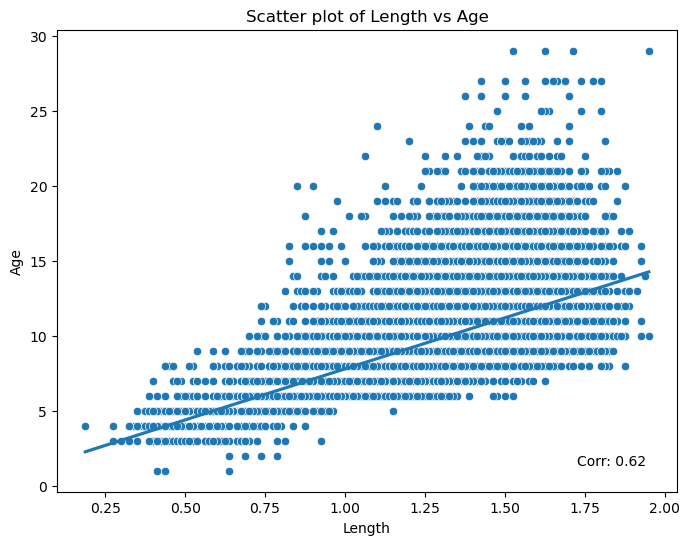

In [10]:
import numpy as np

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Length', y='Age', data=train)

# Add the line of best fit
sns.regplot(x='Length', y='Age', data=train, scatter=False)

# Calculate the correlation coefficient
length = train['Length']
age = train['Age']
corr_coef = np.corrcoef(length, age)[0, 1]

# Add the correlation coefficient as a text annotation
plt.text(0.95, 0.05, f'Corr: {corr_coef:.2f}', ha='right', va='bottom', transform=plt.gca().transAxes)

plt.xlabel('Length')
plt.ylabel('Age')
plt.title('Scatter plot of Length vs Age')

plt.show()


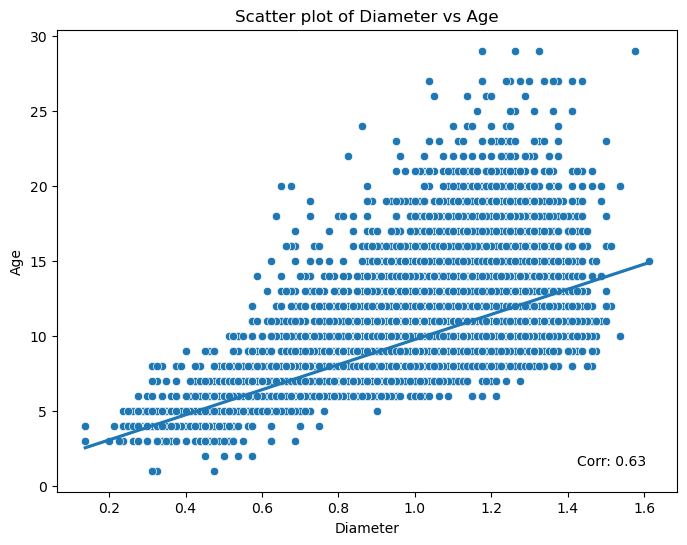

In [11]:
import numpy as np

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Diameter', y='Age', data=train)

# Add the line of best fit
sns.regplot(x='Diameter', y='Age', data=train, scatter=False)

# Calculate the correlation coefficient
length = train['Diameter']
age = train['Age']
corr_coef = np.corrcoef(length, age)[0, 1]

# Add the correlation coefficient as a text annotation
plt.text(0.95, 0.05, f'Corr: {corr_coef:.2f}', ha='right', va='bottom', transform=plt.gca().transAxes)

plt.xlabel('Diameter')
plt.ylabel('Age')
plt.title('Scatter plot of Diameter vs Age')

plt.show()


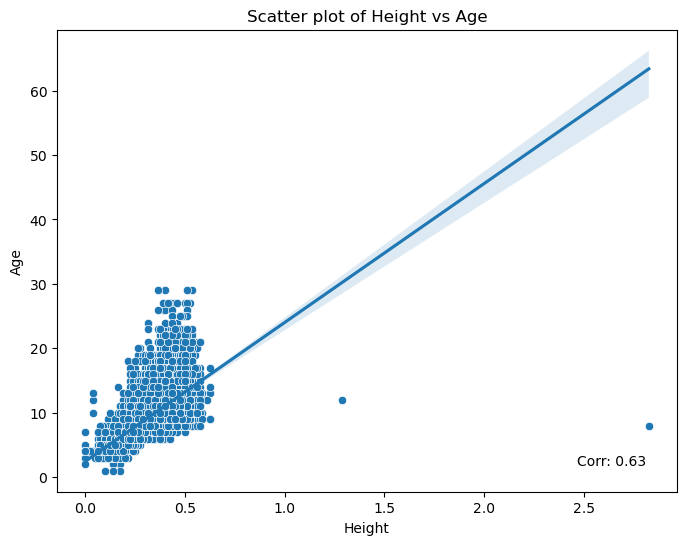

In [12]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Height', y='Age', data=train)

# Add the line of best fit
sns.regplot(x='Height', y='Age', data=train, scatter=False)

# Calculate the correlation coefficient
length = train['Height']
age = train['Age']
corr_coef = np.corrcoef(length, age)[0, 1]

# Add the correlation coefficient as a text annotation
plt.text(0.95, 0.05, f'Corr: {corr_coef:.2f}', ha='right', va='bottom', transform=plt.gca().transAxes)

plt.xlabel('Height')
plt.ylabel('Age')
plt.title('Scatter plot of Height vs Age')

plt.show()


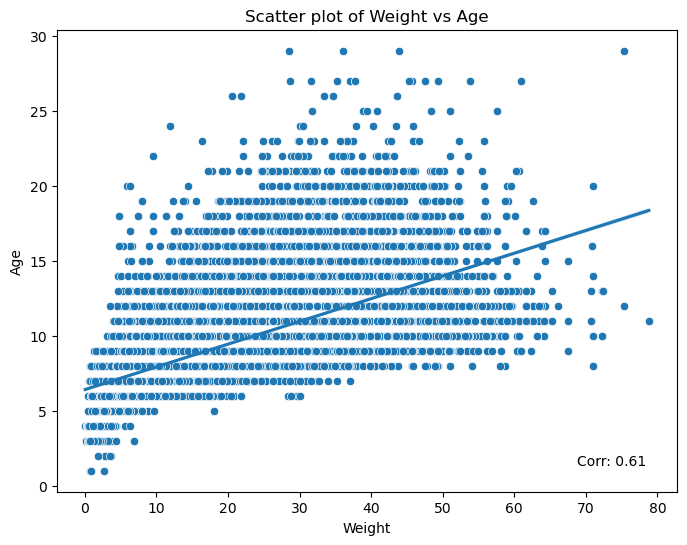

In [13]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Weight', y='Age', data=train)

# Add the line of best fit
sns.regplot(x='Weight', y='Age', data=train, scatter=False)

# Calculate the correlation coefficient
length = train['Weight']
age = train['Age']
corr_coef = np.corrcoef(length, age)[0, 1]

# Add the correlation coefficient as a text annotation
plt.text(0.95, 0.05, f'Corr: {corr_coef:.2f}', ha='right', va='bottom', transform=plt.gca().transAxes)

plt.xlabel('Weight')
plt.ylabel('Age')
plt.title('Scatter plot of Weight vs Age')

plt.show()


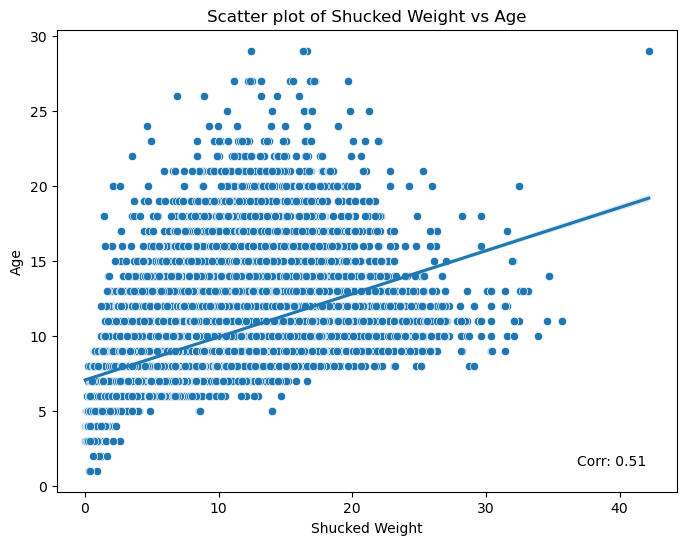

In [14]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Shucked Weight', y='Age', data=train)

# Add the line of best fit
sns.regplot(x='Shucked Weight', y='Age', data=train, scatter=False)

# Calculate the correlation coefficient
length = train['Shucked Weight']
age = train['Age']
corr_coef = np.corrcoef(length, age)[0, 1]

# Add the correlation coefficient as a text annotation
plt.text(0.95, 0.05, f'Corr: {corr_coef:.2f}', ha='right', va='bottom', transform=plt.gca().transAxes)

plt.xlabel('Shucked Weight')
plt.ylabel('Age')
plt.title('Scatter plot of Shucked Weight vs Age')

plt.show()



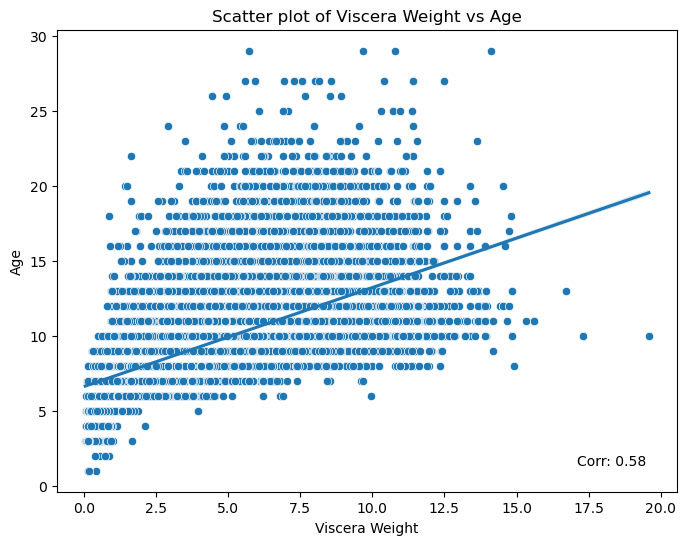

In [15]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Viscera Weight', y='Age', data=train)

# Add the line of best fit
sns.regplot(x='Viscera Weight', y='Age', data=train, scatter=False)

# Calculate the correlation coefficient
length = train['Viscera Weight']
age = train['Age']
corr_coef = np.corrcoef(length, age)[0, 1]

# Add the correlation coefficient as a text annotation
plt.text(0.95, 0.05, f'Corr: {corr_coef:.2f}', ha='right', va='bottom', transform=plt.gca().transAxes)

plt.xlabel('Viscera Weight')
plt.ylabel('Age')
plt.title('Scatter plot of Viscera Weight vs Age')

plt.show()



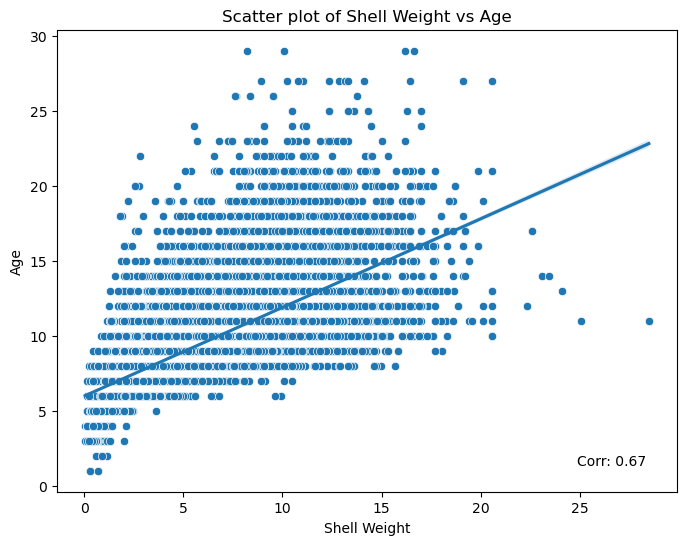

In [16]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Shell Weight', y='Age', data=train)

# Add the line of best fit
sns.regplot(x='Shell Weight', y='Age', data=train, scatter=False)

# Calculate the correlation coefficient
length = train['Shell Weight']
age = train['Age']
corr_coef = np.corrcoef(length, age)[0, 1]

# Add the correlation coefficient as a text annotation
plt.text(0.95, 0.05, f'Corr: {corr_coef:.2f}', ha='right', va='bottom', transform=plt.gca().transAxes)

plt.xlabel('Shell Weight')
plt.ylabel('Age')
plt.title('Scatter plot of Shell Weight vs Age')

plt.show()



The correlation matrix shows the correlation coefficients between the numeric features and the target variable 'Age'. Here are some observations based on the correlation coefficients:

- Length, Diameter, Height, Weight, Shucked Weight, Viscera Weight, and Shell Weight all have positive correlations with Age. This suggests that as these features increase, the Age tends to increase as well. The highest correlation coefficient is observed for Shell Weight, indicating a relatively stronger correlation with Age.

- The highest correlation coefficient is observed for Shell Weight (0.670578), followed by Height (0.633972), Diameter (0.627650), Length (0.618512), and Weight (0.607950).

- Shucked Weight and Viscera Weight also show positive correlations with Age, but the coefficients are relatively lower compared to other features.

- The correlation coefficients indicate that the numeric features have a moderate to strong positive correlation with the target variable 'Age'. This suggests that these features may be useful in predicting the age of the abalone.

#### Violinplot Analysis 

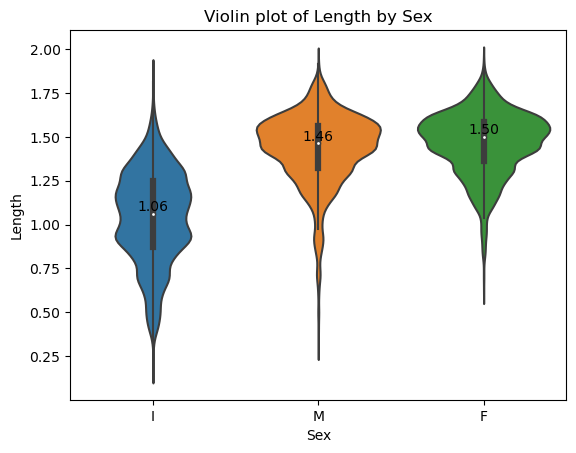

In [17]:
# Create the violin plot
ax = sns.violinplot(x='Sex', y='Length', data=train)

# Calculate the median values for each category
medians = train.groupby('Sex')['Length'].median()

# Add data labels to the plot
for tick, label in enumerate(ax.get_xticklabels()):
    category = label.get_text()
    median_value = medians[category]
    ax.text(tick, median_value, f'{median_value:.2f}', ha='center', va='bottom', color='black')

# Set the plot title and axis labels
ax.set_title('Violin plot of Length by Sex')
ax.set_xlabel('Sex')
ax.set_ylabel('Length')

# Show the plot
plt.show()


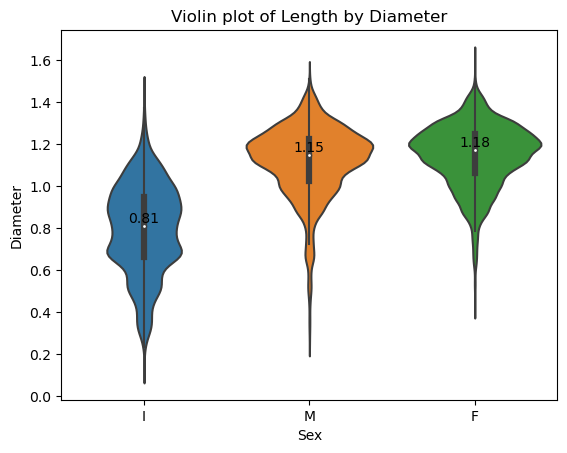

In [18]:
# Create the violin plot
ax = sns.violinplot(x='Sex', y='Diameter', data=train)

# Calculate the median values for each category
medians = train.groupby('Sex')['Diameter'].median()

# Add data labels to the plot
for tick, label in enumerate(ax.get_xticklabels()):
    category = label.get_text()
    median_value = medians[category]
    ax.text(tick, median_value, f'{median_value:.2f}', ha='center', va='bottom', color='black')

# Set the plot title and axis labels
ax.set_title('Violin plot of Length by Diameter')
ax.set_xlabel('Sex')
ax.set_ylabel('Diameter')

# Show the plot
plt.show()


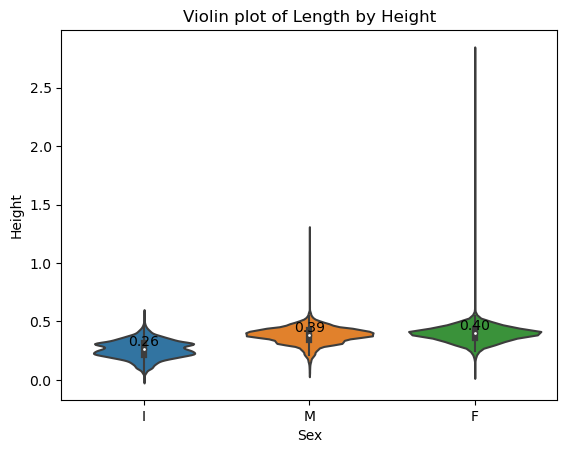

In [19]:
# Create the violin plot
ax = sns.violinplot(x='Sex', y='Height', data=train)

# Calculate the median values for each category
medians = train.groupby('Sex')['Height'].median()

# Add data labels to the plot
for tick, label in enumerate(ax.get_xticklabels()):
    category = label.get_text()
    median_value = medians[category]
    ax.text(tick, median_value, f'{median_value:.2f}', ha='center', va='bottom', color='black')

# Set the plot title and axis labels
ax.set_title('Violin plot of Length by Height')
ax.set_xlabel('Sex')
ax.set_ylabel('Height')

# Show the plot
plt.show()


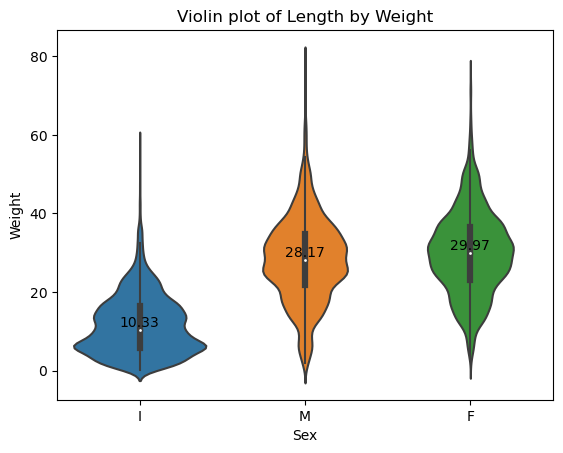

In [20]:
# Create the violin plot
ax = sns.violinplot(x='Sex', y='Weight', data=train)

# Calculate the median values for each category
medians = train.groupby('Sex')['Weight'].median()

# Add data labels to the plot
for tick, label in enumerate(ax.get_xticklabels()):
    category = label.get_text()
    median_value = medians[category]
    ax.text(tick, median_value, f'{median_value:.2f}', ha='center', va='bottom', color='black')

# Set the plot title and axis labels
ax.set_title('Violin plot of Length by Weight')
ax.set_xlabel('Sex')
ax.set_ylabel('Weight')

# Show the plot
plt.show()


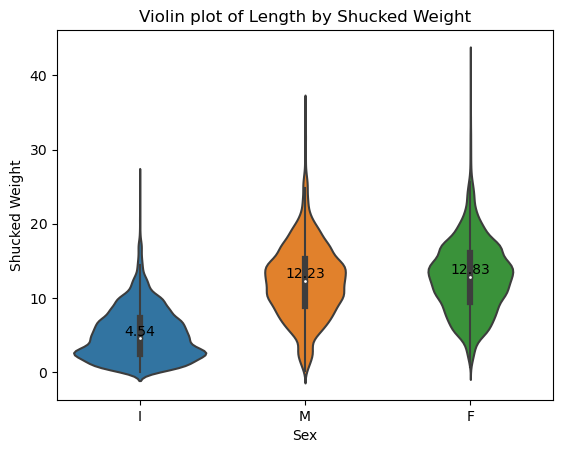

In [21]:
# Create the violin plot
ax = sns.violinplot(x='Sex', y='Shucked Weight', data=train)

# Calculate the median values for each category
medians = train.groupby('Sex')['Shucked Weight'].median()

# Add data labels to the plot
for tick, label in enumerate(ax.get_xticklabels()):
    category = label.get_text()
    median_value = medians[category]
    ax.text(tick, median_value, f'{median_value:.2f}', ha='center', va='bottom', color='black')

# Set the plot title and axis labels
ax.set_title('Violin plot of Length by Shucked Weight')
ax.set_xlabel('Sex')
ax.set_ylabel('Shucked Weight')

# Show the plot
plt.show()


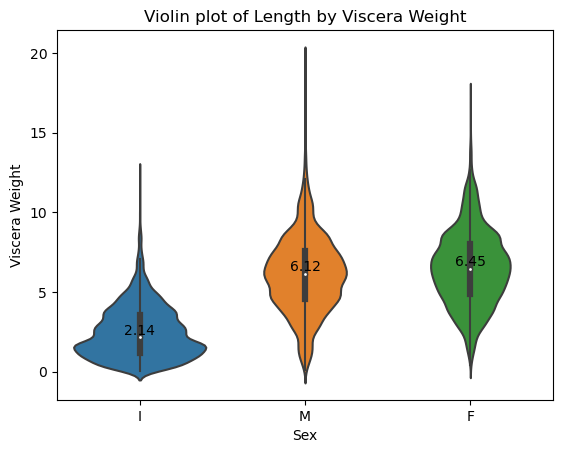

In [22]:
# Create the violin plot
ax = sns.violinplot(x='Sex', y='Viscera Weight', data=train)

# Calculate the median values for each category
medians = train.groupby('Sex')['Viscera Weight'].median()

# Add data labels to the plot
for tick, label in enumerate(ax.get_xticklabels()):
    category = label.get_text()
    median_value = medians[category]
    ax.text(tick, median_value, f'{median_value:.2f}', ha='center', va='bottom', color='black')

# Set the plot title and axis labels
ax.set_title('Violin plot of Length by Viscera Weight')
ax.set_xlabel('Sex')
ax.set_ylabel('Viscera Weight')

# Show the plot
plt.show()


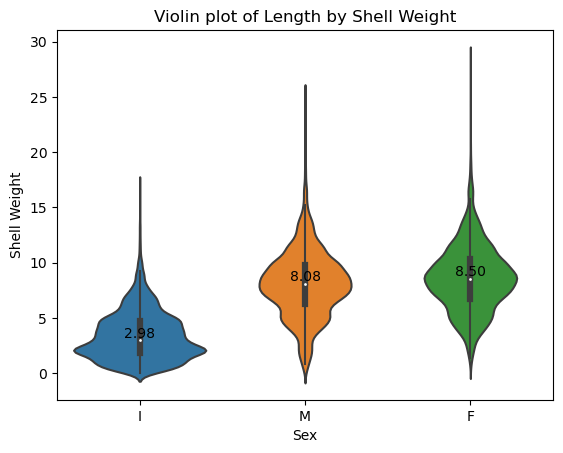

In [23]:
# Create the violin plot
ax = sns.violinplot(x='Sex', y='Shell Weight', data=train)

# Calculate the median values for each category
medians = train.groupby('Sex')['Shell Weight'].median()

# Add data labels to the plot
for tick, label in enumerate(ax.get_xticklabels()):
    category = label.get_text()
    median_value = medians[category]
    ax.text(tick, median_value, f'{median_value:.2f}', ha='center', va='bottom', color='black')

# Set the plot title and axis labels
ax.set_title('Violin plot of Length by Shell Weight')
ax.set_xlabel('Sex')
ax.set_ylabel('Shell Weight')

# Show the plot
plt.show()


#### Boxplot Analysis 

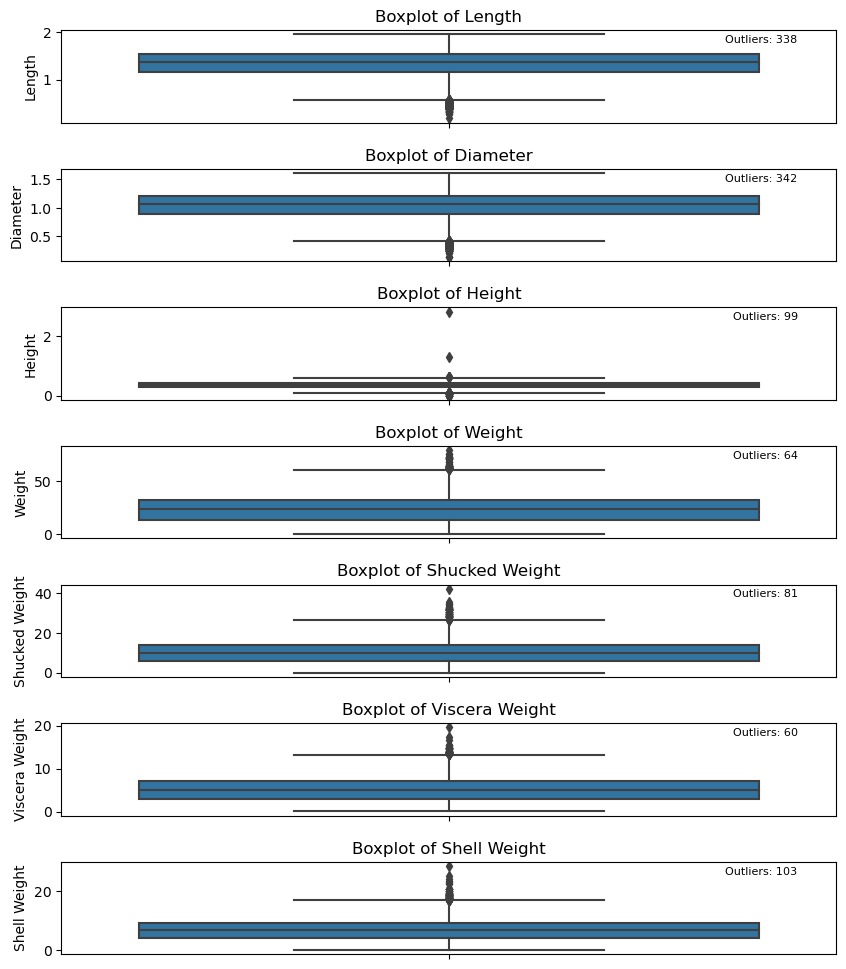

In [24]:
# Select the numeric columns
numeric_columns = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']

# Create subplots for each numeric column
fig, axes = plt.subplots(nrows=len(numeric_columns), figsize=(10, 12))

# Iterate over each numeric column and create a boxplot
for i, col in enumerate(numeric_columns):
    sns.boxplot(y=train[col], ax=axes[i])
    axes[i].set_ylabel(col)
    axes[i].set_title(f'Boxplot of {col}')

    # Calculate the number of outliers
    q1 = train[col].quantile(0.25)
    q3 = train[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    num_outliers = ((train[col] < lower_bound) | (train[col] > upper_bound)).sum()

    # Add the outlier count as a data label
    axes[i].text(0.95, 0.95, f'Outliers: {num_outliers}', ha='right', va='top', transform=axes[i].transAxes, fontsize=8)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

plt.show()


### Multivariate Analysis 

C:\Users\user\AppData\Local\Temp\ipykernel_32888\3209112519.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


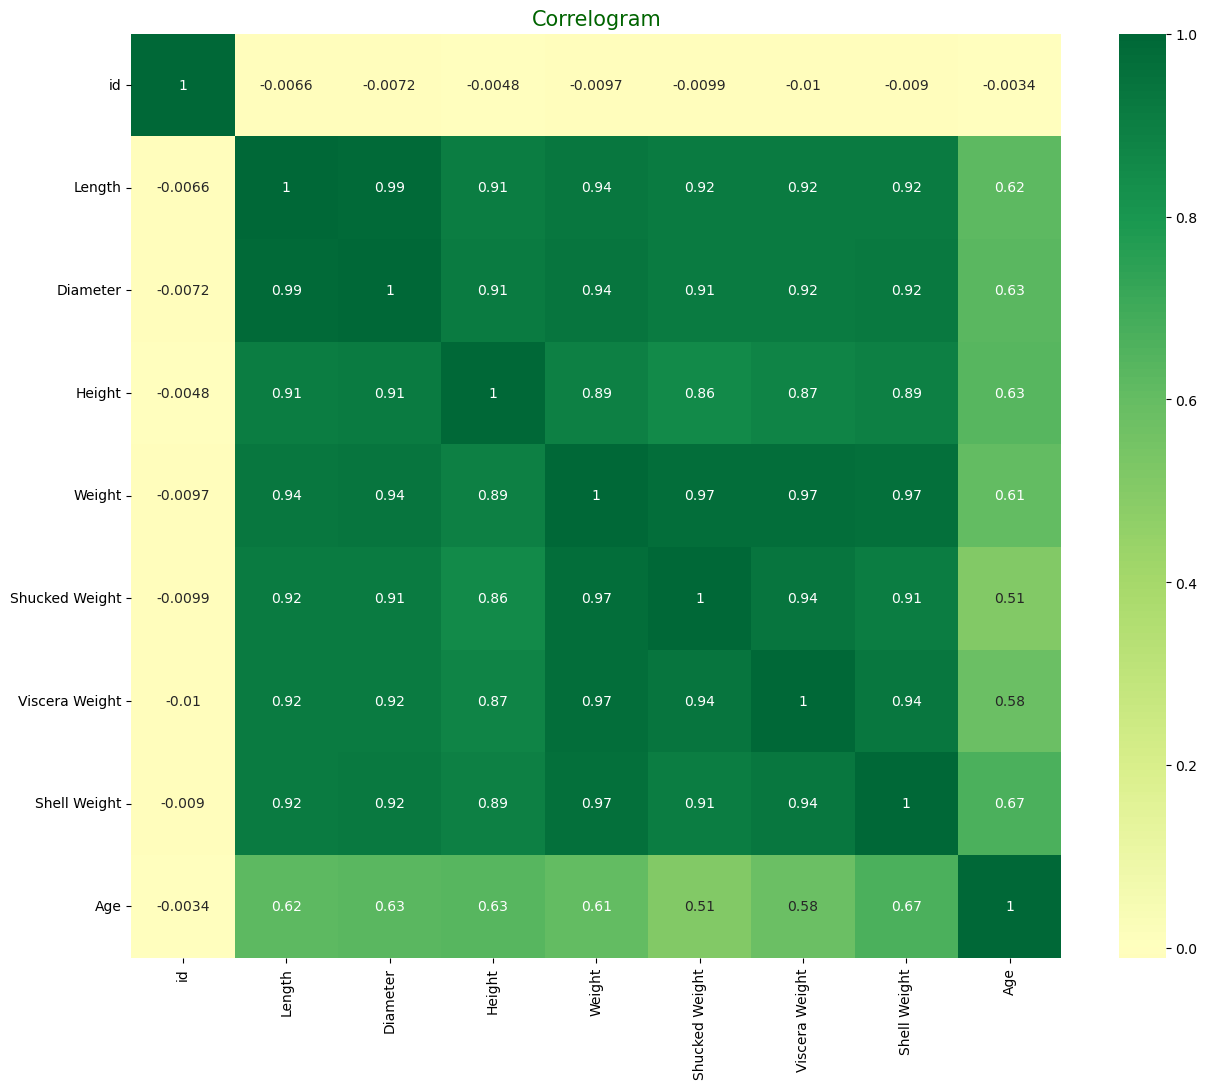

In [25]:
# Plotting a heatmap to show correlations between variables
corr = train.corr()
plt.figure(figsize = (15, 12))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

#### Groupby Analaysis 

In [26]:
df = train.copy()

In [27]:
# Group by 'Sex' and calculate the mean age
sex_group = df.groupby('Sex')['Age'].mean()
print(sex_group)


Sex
F    11.310991
I     7.588118
M    10.882401
Name: Age, dtype: float64


The output you provided shows the mean age for each sex category. Here are some insights based on the data:

- The dataset includes three sex categories: 'F', 'I', and 'M'.
- The mean age for the 'F' category is 11.310991.
- The mean age for the 'I' category is 7.588118.
- The mean age for the 'M' category is 10.882401.

These statistics indicate the average age for each sex category in your dataset. It seems that, on average, the 'F' category has a higher age compared to the 'M' category, while the 'I' category has the lowest mean age.

In [28]:
# Group by 'Sex' and calculate the minimum, maximum, and average height
sex_height_group = df.groupby('Sex')['Height'].agg(['min', 'max', 'mean'])
print(sex_height_group)


        min     max      mean
Sex                          
F    0.0375  2.8250  0.395364
I    0.0000  0.5750  0.262801
M    0.0500  1.2875  0.382964


The output you provided shows the minimum, maximum, and average height for each sex category. Here are some insights based on the data:

- The dataset includes three sex categories: 'F', 'I', and 'M'.

- For the 'F' category, the minimum height is 0.0375, the maximum height is 2.8250, and the average height is 0.395364.

- For the 'I' category, the minimum height is 0.0000, the maximum height is 0.5750, and the average height is 0.262801.

- For the 'M' category, the minimum height is 0.0500, the maximum height is 1.2875, and the average height is 0.382964.

- These statistics provide information about the range and central tendency of height for each sex category. It seems that the 'F' category has the highest maximum height and average height, followed by the 'M' category, while the 'I' category has the lowest values for these metrics.

In [29]:
total_weight_by_age = df.groupby('Age')['Weight'].sum()
print(total_weight_by_age)


Age
1         4.379998
2        11.864266
3        98.046746
4       353.815935
5      1523.346208
6      8166.029591
7     18159.059604
8     47423.258304
9     82647.889884
10    90756.125408
11    76416.747494
12    39741.894940
13    31272.794726
14    19117.473979
15    14313.796924
16    11321.205077
17     8923.606872
18     6648.651346
19     5212.921595
20     4285.083624
21     2785.698185
22     1011.084917
23      856.318590
24      269.986463
25      307.889745
26      154.037008
27      510.730417
29      183.789808
Name: Weight, dtype: float64


The output you provided shows the total weight for each age group. Here are some observations and insights based on the data:

- The age groups range from 1 to 29.

- As the age increases, the total weight generally increases, which indicates a positive correlation between age and weight.

- The total weight gradually increases from age 1 to age 10, with a significant jump between ages 5 and 6. This suggests that there is substantial weight gain during these early ages.

- The highest total weight is observed at age 10, with a value of 90,756.13.

- After age 10, the total weight starts to decline gradually, with some fluctuations. This could indicate a decrease in weight or a decrease in the number of observations for higher ages.

<a name="Missing"></a>
## 4. Missing Values and Duplicates

In [30]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any()

(False, False)

In [31]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

There are no missing values or duplicates

<a name="Class Distribution"></a>
## 5. Target Distribution

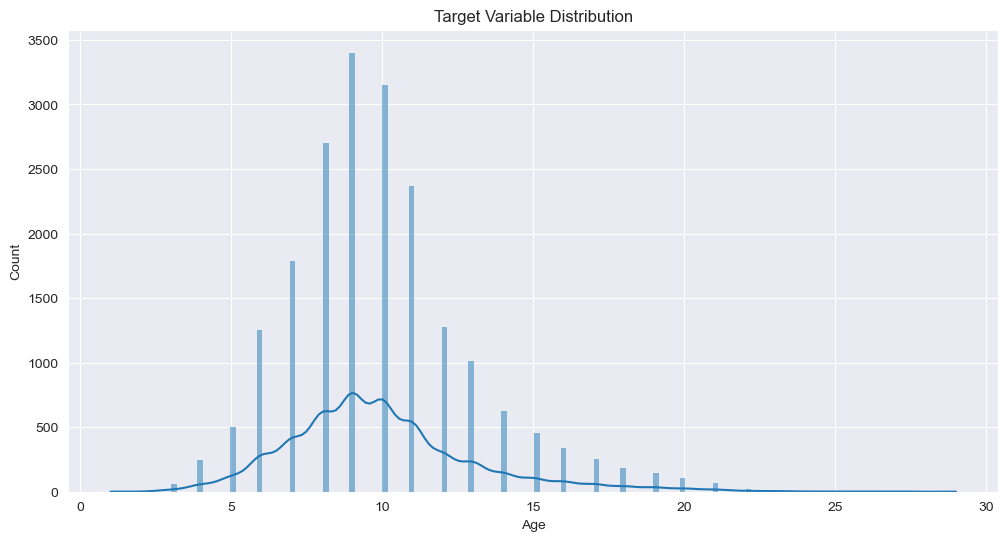

In [32]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
sns.histplot(x='Age', data=train, kde=True)
plt.title('Target Variable Distribution')
plt.show()

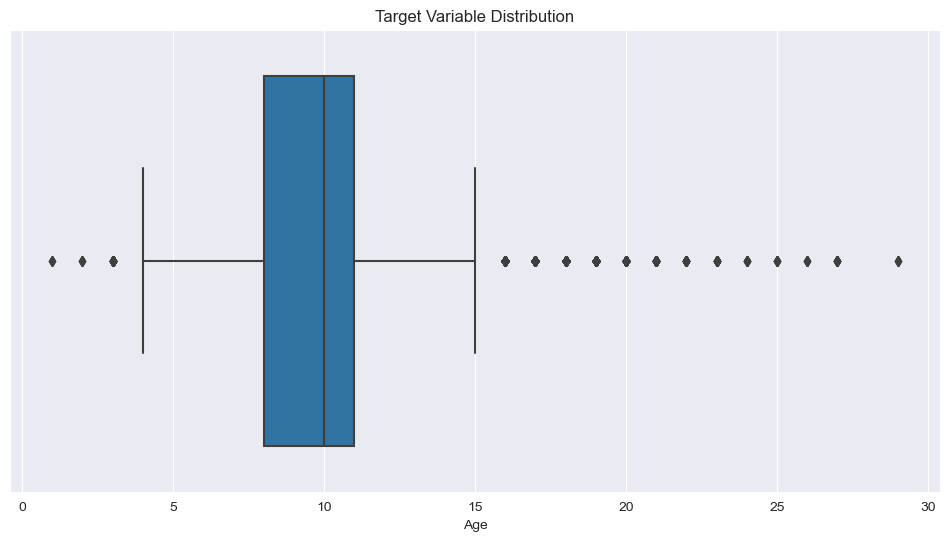

In [33]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
sns.boxplot(x='Age', data=train)
plt.title('Target Variable Distribution')
plt.show()


Since we have a lot of outliers, I deciced to cap them at the 90th percentile because outliers introduce noise but may also contain valuable information 

In [34]:
# Calculate the 90th percentile of the 'Age' column
age_90th_percentile = train['Age'].quantile(0.90)

# Cap the outliers at the 90th percentile
train['Age'] = train['Age'].clip(upper=age_90th_percentile)

# Verify the updated column
print(train['Age'])


0         9
1         8
2         9
3        11
4         8
         ..
20186     8
20187    11
20188     7
20189    10
20190    14
Name: Age, Length: 20191, dtype: int64


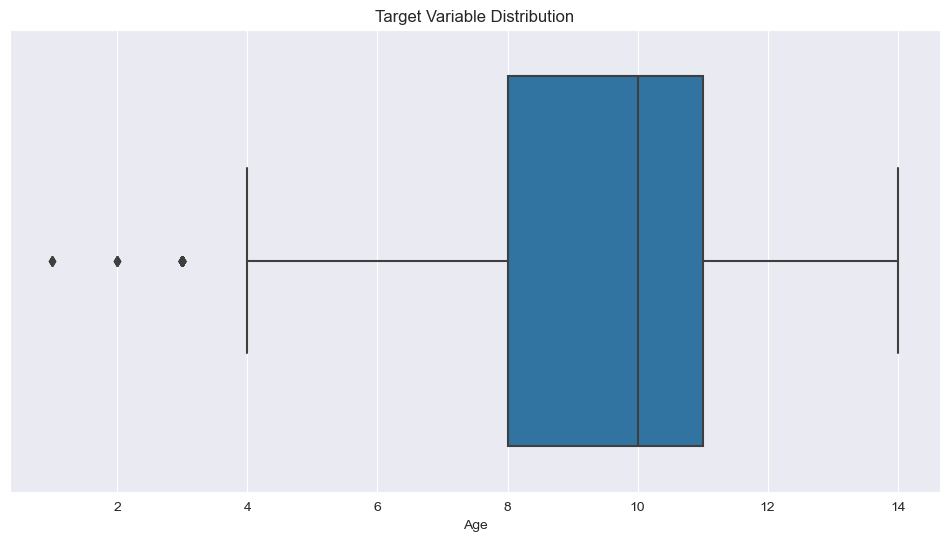

In [35]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
sns.boxplot(x='Age', data=train)
plt.title('Target Variable Distribution')
plt.show()


<a name="Preprocess"></a>
## 6. Modeling

In [36]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit the encoder on the 'Sex' column in the train data
encoder.fit(train[['Sex']])

# Transform the 'Sex' column in the train data
train_encoded = encoder.transform(train[['Sex']])

# Transform the 'Sex' column in the test data
test_encoded = encoder.transform(test[['Sex']])

# Drop the original 'Sex' column from the train and test data
train = train.drop('Sex', axis=1)
test = test.drop('Sex', axis=1)

# Concatenate the encoded columns to the train and test data
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Sex']))
train = pd.concat([train, train_encoded_df], axis=1)

test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Sex']))
test = pd.concat([test, test_encoded_df], axis=1)


C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [37]:
train.head()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M
0,0,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,0.0,1.0,0.0
1,1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,0.0,1.0,0.0
2,2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,0.0,0.0,1.0
3,3,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,1.0,0.0,0.0
4,4,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,0.0,1.0,0.0


In [38]:
test_data = test.copy()

In [39]:
#scale numerical features for logistic model
features = train.drop(columns=['id','Age']).columns
target = 'Age'

# define standard scaler
scaler = StandardScaler()

# transform data
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

In [40]:
train.head()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M
0,0,0.719741,0.632352,0.289070,0.438201,0.461923,0.566386,0.451193,9,-0.673136,1.449011,-0.759072
1,1,-0.755650,-0.839573,-0.784094,-1.020802,-0.992025,-0.976836,-0.923041,8,-0.673136,1.449011,-0.759072
2,2,0.242408,0.369508,0.289070,0.108281,0.215832,0.176786,-0.017385,9,-0.673136,-0.690126,1.317398
3,3,1.327255,1.631157,1.630526,2.143529,1.812915,2.116955,2.297943,11,1.485583,-0.690126,-0.759072
4,4,-0.234924,-0.051042,-0.113366,-0.008751,0.328833,-0.197635,-0.214267,8,-0.673136,1.449011,-0.759072


In [41]:
test = test.drop(columns=['id'])

In [42]:
#split train data into train and validation set
X_train, X_test, y_train, y_test = train_test_split(train[features], 
                                                    train[target].to_frame(),
                                                    stratify=train[target], #to account for class imbalance
                                                    test_size=0.3,
                                                    random_state=SEED)

In [43]:
X_train.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M
10301,-1.406558,-1.417829,-1.320676,-1.335117,-1.293361,-1.310779,-1.316804,-0.673136,1.449011,-0.759072
4700,-1.710315,-1.575535,-1.320676,-1.448806,-1.474163,-1.371496,-1.474309,1.485583,-0.690126,-0.759072
9072,0.415984,0.632352,0.959798,0.382471,0.461923,0.146427,0.203122,1.485583,-0.690126,-0.759072
16392,-1.970678,-1.996084,-1.991404,-1.570296,-1.577119,-1.568826,-1.592438,-0.673136,1.449011,-0.759072
17913,-0.451893,-0.419023,-1.052385,-0.839123,-0.904135,-0.885760,-0.686783,-0.673136,1.449011,-0.759072


In [44]:
y_train.head()

,Age
10301,8
4700,7
9072,14
16392,5
17913,9


In [45]:
# Initialize the models
models = {
    "Linear Regression": LinearRegression(),
    "ElasticNet": ElasticNet(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree Regression": DecisionTreeRegressor(),
    "Random Forest Regression": RandomForestRegressor(),
    "Gradient Boosting Regression": GradientBoostingRegressor(),
    "Support Vector Regression": SVR(),
    "XGBoost": xgb.XGBRegressor(),
    "CatBoost": cb.CatBoostRegressor(),
    "LightGBM": lgb.LGBMRegressor(),
    "AdaBoost Regression": AdaBoostRegressor()
}

# Define lists to store the evaluation metrics
metrics = {
    "Model": [],
    "MSE": [],
    "MAE": [],
    "R-squared": []
}

# Iterate over the models
for model_name, model in models.items():
    # Fit the model on the training data
    model.fit(X_train, y_train['Age'])
    
    # Make predictions on the validation set
    preds = model.predict(X_test)
    
    # Calculate the evaluation metrics
    mse = mean_squared_error(y_test['Age'], preds)
    mae = mean_absolute_error(y_test['Age'], preds)
    r2 = r2_score(y_test['Age'], preds)
    
    # Store the metrics in the lists
    metrics["Model"].append(model_name)
    metrics["MSE"].append(mse)
    metrics["MAE"].append(mae)
    metrics["R-squared"].append(r2)

# Convert the metrics to a pandas DataFrame for better visualization
metrics_df = pd.DataFrame(metrics)

# Print the metrics for each model
print(metrics_df)


Learning rate set to 0.062218
0:	learn: 2.4345000	total: 165ms	remaining: 2m 44s
1:	learn: 2.3592476	total: 174ms	remaining: 1m 26s
2:	learn: 2.2914650	total: 183ms	remaining: 1m
3:	learn: 2.2228129	total: 192ms	remaining: 47.8s
4:	learn: 2.1643909	total: 202ms	remaining: 40.3s
5:	learn: 2.1097988	total: 212ms	remaining: 35.1s
6:	learn: 2.0603905	total: 219ms	remaining: 31.1s
7:	learn: 2.0124650	total: 229ms	remaining: 28.3s
8:	learn: 1.9721979	total: 237ms	remaining: 26.1s
9:	learn: 1.9338774	total: 247ms	remaining: 24.5s
10:	learn: 1.8983460	total: 255ms	remaining: 22.9s
11:	learn: 1.8671642	total: 265ms	remaining: 21.9s
12:	learn: 1.8398305	total: 275ms	remaining: 20.9s
13:	learn: 1.8141813	total: 284ms	remaining: 20s
14:	learn: 1.7900978	total: 293ms	remaining: 19.2s
15:	learn: 1.7674548	total: 301ms	remaining: 18.5s
16:	learn: 1.7475860	total: 311ms	remaining: 18s
17:	learn: 1.7295100	total: 319ms	remaining: 17.4s
18:	learn: 1.7113113	total: 331ms	remaining: 17.1s
19:	learn: 1.697

161:	learn: 1.4540996	total: 1.64s	remaining: 8.49s
162:	learn: 1.4539199	total: 1.65s	remaining: 8.47s
163:	learn: 1.4536782	total: 1.66s	remaining: 8.45s
164:	learn: 1.4534373	total: 1.66s	remaining: 8.42s
165:	learn: 1.4531669	total: 1.67s	remaining: 8.4s
166:	learn: 1.4527200	total: 1.68s	remaining: 8.38s
167:	learn: 1.4524019	total: 1.69s	remaining: 8.36s
168:	learn: 1.4521507	total: 1.7s	remaining: 8.33s
169:	learn: 1.4517302	total: 1.7s	remaining: 8.32s
170:	learn: 1.4514665	total: 1.71s	remaining: 8.3s
171:	learn: 1.4511303	total: 1.72s	remaining: 8.29s
172:	learn: 1.4509219	total: 1.73s	remaining: 8.29s
173:	learn: 1.4507286	total: 1.74s	remaining: 8.27s
174:	learn: 1.4501325	total: 1.75s	remaining: 8.26s
175:	learn: 1.4497872	total: 1.76s	remaining: 8.24s
176:	learn: 1.4495130	total: 1.77s	remaining: 8.22s
177:	learn: 1.4492572	total: 1.78s	remaining: 8.2s
178:	learn: 1.4491018	total: 1.78s	remaining: 8.19s
179:	learn: 1.4488345	total: 1.79s	remaining: 8.17s
180:	learn: 1.448

333:	learn: 1.4012697	total: 3.27s	remaining: 6.51s
334:	learn: 1.4011824	total: 3.27s	remaining: 6.5s
335:	learn: 1.4007897	total: 3.28s	remaining: 6.49s
336:	learn: 1.4004855	total: 3.29s	remaining: 6.47s
337:	learn: 1.4001082	total: 3.3s	remaining: 6.46s
338:	learn: 1.3997683	total: 3.31s	remaining: 6.45s
339:	learn: 1.3994152	total: 3.32s	remaining: 6.44s
340:	learn: 1.3991486	total: 3.33s	remaining: 6.43s
341:	learn: 1.3989189	total: 3.33s	remaining: 6.41s
342:	learn: 1.3985011	total: 3.34s	remaining: 6.4s
343:	learn: 1.3982651	total: 3.35s	remaining: 6.38s
344:	learn: 1.3980524	total: 3.36s	remaining: 6.37s
345:	learn: 1.3979888	total: 3.36s	remaining: 6.36s
346:	learn: 1.3979170	total: 3.37s	remaining: 6.34s
347:	learn: 1.3975666	total: 3.38s	remaining: 6.33s
348:	learn: 1.3973416	total: 3.38s	remaining: 6.31s
349:	learn: 1.3973078	total: 3.39s	remaining: 6.3s
350:	learn: 1.3969102	total: 3.4s	remaining: 6.28s
351:	learn: 1.3966985	total: 3.4s	remaining: 6.27s
352:	learn: 1.3963

507:	learn: 1.3602400	total: 4.91s	remaining: 4.76s
508:	learn: 1.3600824	total: 4.92s	remaining: 4.75s
509:	learn: 1.3596985	total: 4.93s	remaining: 4.74s
510:	learn: 1.3594821	total: 4.94s	remaining: 4.73s
511:	learn: 1.3592037	total: 4.95s	remaining: 4.72s
512:	learn: 1.3588433	total: 4.96s	remaining: 4.71s
513:	learn: 1.3585389	total: 4.97s	remaining: 4.7s
514:	learn: 1.3583968	total: 4.98s	remaining: 4.69s
515:	learn: 1.3582614	total: 4.99s	remaining: 4.68s
516:	learn: 1.3579349	total: 5s	remaining: 4.67s
517:	learn: 1.3576289	total: 5.01s	remaining: 4.66s
518:	learn: 1.3574009	total: 5.02s	remaining: 4.65s
519:	learn: 1.3572526	total: 5.03s	remaining: 4.64s
520:	learn: 1.3570385	total: 5.04s	remaining: 4.64s
521:	learn: 1.3569598	total: 5.05s	remaining: 4.63s
522:	learn: 1.3567497	total: 5.07s	remaining: 4.62s
523:	learn: 1.3564414	total: 5.08s	remaining: 4.62s
524:	learn: 1.3563314	total: 5.1s	remaining: 4.61s
525:	learn: 1.3560568	total: 5.11s	remaining: 4.61s
526:	learn: 1.355

672:	learn: 1.3267908	total: 6.38s	remaining: 3.1s
673:	learn: 1.3266248	total: 6.39s	remaining: 3.09s
674:	learn: 1.3265683	total: 6.39s	remaining: 3.08s
675:	learn: 1.3263472	total: 6.4s	remaining: 3.07s
676:	learn: 1.3262922	total: 6.41s	remaining: 3.06s
677:	learn: 1.3261405	total: 6.41s	remaining: 3.05s
678:	learn: 1.3259405	total: 6.42s	remaining: 3.04s
679:	learn: 1.3257015	total: 6.43s	remaining: 3.03s
680:	learn: 1.3255460	total: 6.44s	remaining: 3.02s
681:	learn: 1.3255144	total: 6.45s	remaining: 3.01s
682:	learn: 1.3254235	total: 6.45s	remaining: 3s
683:	learn: 1.3253154	total: 6.46s	remaining: 2.98s
684:	learn: 1.3251485	total: 6.47s	remaining: 2.97s
685:	learn: 1.3250875	total: 6.48s	remaining: 2.96s
686:	learn: 1.3250298	total: 6.48s	remaining: 2.95s
687:	learn: 1.3247786	total: 6.49s	remaining: 2.94s
688:	learn: 1.3245677	total: 6.5s	remaining: 2.93s
689:	learn: 1.3245623	total: 6.5s	remaining: 2.92s
690:	learn: 1.3244861	total: 6.51s	remaining: 2.91s
691:	learn: 1.32435

847:	learn: 1.2965379	total: 7.79s	remaining: 1.4s
848:	learn: 1.2963224	total: 7.8s	remaining: 1.39s
849:	learn: 1.2961231	total: 7.81s	remaining: 1.38s
850:	learn: 1.2958872	total: 7.82s	remaining: 1.37s
851:	learn: 1.2956120	total: 7.83s	remaining: 1.36s
852:	learn: 1.2953809	total: 7.84s	remaining: 1.35s
853:	learn: 1.2951392	total: 7.85s	remaining: 1.34s
854:	learn: 1.2949785	total: 7.86s	remaining: 1.33s
855:	learn: 1.2947266	total: 7.87s	remaining: 1.32s
856:	learn: 1.2945927	total: 7.88s	remaining: 1.31s
857:	learn: 1.2944506	total: 7.89s	remaining: 1.31s
858:	learn: 1.2942546	total: 7.91s	remaining: 1.3s
859:	learn: 1.2941032	total: 7.93s	remaining: 1.29s
860:	learn: 1.2938563	total: 7.95s	remaining: 1.28s
861:	learn: 1.2937202	total: 7.98s	remaining: 1.28s
862:	learn: 1.2935390	total: 8.02s	remaining: 1.27s
863:	learn: 1.2934598	total: 8.02s	remaining: 1.26s
864:	learn: 1.2932052	total: 8.03s	remaining: 1.25s
865:	learn: 1.2931179	total: 8.05s	remaining: 1.25s
866:	learn: 1.2

In [46]:
sorted_metrics_df = metrics_df.sort_values(by='MSE', ascending=True)
print(sorted_metrics_df)


                           Model       MSE       MAE  R-squared
10                      LightGBM  2.217743  1.145023   0.650608
9                       CatBoost  2.224177  1.145789   0.649595
6   Gradient Boosting Regression  2.226047  1.154625   0.649300
7      Support Vector Regression  2.273057  1.138347   0.641894
5       Random Forest Regression  2.308672  1.175710   0.636283
8                        XGBoost  2.330317  1.168163   0.632873
2               Ridge Regression  2.404141  1.205030   0.621242
0              Linear Regression  2.404177  1.205007   0.621237
1                     ElasticNet  3.382995  1.479585   0.467030
11           AdaBoost Regression  3.436933  1.576851   0.458533
3               Lasso Regression  4.044748  1.619107   0.362775
4       Decision Tree Regression  4.489270  1.545395   0.292743


## Hyperparameter tuning 

#### Hyperparameter tuning catboost 

In [47]:
# Define the hyperparameters grid
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [3, 5, 7],
    'iterations': [100, 200, 300]
}

# Initialize the CatBoostRegressor
model = CatBoostRegressor()

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train['Age'])

# Get the best model and its hyperparameters
cat_hyper_model = grid_search.best_estimator_
best_cat_hyper_params = grid_search.best_params_

# Make predictions on the validation set using the best model
preds_cat_h = cat_hyper_model.predict(X_test)

# Calculate the evaluation metrics
cat_mse_h = mean_squared_error(y_test['Age'], preds_cat_h)
cat_mae_h = mean_absolute_error(y_test['Age'], preds_cat_h)
cat_r2_h = r2_score(y_test['Age'], preds_cat_h)



0:	learn: 2.3945090	total: 5.36ms	remaining: 531ms
1:	learn: 2.2896500	total: 10.4ms	remaining: 511ms
2:	learn: 2.1934977	total: 18.1ms	remaining: 585ms
3:	learn: 2.1139055	total: 23.6ms	remaining: 567ms
4:	learn: 2.0464009	total: 30.8ms	remaining: 585ms
5:	learn: 1.9866455	total: 36.7ms	remaining: 575ms
6:	learn: 1.9344584	total: 41.6ms	remaining: 553ms
7:	learn: 1.8890171	total: 51.3ms	remaining: 590ms
8:	learn: 1.8507595	total: 56.9ms	remaining: 575ms
9:	learn: 1.8166307	total: 65.1ms	remaining: 586ms
10:	learn: 1.7895152	total: 70ms	remaining: 566ms
11:	learn: 1.7639916	total: 74.5ms	remaining: 546ms
12:	learn: 1.7425598	total: 80.9ms	remaining: 541ms
13:	learn: 1.7233801	total: 86.5ms	remaining: 531ms
14:	learn: 1.7073223	total: 90.7ms	remaining: 514ms
15:	learn: 1.6942509	total: 96.2ms	remaining: 505ms
16:	learn: 1.6826088	total: 101ms	remaining: 493ms
17:	learn: 1.6684940	total: 106ms	remaining: 481ms
18:	learn: 1.6603402	total: 114ms	remaining: 485ms
19:	learn: 1.6498675	total:

73:	learn: 1.5072948	total: 403ms	remaining: 142ms
74:	learn: 1.5065276	total: 408ms	remaining: 136ms
75:	learn: 1.5054620	total: 413ms	remaining: 130ms
76:	learn: 1.5041707	total: 417ms	remaining: 125ms
77:	learn: 1.5039573	total: 421ms	remaining: 119ms
78:	learn: 1.5025660	total: 426ms	remaining: 113ms
79:	learn: 1.5019348	total: 432ms	remaining: 108ms
80:	learn: 1.5010335	total: 436ms	remaining: 102ms
81:	learn: 1.5007372	total: 440ms	remaining: 96.7ms
82:	learn: 1.4998656	total: 446ms	remaining: 91.4ms
83:	learn: 1.4995160	total: 450ms	remaining: 85.7ms
84:	learn: 1.4987581	total: 454ms	remaining: 80.2ms
85:	learn: 1.4982818	total: 460ms	remaining: 74.9ms
86:	learn: 1.4970731	total: 466ms	remaining: 69.6ms
87:	learn: 1.4969141	total: 470ms	remaining: 64.1ms
88:	learn: 1.4967605	total: 475ms	remaining: 58.7ms
89:	learn: 1.4959202	total: 481ms	remaining: 53.5ms
90:	learn: 1.4955521	total: 486ms	remaining: 48.1ms
91:	learn: 1.4947319	total: 493ms	remaining: 42.9ms
92:	learn: 1.4933742

53:	learn: 1.5212070	total: 215ms	remaining: 184ms
54:	learn: 1.5188739	total: 219ms	remaining: 179ms
55:	learn: 1.5173093	total: 223ms	remaining: 175ms
56:	learn: 1.5158271	total: 226ms	remaining: 171ms
57:	learn: 1.5150873	total: 230ms	remaining: 167ms
58:	learn: 1.5132296	total: 234ms	remaining: 163ms
59:	learn: 1.5125343	total: 237ms	remaining: 158ms
60:	learn: 1.5102172	total: 241ms	remaining: 154ms
61:	learn: 1.5090296	total: 245ms	remaining: 150ms
62:	learn: 1.5085031	total: 248ms	remaining: 146ms
63:	learn: 1.5075668	total: 252ms	remaining: 142ms
64:	learn: 1.5069547	total: 256ms	remaining: 138ms
65:	learn: 1.5063758	total: 260ms	remaining: 134ms
66:	learn: 1.5052561	total: 264ms	remaining: 130ms
67:	learn: 1.5047247	total: 267ms	remaining: 126ms
68:	learn: 1.5029562	total: 270ms	remaining: 121ms
69:	learn: 1.5023206	total: 273ms	remaining: 117ms
70:	learn: 1.5016791	total: 277ms	remaining: 113ms
71:	learn: 1.5013599	total: 280ms	remaining: 109ms
72:	learn: 1.4999895	total: 283

67:	learn: 1.9581545	total: 214ms	remaining: 101ms
68:	learn: 1.9533174	total: 218ms	remaining: 97.9ms
69:	learn: 1.9484967	total: 221ms	remaining: 94.7ms
70:	learn: 1.9435713	total: 224ms	remaining: 91.4ms
71:	learn: 1.9390729	total: 227ms	remaining: 88.2ms
72:	learn: 1.9343135	total: 230ms	remaining: 85ms
73:	learn: 1.9295970	total: 233ms	remaining: 81.8ms
74:	learn: 1.9249343	total: 236ms	remaining: 78.6ms
75:	learn: 1.9204814	total: 239ms	remaining: 75.4ms
76:	learn: 1.9160943	total: 242ms	remaining: 72.2ms
77:	learn: 1.9117933	total: 245ms	remaining: 69.1ms
78:	learn: 1.9075555	total: 248ms	remaining: 65.9ms
79:	learn: 1.9032606	total: 251ms	remaining: 62.7ms
80:	learn: 1.8991084	total: 254ms	remaining: 59.6ms
81:	learn: 1.8950521	total: 257ms	remaining: 56.5ms
82:	learn: 1.8909815	total: 261ms	remaining: 53.4ms
83:	learn: 1.8867407	total: 264ms	remaining: 50.2ms
84:	learn: 1.8829194	total: 267ms	remaining: 47.1ms
85:	learn: 1.8790192	total: 270ms	remaining: 43.9ms
86:	learn: 1.87

60:	learn: 1.9928831	total: 273ms	remaining: 175ms
61:	learn: 1.9873303	total: 279ms	remaining: 171ms
62:	learn: 1.9817963	total: 283ms	remaining: 166ms
63:	learn: 1.9765250	total: 288ms	remaining: 162ms
64:	learn: 1.9711354	total: 294ms	remaining: 158ms
65:	learn: 1.9659250	total: 299ms	remaining: 154ms
66:	learn: 1.9609085	total: 305ms	remaining: 150ms
67:	learn: 1.9558448	total: 311ms	remaining: 146ms
68:	learn: 1.9509983	total: 315ms	remaining: 142ms
69:	learn: 1.9461968	total: 319ms	remaining: 137ms
70:	learn: 1.9413528	total: 323ms	remaining: 132ms
71:	learn: 1.9368153	total: 329ms	remaining: 128ms
72:	learn: 1.9321010	total: 333ms	remaining: 123ms
73:	learn: 1.9277287	total: 337ms	remaining: 118ms
74:	learn: 1.9234048	total: 343ms	remaining: 114ms
75:	learn: 1.9188953	total: 348ms	remaining: 110ms
76:	learn: 1.9145774	total: 352ms	remaining: 105ms
77:	learn: 1.9102226	total: 358ms	remaining: 101ms
78:	learn: 1.9062765	total: 363ms	remaining: 96.4ms
79:	learn: 1.9019086	total: 36

74:	learn: 1.9243268	total: 258ms	remaining: 85.9ms
75:	learn: 1.9197428	total: 262ms	remaining: 82.6ms
76:	learn: 1.9153951	total: 267ms	remaining: 79.6ms
77:	learn: 1.9110153	total: 271ms	remaining: 76.4ms
78:	learn: 1.9064812	total: 274ms	remaining: 72.8ms
79:	learn: 1.9020517	total: 278ms	remaining: 69.4ms
80:	learn: 1.8977746	total: 282ms	remaining: 66.2ms
81:	learn: 1.8935622	total: 287ms	remaining: 63ms
82:	learn: 1.8892860	total: 291ms	remaining: 59.5ms
83:	learn: 1.8850772	total: 295ms	remaining: 56.1ms
84:	learn: 1.8811793	total: 300ms	remaining: 52.9ms
85:	learn: 1.8771100	total: 304ms	remaining: 49.5ms
86:	learn: 1.8734091	total: 308ms	remaining: 46ms
87:	learn: 1.8698217	total: 314ms	remaining: 42.8ms
88:	learn: 1.8661768	total: 318ms	remaining: 39.4ms
89:	learn: 1.8624684	total: 323ms	remaining: 35.9ms
90:	learn: 1.8587588	total: 329ms	remaining: 32.5ms
91:	learn: 1.8550969	total: 335ms	remaining: 29.1ms
92:	learn: 1.8514679	total: 339ms	remaining: 25.5ms
93:	learn: 1.847

58:	learn: 2.4382155	total: 247ms	remaining: 172ms
59:	learn: 2.4370238	total: 252ms	remaining: 168ms
60:	learn: 2.4358716	total: 256ms	remaining: 164ms
61:	learn: 2.4347159	total: 265ms	remaining: 162ms
62:	learn: 2.4335241	total: 270ms	remaining: 159ms
63:	learn: 2.4323801	total: 278ms	remaining: 156ms
64:	learn: 2.4312125	total: 289ms	remaining: 155ms
65:	learn: 2.4300421	total: 297ms	remaining: 153ms
66:	learn: 2.4288697	total: 314ms	remaining: 155ms
67:	learn: 2.4277289	total: 323ms	remaining: 152ms
68:	learn: 2.4265753	total: 331ms	remaining: 149ms
69:	learn: 2.4253991	total: 339ms	remaining: 145ms
70:	learn: 2.4242415	total: 343ms	remaining: 140ms
71:	learn: 2.4230923	total: 347ms	remaining: 135ms
72:	learn: 2.4219215	total: 353ms	remaining: 131ms
73:	learn: 2.4207959	total: 359ms	remaining: 126ms
74:	learn: 2.4196340	total: 364ms	remaining: 121ms
75:	learn: 2.4185348	total: 369ms	remaining: 117ms
76:	learn: 2.4173626	total: 375ms	remaining: 112ms
77:	learn: 2.4161898	total: 381

28:	learn: 2.4794079	total: 211ms	remaining: 517ms
29:	learn: 2.4781682	total: 215ms	remaining: 502ms
30:	learn: 2.4769965	total: 220ms	remaining: 489ms
31:	learn: 2.4758050	total: 223ms	remaining: 474ms
32:	learn: 2.4745665	total: 227ms	remaining: 460ms
33:	learn: 2.4734188	total: 230ms	remaining: 447ms
34:	learn: 2.4721631	total: 234ms	remaining: 434ms
35:	learn: 2.4709661	total: 238ms	remaining: 422ms
36:	learn: 2.4697267	total: 241ms	remaining: 411ms
37:	learn: 2.4685473	total: 245ms	remaining: 400ms
38:	learn: 2.4673411	total: 249ms	remaining: 389ms
39:	learn: 2.4661187	total: 252ms	remaining: 378ms
40:	learn: 2.4649563	total: 256ms	remaining: 368ms
41:	learn: 2.4637611	total: 260ms	remaining: 358ms
42:	learn: 2.4625360	total: 263ms	remaining: 348ms
43:	learn: 2.4613416	total: 266ms	remaining: 339ms
44:	learn: 2.4601479	total: 270ms	remaining: 330ms
45:	learn: 2.4589157	total: 274ms	remaining: 321ms
46:	learn: 2.4577073	total: 277ms	remaining: 312ms
47:	learn: 2.4565486	total: 281

96:	learn: 2.4153431	total: 460ms	remaining: 14.2ms
97:	learn: 2.4141856	total: 465ms	remaining: 9.48ms
98:	learn: 2.4131022	total: 470ms	remaining: 4.75ms
99:	learn: 2.4119429	total: 475ms	remaining: 0us
0:	learn: 2.3945090	total: 4.37ms	remaining: 870ms
1:	learn: 2.2896500	total: 8.55ms	remaining: 847ms
2:	learn: 2.1934977	total: 12.6ms	remaining: 825ms
3:	learn: 2.1139055	total: 16.4ms	remaining: 805ms
4:	learn: 2.0464009	total: 21.1ms	remaining: 823ms
5:	learn: 1.9866455	total: 25.1ms	remaining: 812ms
6:	learn: 1.9344584	total: 29.1ms	remaining: 803ms
7:	learn: 1.8890171	total: 33.1ms	remaining: 795ms
8:	learn: 1.8507595	total: 37.3ms	remaining: 792ms
9:	learn: 1.8166307	total: 41.1ms	remaining: 781ms
10:	learn: 1.7895152	total: 45.1ms	remaining: 775ms
11:	learn: 1.7639916	total: 48.9ms	remaining: 767ms
12:	learn: 1.7425598	total: 53.1ms	remaining: 763ms
13:	learn: 1.7233801	total: 56.6ms	remaining: 751ms
14:	learn: 1.7073223	total: 60.4ms	remaining: 746ms
15:	learn: 1.6942509	tota

171:	learn: 1.4592895	total: 685ms	remaining: 112ms
172:	learn: 1.4590344	total: 689ms	remaining: 108ms
173:	learn: 1.4586408	total: 693ms	remaining: 104ms
174:	learn: 1.4582254	total: 697ms	remaining: 99.5ms
175:	learn: 1.4578238	total: 701ms	remaining: 95.5ms
176:	learn: 1.4577849	total: 704ms	remaining: 91.5ms
177:	learn: 1.4577272	total: 708ms	remaining: 87.5ms
178:	learn: 1.4575438	total: 712ms	remaining: 83.5ms
179:	learn: 1.4574154	total: 716ms	remaining: 79.5ms
180:	learn: 1.4569533	total: 720ms	remaining: 75.6ms
181:	learn: 1.4567867	total: 724ms	remaining: 71.6ms
182:	learn: 1.4564623	total: 728ms	remaining: 67.6ms
183:	learn: 1.4560655	total: 732ms	remaining: 63.6ms
184:	learn: 1.4560142	total: 735ms	remaining: 59.6ms
185:	learn: 1.4558449	total: 740ms	remaining: 55.7ms
186:	learn: 1.4555605	total: 744ms	remaining: 51.8ms
187:	learn: 1.4553037	total: 748ms	remaining: 47.8ms
188:	learn: 1.4549258	total: 752ms	remaining: 43.8ms
189:	learn: 1.4546569	total: 756ms	remaining: 39.

156:	learn: 1.4656175	total: 839ms	remaining: 230ms
157:	learn: 1.4650730	total: 845ms	remaining: 225ms
158:	learn: 1.4647075	total: 849ms	remaining: 219ms
159:	learn: 1.4644685	total: 854ms	remaining: 213ms
160:	learn: 1.4638038	total: 859ms	remaining: 208ms
161:	learn: 1.4635202	total: 864ms	remaining: 203ms
162:	learn: 1.4630908	total: 869ms	remaining: 197ms
163:	learn: 1.4630327	total: 874ms	remaining: 192ms
164:	learn: 1.4625814	total: 882ms	remaining: 187ms
165:	learn: 1.4624016	total: 888ms	remaining: 182ms
166:	learn: 1.4620128	total: 893ms	remaining: 176ms
167:	learn: 1.4618038	total: 898ms	remaining: 171ms
168:	learn: 1.4615877	total: 903ms	remaining: 166ms
169:	learn: 1.4615263	total: 910ms	remaining: 161ms
170:	learn: 1.4614908	total: 914ms	remaining: 155ms
171:	learn: 1.4613015	total: 919ms	remaining: 150ms
172:	learn: 1.4611765	total: 924ms	remaining: 144ms
173:	learn: 1.4607148	total: 929ms	remaining: 139ms
174:	learn: 1.4605336	total: 934ms	remaining: 133ms
175:	learn: 

135:	learn: 1.4770518	total: 715ms	remaining: 336ms
136:	learn: 1.4765292	total: 720ms	remaining: 331ms
137:	learn: 1.4763727	total: 724ms	remaining: 325ms
138:	learn: 1.4759505	total: 728ms	remaining: 320ms
139:	learn: 1.4757491	total: 733ms	remaining: 314ms
140:	learn: 1.4751247	total: 737ms	remaining: 308ms
141:	learn: 1.4749101	total: 741ms	remaining: 303ms
142:	learn: 1.4743141	total: 745ms	remaining: 297ms
143:	learn: 1.4736886	total: 749ms	remaining: 291ms
144:	learn: 1.4733169	total: 752ms	remaining: 285ms
145:	learn: 1.4731382	total: 756ms	remaining: 280ms
146:	learn: 1.4725644	total: 760ms	remaining: 274ms
147:	learn: 1.4725134	total: 764ms	remaining: 268ms
148:	learn: 1.4721220	total: 768ms	remaining: 263ms
149:	learn: 1.4715354	total: 771ms	remaining: 257ms
150:	learn: 1.4711542	total: 776ms	remaining: 252ms
151:	learn: 1.4710219	total: 779ms	remaining: 246ms
152:	learn: 1.4704663	total: 783ms	remaining: 241ms
153:	learn: 1.4703717	total: 787ms	remaining: 235ms
154:	learn: 

112:	learn: 1.4733988	total: 616ms	remaining: 475ms
113:	learn: 1.4729858	total: 622ms	remaining: 469ms
114:	learn: 1.4722462	total: 626ms	remaining: 463ms
115:	learn: 1.4713305	total: 631ms	remaining: 457ms
116:	learn: 1.4709129	total: 635ms	remaining: 450ms
117:	learn: 1.4706348	total: 640ms	remaining: 445ms
118:	learn: 1.4699881	total: 645ms	remaining: 439ms
119:	learn: 1.4697535	total: 648ms	remaining: 432ms
120:	learn: 1.4690362	total: 653ms	remaining: 426ms
121:	learn: 1.4688557	total: 657ms	remaining: 420ms
122:	learn: 1.4681737	total: 661ms	remaining: 414ms
123:	learn: 1.4675493	total: 666ms	remaining: 408ms
124:	learn: 1.4671276	total: 671ms	remaining: 402ms
125:	learn: 1.4667273	total: 675ms	remaining: 396ms
126:	learn: 1.4666539	total: 679ms	remaining: 390ms
127:	learn: 1.4664014	total: 683ms	remaining: 384ms
128:	learn: 1.4660532	total: 688ms	remaining: 378ms
129:	learn: 1.4655833	total: 692ms	remaining: 372ms
130:	learn: 1.4652028	total: 696ms	remaining: 367ms
131:	learn: 

95:	learn: 1.4923042	total: 391ms	remaining: 423ms
96:	learn: 1.4917804	total: 395ms	remaining: 420ms
97:	learn: 1.4911453	total: 399ms	remaining: 415ms
98:	learn: 1.4905909	total: 402ms	remaining: 411ms
99:	learn: 1.4903687	total: 406ms	remaining: 406ms
100:	learn: 1.4899315	total: 409ms	remaining: 401ms
101:	learn: 1.4889304	total: 413ms	remaining: 397ms
102:	learn: 1.4888444	total: 416ms	remaining: 392ms
103:	learn: 1.4875684	total: 420ms	remaining: 388ms
104:	learn: 1.4871971	total: 424ms	remaining: 384ms
105:	learn: 1.4868171	total: 428ms	remaining: 380ms
106:	learn: 1.4857611	total: 432ms	remaining: 375ms
107:	learn: 1.4850367	total: 435ms	remaining: 371ms
108:	learn: 1.4845086	total: 439ms	remaining: 366ms
109:	learn: 1.4841022	total: 443ms	remaining: 362ms
110:	learn: 1.4838452	total: 446ms	remaining: 358ms
111:	learn: 1.4835960	total: 450ms	remaining: 353ms
112:	learn: 1.4831744	total: 453ms	remaining: 349ms
113:	learn: 1.4820228	total: 457ms	remaining: 345ms
114:	learn: 1.481

97:	learn: 1.8364680	total: 395ms	remaining: 411ms
98:	learn: 1.8333075	total: 399ms	remaining: 407ms
99:	learn: 1.8299417	total: 403ms	remaining: 403ms
100:	learn: 1.8267216	total: 406ms	remaining: 398ms
101:	learn: 1.8235357	total: 409ms	remaining: 393ms
102:	learn: 1.8204889	total: 413ms	remaining: 389ms
103:	learn: 1.8175572	total: 417ms	remaining: 385ms
104:	learn: 1.8144245	total: 420ms	remaining: 380ms
105:	learn: 1.8113577	total: 424ms	remaining: 376ms
106:	learn: 1.8086633	total: 427ms	remaining: 371ms
107:	learn: 1.8058963	total: 431ms	remaining: 367ms
108:	learn: 1.8028555	total: 434ms	remaining: 362ms
109:	learn: 1.8000844	total: 438ms	remaining: 358ms
110:	learn: 1.7974258	total: 441ms	remaining: 354ms
111:	learn: 1.7948381	total: 445ms	remaining: 350ms
112:	learn: 1.7922060	total: 449ms	remaining: 345ms
113:	learn: 1.7897185	total: 453ms	remaining: 342ms
114:	learn: 1.7869282	total: 458ms	remaining: 339ms
115:	learn: 1.7843751	total: 462ms	remaining: 335ms
116:	learn: 1.7

75:	learn: 1.9094923	total: 341ms	remaining: 556ms
76:	learn: 1.9052039	total: 346ms	remaining: 553ms
77:	learn: 1.9008255	total: 351ms	remaining: 549ms
78:	learn: 1.8964889	total: 356ms	remaining: 546ms
79:	learn: 1.8921717	total: 361ms	remaining: 541ms
80:	learn: 1.8881133	total: 365ms	remaining: 536ms
81:	learn: 1.8840147	total: 369ms	remaining: 531ms
82:	learn: 1.8798426	total: 374ms	remaining: 527ms
83:	learn: 1.8758778	total: 378ms	remaining: 522ms
84:	learn: 1.8720805	total: 382ms	remaining: 517ms
85:	learn: 1.8681105	total: 387ms	remaining: 513ms
86:	learn: 1.8645385	total: 391ms	remaining: 508ms
87:	learn: 1.8606031	total: 396ms	remaining: 504ms
88:	learn: 1.8569628	total: 401ms	remaining: 500ms
89:	learn: 1.8535133	total: 405ms	remaining: 495ms
90:	learn: 1.8499427	total: 409ms	remaining: 490ms
91:	learn: 1.8463737	total: 414ms	remaining: 486ms
92:	learn: 1.8428573	total: 418ms	remaining: 481ms
93:	learn: 1.8394224	total: 423ms	remaining: 477ms
94:	learn: 1.8359460	total: 428

37:	learn: 2.1418241	total: 141ms	remaining: 603ms
38:	learn: 2.1341618	total: 146ms	remaining: 603ms
39:	learn: 2.1268551	total: 150ms	remaining: 599ms
40:	learn: 2.1198985	total: 153ms	remaining: 595ms
41:	learn: 2.1126272	total: 157ms	remaining: 592ms
42:	learn: 2.1053580	total: 161ms	remaining: 589ms
43:	learn: 2.0983210	total: 165ms	remaining: 586ms
44:	learn: 2.0914847	total: 169ms	remaining: 583ms
45:	learn: 2.0849439	total: 173ms	remaining: 579ms
46:	learn: 2.0780237	total: 177ms	remaining: 575ms
47:	learn: 2.0716495	total: 180ms	remaining: 571ms
48:	learn: 2.0648690	total: 184ms	remaining: 567ms
49:	learn: 2.0583164	total: 188ms	remaining: 564ms
50:	learn: 2.0517943	total: 192ms	remaining: 561ms
51:	learn: 2.0454190	total: 196ms	remaining: 557ms
52:	learn: 2.0393629	total: 199ms	remaining: 553ms
53:	learn: 2.0332608	total: 203ms	remaining: 549ms
54:	learn: 2.0271245	total: 207ms	remaining: 546ms
55:	learn: 2.0210490	total: 211ms	remaining: 542ms
56:	learn: 2.0153810	total: 214

38:	learn: 2.1270401	total: 127ms	remaining: 526ms
39:	learn: 2.1197753	total: 132ms	remaining: 527ms
40:	learn: 2.1124602	total: 136ms	remaining: 528ms
41:	learn: 2.1052464	total: 140ms	remaining: 525ms
42:	learn: 2.0979294	total: 143ms	remaining: 522ms
43:	learn: 2.0906184	total: 146ms	remaining: 519ms
44:	learn: 2.0836930	total: 149ms	remaining: 515ms
45:	learn: 2.0767475	total: 153ms	remaining: 512ms
46:	learn: 2.0699352	total: 156ms	remaining: 508ms
47:	learn: 2.0636265	total: 159ms	remaining: 504ms
48:	learn: 2.0568575	total: 162ms	remaining: 500ms
49:	learn: 2.0502985	total: 166ms	remaining: 497ms
50:	learn: 2.0437078	total: 169ms	remaining: 494ms
51:	learn: 2.0375983	total: 174ms	remaining: 495ms
52:	learn: 2.0316062	total: 177ms	remaining: 491ms
53:	learn: 2.0254847	total: 180ms	remaining: 488ms
54:	learn: 2.0193270	total: 184ms	remaining: 484ms
55:	learn: 2.0132266	total: 187ms	remaining: 481ms
56:	learn: 2.0076428	total: 190ms	remaining: 477ms
57:	learn: 2.0018584	total: 193

0:	learn: 2.5199677	total: 3.89ms	remaining: 775ms
1:	learn: 2.5070251	total: 17.4ms	remaining: 1.73s
2:	learn: 2.4951516	total: 21.3ms	remaining: 1.4s
3:	learn: 2.4827850	total: 25ms	remaining: 1.22s
4:	learn: 2.4703940	total: 28.7ms	remaining: 1.12s
5:	learn: 2.4580697	total: 33.4ms	remaining: 1.08s
6:	learn: 2.4459929	total: 37.3ms	remaining: 1.03s
7:	learn: 2.4346340	total: 40.7ms	remaining: 976ms
8:	learn: 2.4227913	total: 44.9ms	remaining: 952ms
9:	learn: 2.4115150	total: 48.6ms	remaining: 923ms
10:	learn: 2.4001691	total: 53.4ms	remaining: 917ms
11:	learn: 2.3888462	total: 57ms	remaining: 893ms
12:	learn: 2.3777397	total: 60.6ms	remaining: 871ms
13:	learn: 2.3666847	total: 64.7ms	remaining: 860ms
14:	learn: 2.3559591	total: 68.6ms	remaining: 846ms
15:	learn: 2.3452561	total: 72ms	remaining: 828ms
16:	learn: 2.3350481	total: 75.8ms	remaining: 815ms
17:	learn: 2.3252826	total: 80.1ms	remaining: 810ms
18:	learn: 2.3149188	total: 84.2ms	remaining: 802ms
19:	learn: 2.3046347	total: 8

164:	learn: 1.6902458	total: 612ms	remaining: 130ms
165:	learn: 1.6889731	total: 616ms	remaining: 126ms
166:	learn: 1.6875009	total: 619ms	remaining: 122ms
167:	learn: 1.6862284	total: 623ms	remaining: 119ms
168:	learn: 1.6846843	total: 626ms	remaining: 115ms
169:	learn: 1.6832201	total: 630ms	remaining: 111ms
170:	learn: 1.6820292	total: 633ms	remaining: 107ms
171:	learn: 1.6809158	total: 636ms	remaining: 104ms
172:	learn: 1.6798082	total: 640ms	remaining: 99.9ms
173:	learn: 1.6786897	total: 644ms	remaining: 96.2ms
174:	learn: 1.6775502	total: 647ms	remaining: 92.4ms
175:	learn: 1.6764217	total: 650ms	remaining: 88.7ms
176:	learn: 1.6749584	total: 653ms	remaining: 84.9ms
177:	learn: 1.6735083	total: 657ms	remaining: 81.2ms
178:	learn: 1.6721325	total: 660ms	remaining: 77.4ms
179:	learn: 1.6707543	total: 663ms	remaining: 73.7ms
180:	learn: 1.6696176	total: 667ms	remaining: 70ms
181:	learn: 1.6682845	total: 670ms	remaining: 66.3ms
182:	learn: 1.6669397	total: 673ms	remaining: 62.6ms
183

125:	learn: 2.3741602	total: 415ms	remaining: 243ms
126:	learn: 2.3731255	total: 419ms	remaining: 241ms
127:	learn: 2.3720737	total: 422ms	remaining: 238ms
128:	learn: 2.3710103	total: 426ms	remaining: 234ms
129:	learn: 2.3699432	total: 430ms	remaining: 231ms
130:	learn: 2.3688603	total: 433ms	remaining: 228ms
131:	learn: 2.3678036	total: 438ms	remaining: 225ms
132:	learn: 2.3667224	total: 442ms	remaining: 222ms
133:	learn: 2.3656696	total: 445ms	remaining: 219ms
134:	learn: 2.3645778	total: 449ms	remaining: 216ms
135:	learn: 2.3635092	total: 454ms	remaining: 213ms
136:	learn: 2.3625094	total: 457ms	remaining: 210ms
137:	learn: 2.3614315	total: 460ms	remaining: 207ms
138:	learn: 2.3604059	total: 464ms	remaining: 204ms
139:	learn: 2.3593584	total: 468ms	remaining: 201ms
140:	learn: 2.3582828	total: 473ms	remaining: 198ms
141:	learn: 2.3572135	total: 476ms	remaining: 194ms
142:	learn: 2.3561792	total: 480ms	remaining: 191ms
143:	learn: 2.3551272	total: 484ms	remaining: 188ms
144:	learn: 

124:	learn: 2.3643032	total: 454ms	remaining: 272ms
125:	learn: 2.3632087	total: 458ms	remaining: 269ms
126:	learn: 2.3621765	total: 461ms	remaining: 265ms
127:	learn: 2.3610897	total: 464ms	remaining: 261ms
128:	learn: 2.3600240	total: 468ms	remaining: 257ms
129:	learn: 2.3590094	total: 471ms	remaining: 254ms
130:	learn: 2.3579283	total: 474ms	remaining: 250ms
131:	learn: 2.3568637	total: 477ms	remaining: 246ms
132:	learn: 2.3557927	total: 481ms	remaining: 242ms
133:	learn: 2.3547678	total: 484ms	remaining: 238ms
134:	learn: 2.3537284	total: 487ms	remaining: 234ms
135:	learn: 2.3526558	total: 490ms	remaining: 231ms
136:	learn: 2.3515942	total: 493ms	remaining: 227ms
137:	learn: 2.3505231	total: 497ms	remaining: 223ms
138:	learn: 2.3494632	total: 500ms	remaining: 219ms
139:	learn: 2.3484141	total: 503ms	remaining: 216ms
140:	learn: 2.3473400	total: 506ms	remaining: 212ms
141:	learn: 2.3462887	total: 509ms	remaining: 208ms
142:	learn: 2.3452678	total: 512ms	remaining: 204ms
143:	learn: 

139:	learn: 2.3580804	total: 486ms	remaining: 208ms
140:	learn: 2.3570247	total: 490ms	remaining: 205ms
141:	learn: 2.3559567	total: 493ms	remaining: 201ms
142:	learn: 2.3549154	total: 497ms	remaining: 198ms
143:	learn: 2.3538653	total: 501ms	remaining: 195ms
144:	learn: 2.3528546	total: 504ms	remaining: 191ms
145:	learn: 2.3518795	total: 507ms	remaining: 188ms
146:	learn: 2.3508332	total: 510ms	remaining: 184ms
147:	learn: 2.3498199	total: 514ms	remaining: 181ms
148:	learn: 2.3488115	total: 518ms	remaining: 177ms
149:	learn: 2.3477787	total: 521ms	remaining: 174ms
150:	learn: 2.3467272	total: 524ms	remaining: 170ms
151:	learn: 2.3457063	total: 528ms	remaining: 167ms
152:	learn: 2.3446377	total: 532ms	remaining: 163ms
153:	learn: 2.3436407	total: 536ms	remaining: 160ms
154:	learn: 2.3425881	total: 539ms	remaining: 157ms
155:	learn: 2.3415606	total: 543ms	remaining: 153ms
156:	learn: 2.3405172	total: 546ms	remaining: 149ms
157:	learn: 2.3394910	total: 549ms	remaining: 146ms
158:	learn: 

148:	learn: 2.3434371	total: 515ms	remaining: 176ms
149:	learn: 2.3423892	total: 519ms	remaining: 173ms
150:	learn: 2.3413548	total: 522ms	remaining: 169ms
151:	learn: 2.3403175	total: 525ms	remaining: 166ms
152:	learn: 2.3392974	total: 529ms	remaining: 162ms
153:	learn: 2.3382539	total: 532ms	remaining: 159ms
154:	learn: 2.3371996	total: 535ms	remaining: 155ms
155:	learn: 2.3361583	total: 539ms	remaining: 152ms
156:	learn: 2.3351081	total: 542ms	remaining: 149ms
157:	learn: 2.3340864	total: 546ms	remaining: 145ms
158:	learn: 2.3330624	total: 549ms	remaining: 142ms
159:	learn: 2.3320205	total: 553ms	remaining: 138ms
160:	learn: 2.3309726	total: 556ms	remaining: 135ms
161:	learn: 2.3299153	total: 559ms	remaining: 131ms
162:	learn: 2.3289109	total: 563ms	remaining: 128ms
163:	learn: 2.3279146	total: 566ms	remaining: 124ms
164:	learn: 2.3269099	total: 569ms	remaining: 121ms
165:	learn: 2.3258646	total: 573ms	remaining: 117ms
166:	learn: 2.3248326	total: 576ms	remaining: 114ms
167:	learn: 

119:	learn: 2.3896348	total: 384ms	remaining: 256ms
120:	learn: 2.3885572	total: 388ms	remaining: 253ms
121:	learn: 2.3874422	total: 391ms	remaining: 250ms
122:	learn: 2.3863528	total: 395ms	remaining: 247ms
123:	learn: 2.3852529	total: 398ms	remaining: 244ms
124:	learn: 2.3841720	total: 402ms	remaining: 241ms
125:	learn: 2.3830539	total: 405ms	remaining: 238ms
126:	learn: 2.3820111	total: 408ms	remaining: 235ms
127:	learn: 2.3808982	total: 411ms	remaining: 231ms
128:	learn: 2.3798407	total: 416ms	remaining: 229ms
129:	learn: 2.3787593	total: 419ms	remaining: 226ms
130:	learn: 2.3776479	total: 423ms	remaining: 223ms
131:	learn: 2.3765679	total: 426ms	remaining: 220ms
132:	learn: 2.3754886	total: 429ms	remaining: 216ms
133:	learn: 2.3744457	total: 433ms	remaining: 213ms
134:	learn: 2.3733598	total: 437ms	remaining: 210ms
135:	learn: 2.3722745	total: 440ms	remaining: 207ms
136:	learn: 2.3711675	total: 444ms	remaining: 204ms
137:	learn: 2.3700720	total: 448ms	remaining: 201ms
138:	learn: 

83:	learn: 1.5026045	total: 613ms	remaining: 1.58s
84:	learn: 1.5020929	total: 620ms	remaining: 1.57s
85:	learn: 1.5013161	total: 625ms	remaining: 1.55s
86:	learn: 1.4997505	total: 633ms	remaining: 1.55s
87:	learn: 1.4990554	total: 638ms	remaining: 1.54s
88:	learn: 1.4988437	total: 645ms	remaining: 1.53s
89:	learn: 1.4972439	total: 650ms	remaining: 1.52s
90:	learn: 1.4965187	total: 655ms	remaining: 1.5s
91:	learn: 1.4959120	total: 661ms	remaining: 1.49s
92:	learn: 1.4946953	total: 668ms	remaining: 1.49s
93:	learn: 1.4943079	total: 673ms	remaining: 1.47s
94:	learn: 1.4931638	total: 681ms	remaining: 1.47s
95:	learn: 1.4922179	total: 686ms	remaining: 1.46s
96:	learn: 1.4916116	total: 691ms	remaining: 1.45s
97:	learn: 1.4908651	total: 699ms	remaining: 1.44s
98:	learn: 1.4902863	total: 704ms	remaining: 1.43s
99:	learn: 1.4895949	total: 712ms	remaining: 1.42s
100:	learn: 1.4889799	total: 717ms	remaining: 1.41s
101:	learn: 1.4881896	total: 721ms	remaining: 1.4s
102:	learn: 1.4872955	total: 72

254:	learn: 1.4409914	total: 1.42s	remaining: 250ms
255:	learn: 1.4408379	total: 1.42s	remaining: 244ms
256:	learn: 1.4405696	total: 1.42s	remaining: 238ms
257:	learn: 1.4402823	total: 1.43s	remaining: 233ms
258:	learn: 1.4401400	total: 1.43s	remaining: 227ms
259:	learn: 1.4399656	total: 1.44s	remaining: 221ms
260:	learn: 1.4396963	total: 1.44s	remaining: 215ms
261:	learn: 1.4395709	total: 1.45s	remaining: 210ms
262:	learn: 1.4394866	total: 1.45s	remaining: 204ms
263:	learn: 1.4394506	total: 1.45s	remaining: 198ms
264:	learn: 1.4392713	total: 1.46s	remaining: 193ms
265:	learn: 1.4391184	total: 1.46s	remaining: 187ms
266:	learn: 1.4390754	total: 1.47s	remaining: 181ms
267:	learn: 1.4389077	total: 1.47s	remaining: 175ms
268:	learn: 1.4387683	total: 1.47s	remaining: 170ms
269:	learn: 1.4386701	total: 1.48s	remaining: 164ms
270:	learn: 1.4383611	total: 1.48s	remaining: 159ms
271:	learn: 1.4382600	total: 1.49s	remaining: 153ms
272:	learn: 1.4381037	total: 1.49s	remaining: 147ms
273:	learn: 

138:	learn: 1.4713912	total: 527ms	remaining: 610ms
139:	learn: 1.4713053	total: 531ms	remaining: 607ms
140:	learn: 1.4709957	total: 534ms	remaining: 603ms
141:	learn: 1.4706916	total: 538ms	remaining: 598ms
142:	learn: 1.4700502	total: 542ms	remaining: 595ms
143:	learn: 1.4698158	total: 546ms	remaining: 591ms
144:	learn: 1.4694343	total: 549ms	remaining: 587ms
145:	learn: 1.4688191	total: 553ms	remaining: 584ms
146:	learn: 1.4685433	total: 557ms	remaining: 580ms
147:	learn: 1.4682934	total: 561ms	remaining: 576ms
148:	learn: 1.4682234	total: 565ms	remaining: 572ms
149:	learn: 1.4680619	total: 568ms	remaining: 568ms
150:	learn: 1.4678871	total: 572ms	remaining: 564ms
151:	learn: 1.4673881	total: 575ms	remaining: 560ms
152:	learn: 1.4670078	total: 579ms	remaining: 557ms
153:	learn: 1.4663438	total: 583ms	remaining: 553ms
154:	learn: 1.4662751	total: 587ms	remaining: 549ms
155:	learn: 1.4661232	total: 591ms	remaining: 546ms
156:	learn: 1.4656175	total: 595ms	remaining: 542ms
157:	learn: 

25:	learn: 1.6074569	total: 103ms	remaining: 1.09s
26:	learn: 1.6031323	total: 108ms	remaining: 1.09s
27:	learn: 1.5972905	total: 111ms	remaining: 1.08s
28:	learn: 1.5930918	total: 116ms	remaining: 1.08s
29:	learn: 1.5904853	total: 120ms	remaining: 1.07s
30:	learn: 1.5870864	total: 123ms	remaining: 1.07s
31:	learn: 1.5822802	total: 127ms	remaining: 1.06s
32:	learn: 1.5794994	total: 133ms	remaining: 1.07s
33:	learn: 1.5765332	total: 137ms	remaining: 1.07s
34:	learn: 1.5720607	total: 140ms	remaining: 1.06s
35:	learn: 1.5690506	total: 144ms	remaining: 1.05s
36:	learn: 1.5664884	total: 150ms	remaining: 1.06s
37:	learn: 1.5637236	total: 153ms	remaining: 1.06s
38:	learn: 1.5621101	total: 157ms	remaining: 1.05s
39:	learn: 1.5604576	total: 161ms	remaining: 1.04s
40:	learn: 1.5577251	total: 166ms	remaining: 1.04s
41:	learn: 1.5564981	total: 169ms	remaining: 1.04s
42:	learn: 1.5543026	total: 172ms	remaining: 1.03s
43:	learn: 1.5526011	total: 176ms	remaining: 1.02s
44:	learn: 1.5506155	total: 180

218:	learn: 1.4536015	total: 886ms	remaining: 328ms
219:	learn: 1.4535020	total: 890ms	remaining: 324ms
220:	learn: 1.4532846	total: 894ms	remaining: 320ms
221:	learn: 1.4531711	total: 899ms	remaining: 316ms
222:	learn: 1.4531237	total: 903ms	remaining: 312ms
223:	learn: 1.4530826	total: 906ms	remaining: 307ms
224:	learn: 1.4529416	total: 910ms	remaining: 303ms
225:	learn: 1.4528849	total: 916ms	remaining: 300ms
226:	learn: 1.4526590	total: 920ms	remaining: 296ms
227:	learn: 1.4525960	total: 924ms	remaining: 292ms
228:	learn: 1.4523362	total: 930ms	remaining: 288ms
229:	learn: 1.4523020	total: 933ms	remaining: 284ms
230:	learn: 1.4521466	total: 937ms	remaining: 280ms
231:	learn: 1.4519865	total: 941ms	remaining: 276ms
232:	learn: 1.4519683	total: 946ms	remaining: 272ms
233:	learn: 1.4517547	total: 949ms	remaining: 268ms
234:	learn: 1.4517370	total: 953ms	remaining: 263ms
235:	learn: 1.4514413	total: 957ms	remaining: 260ms
236:	learn: 1.4512628	total: 961ms	remaining: 256ms
237:	learn: 

77:	learn: 1.4949042	total: 398ms	remaining: 1.13s
78:	learn: 1.4935961	total: 404ms	remaining: 1.13s
79:	learn: 1.4931306	total: 409ms	remaining: 1.13s
80:	learn: 1.4918163	total: 414ms	remaining: 1.12s
81:	learn: 1.4913047	total: 419ms	remaining: 1.11s
82:	learn: 1.4909300	total: 424ms	remaining: 1.11s
83:	learn: 1.4898358	total: 430ms	remaining: 1.1s
84:	learn: 1.4890233	total: 435ms	remaining: 1.1s
85:	learn: 1.4885844	total: 440ms	remaining: 1.09s
86:	learn: 1.4872751	total: 445ms	remaining: 1.09s
87:	learn: 1.4869970	total: 450ms	remaining: 1.08s
88:	learn: 1.4864560	total: 455ms	remaining: 1.08s
89:	learn: 1.4856938	total: 460ms	remaining: 1.07s
90:	learn: 1.4855765	total: 465ms	remaining: 1.07s
91:	learn: 1.4846804	total: 470ms	remaining: 1.06s
92:	learn: 1.4840667	total: 475ms	remaining: 1.06s
93:	learn: 1.4832462	total: 480ms	remaining: 1.05s
94:	learn: 1.4826666	total: 485ms	remaining: 1.05s
95:	learn: 1.4823259	total: 490ms	remaining: 1.04s
96:	learn: 1.4815432	total: 496ms

272:	learn: 1.4326396	total: 1.32s	remaining: 130ms
273:	learn: 1.4325924	total: 1.32s	remaining: 126ms
274:	learn: 1.4323536	total: 1.33s	remaining: 121ms
275:	learn: 1.4321985	total: 1.33s	remaining: 116ms
276:	learn: 1.4321138	total: 1.33s	remaining: 111ms
277:	learn: 1.4317964	total: 1.34s	remaining: 106ms
278:	learn: 1.4316071	total: 1.34s	remaining: 101ms
279:	learn: 1.4313756	total: 1.35s	remaining: 96.3ms
280:	learn: 1.4310877	total: 1.35s	remaining: 91.4ms
281:	learn: 1.4308886	total: 1.35s	remaining: 86.5ms
282:	learn: 1.4306864	total: 1.36s	remaining: 81.7ms
283:	learn: 1.4305757	total: 1.36s	remaining: 76.8ms
284:	learn: 1.4304794	total: 1.37s	remaining: 72ms
285:	learn: 1.4301723	total: 1.37s	remaining: 67.2ms
286:	learn: 1.4299966	total: 1.38s	remaining: 62.3ms
287:	learn: 1.4298537	total: 1.38s	remaining: 57.5ms
288:	learn: 1.4296693	total: 1.38s	remaining: 52.7ms
289:	learn: 1.4293415	total: 1.39s	remaining: 47.8ms
290:	learn: 1.4291797	total: 1.39s	remaining: 43ms
291:

151:	learn: 1.4653599	total: 604ms	remaining: 588ms
152:	learn: 1.4653334	total: 608ms	remaining: 584ms
153:	learn: 1.4649351	total: 613ms	remaining: 581ms
154:	learn: 1.4648585	total: 617ms	remaining: 577ms
155:	learn: 1.4647681	total: 621ms	remaining: 573ms
156:	learn: 1.4642453	total: 625ms	remaining: 569ms
157:	learn: 1.4642204	total: 628ms	remaining: 565ms
158:	learn: 1.4637802	total: 632ms	remaining: 561ms
159:	learn: 1.4632643	total: 636ms	remaining: 557ms
160:	learn: 1.4629018	total: 640ms	remaining: 553ms
161:	learn: 1.4625606	total: 644ms	remaining: 548ms
162:	learn: 1.4623001	total: 647ms	remaining: 544ms
163:	learn: 1.4620108	total: 652ms	remaining: 541ms
164:	learn: 1.4617133	total: 656ms	remaining: 537ms
165:	learn: 1.4615815	total: 660ms	remaining: 533ms
166:	learn: 1.4610708	total: 664ms	remaining: 529ms
167:	learn: 1.4609360	total: 668ms	remaining: 525ms
168:	learn: 1.4607267	total: 672ms	remaining: 521ms
169:	learn: 1.4602516	total: 675ms	remaining: 517ms
170:	learn: 

33:	learn: 2.1737333	total: 223ms	remaining: 1.75s
34:	learn: 2.1656509	total: 230ms	remaining: 1.74s
35:	learn: 2.1577450	total: 235ms	remaining: 1.72s
36:	learn: 2.1498535	total: 241ms	remaining: 1.72s
37:	learn: 2.1424716	total: 246ms	remaining: 1.7s
38:	learn: 2.1348905	total: 251ms	remaining: 1.68s
39:	learn: 2.1276440	total: 259ms	remaining: 1.68s
40:	learn: 2.1206967	total: 263ms	remaining: 1.66s
41:	learn: 2.1135302	total: 270ms	remaining: 1.66s
42:	learn: 2.1063540	total: 275ms	remaining: 1.65s
43:	learn: 2.0993387	total: 280ms	remaining: 1.63s
44:	learn: 2.0925641	total: 285ms	remaining: 1.62s
45:	learn: 2.0859357	total: 291ms	remaining: 1.6s
46:	learn: 2.0791461	total: 296ms	remaining: 1.59s
47:	learn: 2.0727552	total: 301ms	remaining: 1.58s
48:	learn: 2.0660274	total: 307ms	remaining: 1.57s
49:	learn: 2.0593846	total: 312ms	remaining: 1.56s
50:	learn: 2.0528773	total: 321ms	remaining: 1.56s
51:	learn: 2.0468682	total: 326ms	remaining: 1.55s
52:	learn: 2.0408634	total: 331ms

194:	learn: 1.6590997	total: 1.23s	remaining: 660ms
195:	learn: 1.6581670	total: 1.23s	remaining: 654ms
196:	learn: 1.6571647	total: 1.24s	remaining: 649ms
197:	learn: 1.6561587	total: 1.25s	remaining: 642ms
198:	learn: 1.6553070	total: 1.25s	remaining: 636ms
199:	learn: 1.6542029	total: 1.26s	remaining: 630ms
200:	learn: 1.6530934	total: 1.26s	remaining: 622ms
201:	learn: 1.6522646	total: 1.27s	remaining: 615ms
202:	learn: 1.6511917	total: 1.27s	remaining: 609ms
203:	learn: 1.6501368	total: 1.28s	remaining: 601ms
204:	learn: 1.6492877	total: 1.28s	remaining: 594ms
205:	learn: 1.6485401	total: 1.29s	remaining: 588ms
206:	learn: 1.6475151	total: 1.29s	remaining: 581ms
207:	learn: 1.6467605	total: 1.3s	remaining: 574ms
208:	learn: 1.6459974	total: 1.3s	remaining: 568ms
209:	learn: 1.6449888	total: 1.31s	remaining: 560ms
210:	learn: 1.6439432	total: 1.31s	remaining: 553ms
211:	learn: 1.6429324	total: 1.32s	remaining: 547ms
212:	learn: 1.6421143	total: 1.32s	remaining: 540ms
213:	learn: 1.

56:	learn: 2.0061024	total: 238ms	remaining: 1.01s
57:	learn: 2.0004274	total: 242ms	remaining: 1.01s
58:	learn: 1.9946215	total: 246ms	remaining: 1s
59:	learn: 1.9888513	total: 250ms	remaining: 999ms
60:	learn: 1.9835398	total: 254ms	remaining: 996ms
61:	learn: 1.9782303	total: 259ms	remaining: 994ms
62:	learn: 1.9727356	total: 263ms	remaining: 988ms
63:	learn: 1.9673624	total: 267ms	remaining: 983ms
64:	learn: 1.9620676	total: 272ms	remaining: 982ms
65:	learn: 1.9569512	total: 276ms	remaining: 978ms
66:	learn: 1.9520368	total: 279ms	remaining: 971ms
67:	learn: 1.9468691	total: 283ms	remaining: 965ms
68:	learn: 1.9420584	total: 287ms	remaining: 961ms
69:	learn: 1.9372297	total: 291ms	remaining: 956ms
70:	learn: 1.9323160	total: 296ms	remaining: 954ms
71:	learn: 1.9278161	total: 302ms	remaining: 955ms
72:	learn: 1.9230786	total: 306ms	remaining: 950ms
73:	learn: 1.9186786	total: 309ms	remaining: 945ms
74:	learn: 1.9139969	total: 314ms	remaining: 941ms
75:	learn: 1.9094923	total: 318ms	

230:	learn: 1.6200535	total: 1.04s	remaining: 310ms
231:	learn: 1.6192150	total: 1.04s	remaining: 306ms
232:	learn: 1.6186728	total: 1.05s	remaining: 302ms
233:	learn: 1.6179521	total: 1.05s	remaining: 297ms
234:	learn: 1.6171608	total: 1.06s	remaining: 293ms
235:	learn: 1.6166344	total: 1.06s	remaining: 288ms
236:	learn: 1.6157440	total: 1.07s	remaining: 284ms
237:	learn: 1.6150391	total: 1.07s	remaining: 280ms
238:	learn: 1.6143864	total: 1.08s	remaining: 276ms
239:	learn: 1.6138307	total: 1.09s	remaining: 272ms
240:	learn: 1.6133501	total: 1.09s	remaining: 267ms
241:	learn: 1.6128462	total: 1.1s	remaining: 263ms
242:	learn: 1.6121177	total: 1.1s	remaining: 259ms
243:	learn: 1.6114614	total: 1.11s	remaining: 254ms
244:	learn: 1.6107334	total: 1.11s	remaining: 250ms
245:	learn: 1.6102931	total: 1.12s	remaining: 246ms
246:	learn: 1.6098558	total: 1.12s	remaining: 241ms
247:	learn: 1.6093949	total: 1.13s	remaining: 237ms
248:	learn: 1.6090681	total: 1.14s	remaining: 232ms
249:	learn: 1.

97:	learn: 1.8354403	total: 412ms	remaining: 850ms
98:	learn: 1.8321213	total: 417ms	remaining: 848ms
99:	learn: 1.8288234	total: 421ms	remaining: 842ms
100:	learn: 1.8255749	total: 424ms	remaining: 836ms
101:	learn: 1.8223779	total: 428ms	remaining: 831ms
102:	learn: 1.8192966	total: 432ms	remaining: 826ms
103:	learn: 1.8163315	total: 435ms	remaining: 821ms
104:	learn: 1.8133696	total: 439ms	remaining: 816ms
105:	learn: 1.8104767	total: 444ms	remaining: 812ms
106:	learn: 1.8075110	total: 449ms	remaining: 809ms
107:	learn: 1.8046174	total: 452ms	remaining: 804ms
108:	learn: 1.8020155	total: 456ms	remaining: 799ms
109:	learn: 1.7993360	total: 461ms	remaining: 796ms
110:	learn: 1.7964886	total: 465ms	remaining: 792ms
111:	learn: 1.7938821	total: 469ms	remaining: 786ms
112:	learn: 1.7914274	total: 472ms	remaining: 782ms
113:	learn: 1.7888275	total: 476ms	remaining: 777ms
114:	learn: 1.7860955	total: 480ms	remaining: 772ms
115:	learn: 1.7835122	total: 484ms	remaining: 767ms
116:	learn: 1.7

0:	learn: 2.5029075	total: 4.44ms	remaining: 1.33s
1:	learn: 2.4905179	total: 8.36ms	remaining: 1.25s
2:	learn: 2.4784927	total: 11.7ms	remaining: 1.16s
3:	learn: 2.4661586	total: 15ms	remaining: 1.11s
4:	learn: 2.4539240	total: 19.2ms	remaining: 1.13s
5:	learn: 2.4416736	total: 22.7ms	remaining: 1.11s
6:	learn: 2.4302763	total: 26ms	remaining: 1.09s
7:	learn: 2.4189384	total: 29.1ms	remaining: 1.06s
8:	learn: 2.4071569	total: 32.3ms	remaining: 1.04s
9:	learn: 2.3955728	total: 36.8ms	remaining: 1.07s
10:	learn: 2.3843862	total: 40.6ms	remaining: 1.07s
11:	learn: 2.3731888	total: 43.6ms	remaining: 1.05s
12:	learn: 2.3622454	total: 47ms	remaining: 1.04s
13:	learn: 2.3513962	total: 50.6ms	remaining: 1.03s
14:	learn: 2.3409007	total: 54.4ms	remaining: 1.03s
15:	learn: 2.3303281	total: 57.6ms	remaining: 1.02s
16:	learn: 2.3202122	total: 61ms	remaining: 1.01s
17:	learn: 2.3103455	total: 64.3ms	remaining: 1.01s
18:	learn: 2.3001530	total: 68.7ms	remaining: 1.01s
19:	learn: 2.2899177	total: 72

203:	learn: 1.6371777	total: 816ms	remaining: 384ms
204:	learn: 1.6363555	total: 820ms	remaining: 380ms
205:	learn: 1.6355385	total: 824ms	remaining: 376ms
206:	learn: 1.6345547	total: 827ms	remaining: 372ms
207:	learn: 1.6337711	total: 831ms	remaining: 367ms
208:	learn: 1.6328900	total: 834ms	remaining: 363ms
209:	learn: 1.6319068	total: 838ms	remaining: 359ms
210:	learn: 1.6309429	total: 841ms	remaining: 355ms
211:	learn: 1.6302639	total: 845ms	remaining: 351ms
212:	learn: 1.6293646	total: 849ms	remaining: 347ms
213:	learn: 1.6285195	total: 854ms	remaining: 343ms
214:	learn: 1.6278478	total: 857ms	remaining: 339ms
215:	learn: 1.6271234	total: 861ms	remaining: 335ms
216:	learn: 1.6263444	total: 865ms	remaining: 331ms
217:	learn: 1.6256985	total: 869ms	remaining: 327ms
218:	learn: 1.6250594	total: 873ms	remaining: 323ms
219:	learn: 1.6241704	total: 877ms	remaining: 319ms
220:	learn: 1.6233193	total: 882ms	remaining: 315ms
221:	learn: 1.6226866	total: 886ms	remaining: 311ms
222:	learn: 

106:	learn: 1.8065316	total: 402ms	remaining: 726ms
107:	learn: 1.8037880	total: 407ms	remaining: 723ms
108:	learn: 1.8011305	total: 411ms	remaining: 719ms
109:	learn: 1.7983948	total: 414ms	remaining: 715ms
110:	learn: 1.7956875	total: 418ms	remaining: 712ms
111:	learn: 1.7932337	total: 422ms	remaining: 709ms
112:	learn: 1.7905482	total: 425ms	remaining: 704ms
113:	learn: 1.7880351	total: 429ms	remaining: 700ms
114:	learn: 1.7853811	total: 433ms	remaining: 696ms
115:	learn: 1.7827800	total: 437ms	remaining: 693ms
116:	learn: 1.7800955	total: 440ms	remaining: 689ms
117:	learn: 1.7774745	total: 444ms	remaining: 684ms
118:	learn: 1.7747713	total: 447ms	remaining: 680ms
119:	learn: 1.7723238	total: 452ms	remaining: 677ms
120:	learn: 1.7698080	total: 456ms	remaining: 674ms
121:	learn: 1.7672412	total: 459ms	remaining: 670ms
122:	learn: 1.7649718	total: 463ms	remaining: 666ms
123:	learn: 1.7626679	total: 467ms	remaining: 663ms
124:	learn: 1.7604069	total: 471ms	remaining: 659ms
125:	learn: 

271:	learn: 1.5994881	total: 1.01s	remaining: 104ms
272:	learn: 1.5988262	total: 1.01s	remaining: 100ms
273:	learn: 1.5982651	total: 1.01s	remaining: 96.3ms
274:	learn: 1.5978671	total: 1.02s	remaining: 92.6ms
275:	learn: 1.5974859	total: 1.02s	remaining: 88.9ms
276:	learn: 1.5968805	total: 1.02s	remaining: 85.1ms
277:	learn: 1.5962136	total: 1.03s	remaining: 81.4ms
278:	learn: 1.5956057	total: 1.03s	remaining: 77.7ms
279:	learn: 1.5949827	total: 1.03s	remaining: 74ms
280:	learn: 1.5945250	total: 1.04s	remaining: 70.3ms
281:	learn: 1.5938739	total: 1.04s	remaining: 66.6ms
282:	learn: 1.5933457	total: 1.04s	remaining: 62.8ms
283:	learn: 1.5927567	total: 1.05s	remaining: 59.1ms
284:	learn: 1.5922028	total: 1.05s	remaining: 55.4ms
285:	learn: 1.5915950	total: 1.05s	remaining: 51.7ms
286:	learn: 1.5910730	total: 1.06s	remaining: 48ms
287:	learn: 1.5905725	total: 1.06s	remaining: 44.3ms
288:	learn: 1.5900672	total: 1.06s	remaining: 40.6ms
289:	learn: 1.5895460	total: 1.07s	remaining: 36.9ms

164:	learn: 2.3335883	total: 853ms	remaining: 698ms
165:	learn: 2.3325510	total: 858ms	remaining: 692ms
166:	learn: 2.3315314	total: 862ms	remaining: 686ms
167:	learn: 2.3305122	total: 866ms	remaining: 681ms
168:	learn: 2.3295036	total: 871ms	remaining: 675ms
169:	learn: 2.3284897	total: 875ms	remaining: 669ms
170:	learn: 2.3274737	total: 880ms	remaining: 664ms
171:	learn: 2.3264523	total: 884ms	remaining: 658ms
172:	learn: 2.3254665	total: 888ms	remaining: 652ms
173:	learn: 2.3244548	total: 892ms	remaining: 646ms
174:	learn: 2.3234440	total: 896ms	remaining: 640ms
175:	learn: 2.3224366	total: 901ms	remaining: 635ms
176:	learn: 2.3214590	total: 906ms	remaining: 630ms
177:	learn: 2.3204440	total: 911ms	remaining: 625ms
178:	learn: 2.3194713	total: 915ms	remaining: 619ms
179:	learn: 2.3184833	total: 919ms	remaining: 613ms
180:	learn: 2.3174702	total: 923ms	remaining: 607ms
181:	learn: 2.3164830	total: 928ms	remaining: 602ms
182:	learn: 2.3154878	total: 932ms	remaining: 596ms
183:	learn: 

39:	learn: 2.4606599	total: 204ms	remaining: 1.33s
40:	learn: 2.4595085	total: 209ms	remaining: 1.32s
41:	learn: 2.4583579	total: 214ms	remaining: 1.31s
42:	learn: 2.4571462	total: 218ms	remaining: 1.3s
43:	learn: 2.4559602	total: 223ms	remaining: 1.3s
44:	learn: 2.4547853	total: 230ms	remaining: 1.3s
45:	learn: 2.4535777	total: 234ms	remaining: 1.29s
46:	learn: 2.4523622	total: 243ms	remaining: 1.31s
47:	learn: 2.4512072	total: 248ms	remaining: 1.3s
48:	learn: 2.4500353	total: 253ms	remaining: 1.3s
49:	learn: 2.4488188	total: 258ms	remaining: 1.29s
50:	learn: 2.4476752	total: 264ms	remaining: 1.29s
51:	learn: 2.4464919	total: 270ms	remaining: 1.29s
52:	learn: 2.4453279	total: 276ms	remaining: 1.29s
53:	learn: 2.4441437	total: 280ms	remaining: 1.28s
54:	learn: 2.4429470	total: 285ms	remaining: 1.27s
55:	learn: 2.4417474	total: 291ms	remaining: 1.27s
56:	learn: 2.4405555	total: 296ms	remaining: 1.26s
57:	learn: 2.4393892	total: 301ms	remaining: 1.25s
58:	learn: 2.4382155	total: 306ms	re

234:	learn: 2.2552633	total: 1.2s	remaining: 332ms
235:	learn: 2.2543438	total: 1.2s	remaining: 326ms
236:	learn: 2.2534294	total: 1.21s	remaining: 321ms
237:	learn: 2.2525188	total: 1.21s	remaining: 316ms
238:	learn: 2.2516429	total: 1.22s	remaining: 311ms
239:	learn: 2.2507172	total: 1.22s	remaining: 305ms
240:	learn: 2.2498409	total: 1.23s	remaining: 300ms
241:	learn: 2.2489187	total: 1.23s	remaining: 295ms
242:	learn: 2.2479806	total: 1.24s	remaining: 290ms
243:	learn: 2.2470407	total: 1.24s	remaining: 285ms
244:	learn: 2.2461326	total: 1.25s	remaining: 280ms
245:	learn: 2.2451981	total: 1.25s	remaining: 274ms
246:	learn: 2.2442564	total: 1.25s	remaining: 269ms
247:	learn: 2.2433571	total: 1.26s	remaining: 264ms
248:	learn: 2.2424387	total: 1.26s	remaining: 259ms
249:	learn: 2.2415059	total: 1.27s	remaining: 254ms
250:	learn: 2.2406165	total: 1.27s	remaining: 248ms
251:	learn: 2.2396986	total: 1.28s	remaining: 243ms
252:	learn: 2.2388045	total: 1.28s	remaining: 238ms
253:	learn: 2.

123:	learn: 2.3752223	total: 618ms	remaining: 877ms
124:	learn: 2.3741511	total: 622ms	remaining: 871ms
125:	learn: 2.3730744	total: 626ms	remaining: 865ms
126:	learn: 2.3720018	total: 631ms	remaining: 859ms
127:	learn: 2.3709422	total: 635ms	remaining: 853ms
128:	learn: 2.3698579	total: 638ms	remaining: 846ms
129:	learn: 2.3687942	total: 643ms	remaining: 841ms
130:	learn: 2.3677083	total: 647ms	remaining: 835ms
131:	learn: 2.3666453	total: 651ms	remaining: 828ms
132:	learn: 2.3655716	total: 655ms	remaining: 822ms
133:	learn: 2.3645114	total: 659ms	remaining: 816ms
134:	learn: 2.3634176	total: 663ms	remaining: 811ms
135:	learn: 2.3623474	total: 667ms	remaining: 804ms
136:	learn: 2.3612848	total: 671ms	remaining: 798ms
137:	learn: 2.3602009	total: 675ms	remaining: 792ms
138:	learn: 2.3591362	total: 679ms	remaining: 786ms
139:	learn: 2.3580804	total: 682ms	remaining: 780ms
140:	learn: 2.3570247	total: 686ms	remaining: 774ms
141:	learn: 2.3559567	total: 690ms	remaining: 768ms
142:	learn: 

8:	learn: 2.5044619	total: 54.2ms	remaining: 1.75s
9:	learn: 2.5031824	total: 66.3ms	remaining: 1.92s
10:	learn: 2.5019220	total: 79.1ms	remaining: 2.08s
11:	learn: 2.5006560	total: 87.8ms	remaining: 2.11s
12:	learn: 2.4993883	total: 96.7ms	remaining: 2.13s
13:	learn: 2.4981080	total: 102ms	remaining: 2.09s
14:	learn: 2.4968430	total: 109ms	remaining: 2.07s
15:	learn: 2.4955737	total: 115ms	remaining: 2.04s
16:	learn: 2.4943491	total: 121ms	remaining: 2.01s
17:	learn: 2.4931365	total: 128ms	remaining: 2.01s
18:	learn: 2.4918742	total: 134ms	remaining: 1.99s
19:	learn: 2.4906356	total: 140ms	remaining: 1.96s
20:	learn: 2.4893794	total: 149ms	remaining: 1.98s
21:	learn: 2.4881325	total: 155ms	remaining: 1.96s
22:	learn: 2.4868828	total: 161ms	remaining: 1.94s
23:	learn: 2.4856333	total: 166ms	remaining: 1.9s
24:	learn: 2.4843852	total: 172ms	remaining: 1.89s
25:	learn: 2.4831198	total: 178ms	remaining: 1.88s
26:	learn: 2.4818811	total: 183ms	remaining: 1.85s
27:	learn: 2.4806411	total: 1

200:	learn: 2.2910821	total: 1.04s	remaining: 514ms
201:	learn: 2.2901430	total: 1.05s	remaining: 510ms
202:	learn: 2.2892014	total: 1.06s	remaining: 505ms
203:	learn: 2.2882093	total: 1.06s	remaining: 500ms
204:	learn: 2.2872559	total: 1.07s	remaining: 494ms
205:	learn: 2.2862977	total: 1.07s	remaining: 489ms
206:	learn: 2.2853497	total: 1.08s	remaining: 484ms
207:	learn: 2.2843933	total: 1.08s	remaining: 480ms
208:	learn: 2.2834521	total: 1.09s	remaining: 475ms
209:	learn: 2.2824940	total: 1.1s	remaining: 470ms
210:	learn: 2.2815254	total: 1.1s	remaining: 466ms
211:	learn: 2.2805364	total: 1.11s	remaining: 460ms
212:	learn: 2.2795605	total: 1.11s	remaining: 455ms
213:	learn: 2.2785879	total: 1.12s	remaining: 449ms
214:	learn: 2.2776513	total: 1.12s	remaining: 444ms
215:	learn: 2.2766846	total: 1.13s	remaining: 438ms
216:	learn: 2.2757213	total: 1.13s	remaining: 433ms
217:	learn: 2.2747388	total: 1.14s	remaining: 428ms
218:	learn: 2.2737961	total: 1.14s	remaining: 423ms
219:	learn: 2.

83:	learn: 2.4303492	total: 394ms	remaining: 1.01s
84:	learn: 2.4291937	total: 399ms	remaining: 1.01s
85:	learn: 2.4280904	total: 403ms	remaining: 1s
86:	learn: 2.4269133	total: 407ms	remaining: 997ms
87:	learn: 2.4257945	total: 412ms	remaining: 991ms
88:	learn: 2.4246502	total: 415ms	remaining: 985ms
89:	learn: 2.4234864	total: 420ms	remaining: 979ms
90:	learn: 2.4223098	total: 424ms	remaining: 973ms
91:	learn: 2.4211398	total: 428ms	remaining: 967ms
92:	learn: 2.4199927	total: 432ms	remaining: 961ms
93:	learn: 2.4188226	total: 436ms	remaining: 955ms
94:	learn: 2.4176559	total: 440ms	remaining: 949ms
95:	learn: 2.4165050	total: 444ms	remaining: 944ms
96:	learn: 2.4153431	total: 449ms	remaining: 939ms
97:	learn: 2.4141856	total: 453ms	remaining: 933ms
98:	learn: 2.4131022	total: 457ms	remaining: 927ms
99:	learn: 2.4119429	total: 461ms	remaining: 922ms
100:	learn: 2.4108331	total: 465ms	remaining: 916ms
101:	learn: 2.4096802	total: 469ms	remaining: 910ms
102:	learn: 2.4085614	total: 473

257:	learn: 2.2514388	total: 1.19s	remaining: 193ms
258:	learn: 2.2505107	total: 1.19s	remaining: 189ms
259:	learn: 2.2496395	total: 1.21s	remaining: 186ms
260:	learn: 2.2487329	total: 1.24s	remaining: 185ms
261:	learn: 2.2477985	total: 1.25s	remaining: 181ms
262:	learn: 2.2468833	total: 1.25s	remaining: 176ms
263:	learn: 2.2459533	total: 1.26s	remaining: 172ms
264:	learn: 2.2450281	total: 1.26s	remaining: 167ms
265:	learn: 2.2441236	total: 1.27s	remaining: 162ms
266:	learn: 2.2431919	total: 1.28s	remaining: 158ms
267:	learn: 2.2422895	total: 1.28s	remaining: 153ms
268:	learn: 2.2413780	total: 1.29s	remaining: 148ms
269:	learn: 2.2405304	total: 1.29s	remaining: 144ms
270:	learn: 2.2396407	total: 1.3s	remaining: 140ms
271:	learn: 2.2387404	total: 1.31s	remaining: 135ms
272:	learn: 2.2378528	total: 1.32s	remaining: 131ms
273:	learn: 2.2369818	total: 1.33s	remaining: 127ms
274:	learn: 2.2360913	total: 1.34s	remaining: 122ms
275:	learn: 2.2351936	total: 1.35s	remaining: 118ms
276:	learn: 2

33:	learn: 1.5302128	total: 211ms	remaining: 409ms
34:	learn: 1.5285373	total: 217ms	remaining: 404ms
35:	learn: 1.5267420	total: 224ms	remaining: 398ms
36:	learn: 1.5239309	total: 230ms	remaining: 391ms
37:	learn: 1.5206427	total: 235ms	remaining: 384ms
38:	learn: 1.5178329	total: 242ms	remaining: 378ms
39:	learn: 1.5157082	total: 248ms	remaining: 372ms
40:	learn: 1.5137832	total: 255ms	remaining: 367ms
41:	learn: 1.5123980	total: 261ms	remaining: 360ms
42:	learn: 1.5103755	total: 267ms	remaining: 354ms
43:	learn: 1.5086990	total: 272ms	remaining: 347ms
44:	learn: 1.5067068	total: 279ms	remaining: 341ms
45:	learn: 1.5048493	total: 285ms	remaining: 335ms
46:	learn: 1.5034619	total: 291ms	remaining: 328ms
47:	learn: 1.5020618	total: 297ms	remaining: 322ms
48:	learn: 1.5012339	total: 303ms	remaining: 315ms
49:	learn: 1.5005998	total: 308ms	remaining: 308ms
50:	learn: 1.4992082	total: 316ms	remaining: 304ms
51:	learn: 1.4977959	total: 322ms	remaining: 298ms
52:	learn: 1.4962032	total: 330

2:	learn: 2.1697551	total: 23.6ms	remaining: 763ms
3:	learn: 2.0859847	total: 33.7ms	remaining: 808ms
4:	learn: 2.0125057	total: 42.1ms	remaining: 801ms
5:	learn: 1.9493070	total: 53.3ms	remaining: 836ms
6:	learn: 1.8913463	total: 59.3ms	remaining: 788ms
7:	learn: 1.8444896	total: 69ms	remaining: 794ms
8:	learn: 1.8032798	total: 79.4ms	remaining: 803ms
9:	learn: 1.7677060	total: 88ms	remaining: 792ms
10:	learn: 1.7332083	total: 96.8ms	remaining: 783ms
11:	learn: 1.7056639	total: 104ms	remaining: 760ms
12:	learn: 1.6812998	total: 112ms	remaining: 747ms
13:	learn: 1.6616224	total: 119ms	remaining: 731ms
14:	learn: 1.6438248	total: 127ms	remaining: 717ms
15:	learn: 1.6295307	total: 134ms	remaining: 704ms
16:	learn: 1.6158550	total: 141ms	remaining: 688ms
17:	learn: 1.6038178	total: 148ms	remaining: 675ms
18:	learn: 1.5946111	total: 157ms	remaining: 670ms
19:	learn: 1.5858358	total: 166ms	remaining: 662ms
20:	learn: 1.5770462	total: 172ms	remaining: 648ms
21:	learn: 1.5702032	total: 180ms	

94:	learn: 1.4656500	total: 553ms	remaining: 29.1ms
95:	learn: 1.4647387	total: 560ms	remaining: 23.3ms
96:	learn: 1.4643196	total: 566ms	remaining: 17.5ms
97:	learn: 1.4634535	total: 572ms	remaining: 11.7ms
98:	learn: 1.4630656	total: 578ms	remaining: 5.83ms
99:	learn: 1.4626804	total: 583ms	remaining: 0us
0:	learn: 2.5077317	total: 6.45ms	remaining: 638ms
1:	learn: 2.4942954	total: 12.8ms	remaining: 628ms
2:	learn: 2.4810024	total: 18.8ms	remaining: 607ms
3:	learn: 2.4684311	total: 24.5ms	remaining: 589ms
4:	learn: 2.4556811	total: 30.7ms	remaining: 583ms
5:	learn: 2.4436299	total: 36.3ms	remaining: 569ms
6:	learn: 2.4309327	total: 42.3ms	remaining: 562ms
7:	learn: 2.4184602	total: 48.8ms	remaining: 561ms
8:	learn: 2.4065831	total: 55.4ms	remaining: 561ms
9:	learn: 2.3949140	total: 61.9ms	remaining: 557ms
10:	learn: 2.3831192	total: 67.8ms	remaining: 548ms
11:	learn: 2.3715436	total: 74.3ms	remaining: 545ms
12:	learn: 2.3598661	total: 80.4ms	remaining: 538ms
13:	learn: 2.3484094	tota

69:	learn: 1.9039946	total: 635ms	remaining: 272ms
70:	learn: 1.8991975	total: 647ms	remaining: 264ms
71:	learn: 1.8946369	total: 655ms	remaining: 255ms
72:	learn: 1.8898057	total: 663ms	remaining: 245ms
73:	learn: 1.8849229	total: 673ms	remaining: 236ms
74:	learn: 1.8802621	total: 680ms	remaining: 227ms
75:	learn: 1.8755227	total: 701ms	remaining: 221ms
76:	learn: 1.8713685	total: 712ms	remaining: 213ms
77:	learn: 1.8669386	total: 722ms	remaining: 204ms
78:	learn: 1.8626586	total: 759ms	remaining: 202ms
79:	learn: 1.8584848	total: 771ms	remaining: 193ms
80:	learn: 1.8537717	total: 780ms	remaining: 183ms
81:	learn: 1.8496819	total: 790ms	remaining: 173ms
82:	learn: 1.8455764	total: 801ms	remaining: 164ms
83:	learn: 1.8415388	total: 809ms	remaining: 154ms
84:	learn: 1.8371338	total: 820ms	remaining: 145ms
85:	learn: 1.8333350	total: 829ms	remaining: 135ms
86:	learn: 1.8295987	total: 838ms	remaining: 125ms
87:	learn: 1.8257727	total: 847ms	remaining: 115ms
88:	learn: 1.8216362	total: 855

44:	learn: 2.0570667	total: 417ms	remaining: 510ms
45:	learn: 2.0500382	total: 426ms	remaining: 500ms
46:	learn: 2.0429530	total: 437ms	remaining: 492ms
47:	learn: 2.0360209	total: 445ms	remaining: 482ms
48:	learn: 2.0296232	total: 454ms	remaining: 472ms
49:	learn: 2.0227921	total: 462ms	remaining: 462ms
50:	learn: 2.0159399	total: 470ms	remaining: 451ms
51:	learn: 2.0093326	total: 480ms	remaining: 443ms
52:	learn: 2.0029618	total: 489ms	remaining: 433ms
53:	learn: 1.9964776	total: 505ms	remaining: 430ms
54:	learn: 1.9899736	total: 519ms	remaining: 425ms
55:	learn: 1.9838133	total: 526ms	remaining: 413ms
56:	learn: 1.9778051	total: 534ms	remaining: 403ms
57:	learn: 1.9720362	total: 542ms	remaining: 392ms
58:	learn: 1.9657334	total: 550ms	remaining: 382ms
59:	learn: 1.9598856	total: 558ms	remaining: 372ms
60:	learn: 1.9538733	total: 566ms	remaining: 362ms
61:	learn: 1.9477862	total: 573ms	remaining: 351ms
62:	learn: 1.9421419	total: 582ms	remaining: 342ms
63:	learn: 1.9364124	total: 589

20:	learn: 2.4930402	total: 208ms	remaining: 784ms
21:	learn: 2.4917100	total: 217ms	remaining: 769ms
22:	learn: 2.4904045	total: 229ms	remaining: 766ms
23:	learn: 2.4891228	total: 240ms	remaining: 759ms
24:	learn: 2.4877950	total: 247ms	remaining: 742ms
25:	learn: 2.4864868	total: 257ms	remaining: 732ms
26:	learn: 2.4851704	total: 269ms	remaining: 728ms
27:	learn: 2.4838783	total: 278ms	remaining: 716ms
28:	learn: 2.4825538	total: 290ms	remaining: 711ms
29:	learn: 2.4812909	total: 301ms	remaining: 702ms
30:	learn: 2.4799660	total: 309ms	remaining: 688ms
31:	learn: 2.4786350	total: 318ms	remaining: 676ms
32:	learn: 2.4773680	total: 327ms	remaining: 663ms
33:	learn: 2.4760335	total: 336ms	remaining: 652ms
34:	learn: 2.4747534	total: 344ms	remaining: 639ms
35:	learn: 2.4734751	total: 354ms	remaining: 630ms
36:	learn: 2.4721721	total: 361ms	remaining: 615ms
37:	learn: 2.4709067	total: 371ms	remaining: 605ms
38:	learn: 2.4697162	total: 381ms	remaining: 596ms
39:	learn: 2.4684055	total: 390

93:	learn: 2.3908273	total: 667ms	remaining: 42.6ms
94:	learn: 2.3896867	total: 675ms	remaining: 35.5ms
95:	learn: 2.3884911	total: 681ms	remaining: 28.4ms
96:	learn: 2.3873850	total: 688ms	remaining: 21.3ms
97:	learn: 2.3861795	total: 694ms	remaining: 14.2ms
98:	learn: 2.3849779	total: 700ms	remaining: 7.08ms
99:	learn: 2.3838117	total: 707ms	remaining: 0us
0:	learn: 2.5190969	total: 7.56ms	remaining: 749ms
1:	learn: 2.5177222	total: 14ms	remaining: 688ms
2:	learn: 2.5163684	total: 19.6ms	remaining: 633ms
3:	learn: 2.5150512	total: 26ms	remaining: 625ms
4:	learn: 2.5137041	total: 32.5ms	remaining: 618ms
5:	learn: 2.5123943	total: 38.4ms	remaining: 602ms
6:	learn: 2.5110751	total: 44.9ms	remaining: 596ms
7:	learn: 2.5097202	total: 50.3ms	remaining: 578ms
8:	learn: 2.5084031	total: 57ms	remaining: 576ms
9:	learn: 2.5070808	total: 62.6ms	remaining: 563ms
10:	learn: 2.5057439	total: 68.1ms	remaining: 551ms
11:	learn: 2.5044169	total: 74.7ms	remaining: 548ms
12:	learn: 2.5030468	total: 80.

74:	learn: 2.4185590	total: 404ms	remaining: 135ms
75:	learn: 2.4173371	total: 410ms	remaining: 130ms
76:	learn: 2.4162048	total: 416ms	remaining: 124ms
77:	learn: 2.4149877	total: 421ms	remaining: 119ms
78:	learn: 2.4137657	total: 427ms	remaining: 113ms
79:	learn: 2.4125585	total: 432ms	remaining: 108ms
80:	learn: 2.4112925	total: 438ms	remaining: 103ms
81:	learn: 2.4100664	total: 444ms	remaining: 97.5ms
82:	learn: 2.4088515	total: 449ms	remaining: 91.9ms
83:	learn: 2.4075883	total: 454ms	remaining: 86.5ms
84:	learn: 2.4063882	total: 460ms	remaining: 81.2ms
85:	learn: 2.4051562	total: 466ms	remaining: 75.8ms
86:	learn: 2.4038982	total: 471ms	remaining: 70.3ms
87:	learn: 2.4026913	total: 476ms	remaining: 64.9ms
88:	learn: 2.4014597	total: 481ms	remaining: 59.5ms
89:	learn: 2.4002521	total: 487ms	remaining: 54.1ms
90:	learn: 2.3990960	total: 493ms	remaining: 48.8ms
91:	learn: 2.3978791	total: 498ms	remaining: 43.3ms
92:	learn: 2.3966458	total: 503ms	remaining: 37.9ms
93:	learn: 2.395447

65:	learn: 1.4866539	total: 395ms	remaining: 801ms
66:	learn: 1.4859360	total: 401ms	remaining: 796ms
67:	learn: 1.4852680	total: 407ms	remaining: 790ms
68:	learn: 1.4838679	total: 413ms	remaining: 785ms
69:	learn: 1.4835679	total: 418ms	remaining: 777ms
70:	learn: 1.4824158	total: 425ms	remaining: 771ms
71:	learn: 1.4818464	total: 431ms	remaining: 767ms
72:	learn: 1.4809690	total: 437ms	remaining: 761ms
73:	learn: 1.4804027	total: 443ms	remaining: 755ms
74:	learn: 1.4792613	total: 449ms	remaining: 748ms
75:	learn: 1.4785956	total: 455ms	remaining: 742ms
76:	learn: 1.4780585	total: 461ms	remaining: 737ms
77:	learn: 1.4770349	total: 466ms	remaining: 729ms
78:	learn: 1.4765992	total: 472ms	remaining: 722ms
79:	learn: 1.4759772	total: 478ms	remaining: 717ms
80:	learn: 1.4755988	total: 483ms	remaining: 710ms
81:	learn: 1.4752562	total: 489ms	remaining: 704ms
82:	learn: 1.4742782	total: 494ms	remaining: 697ms
83:	learn: 1.4739049	total: 502ms	remaining: 693ms
84:	learn: 1.4729184	total: 508

36:	learn: 1.5239309	total: 202ms	remaining: 891ms
37:	learn: 1.5206427	total: 209ms	remaining: 890ms
38:	learn: 1.5178329	total: 214ms	remaining: 884ms
39:	learn: 1.5157082	total: 221ms	remaining: 884ms
40:	learn: 1.5137832	total: 226ms	remaining: 878ms
41:	learn: 1.5123980	total: 231ms	remaining: 869ms
42:	learn: 1.5103755	total: 237ms	remaining: 865ms
43:	learn: 1.5086990	total: 242ms	remaining: 858ms
44:	learn: 1.5067068	total: 247ms	remaining: 852ms
45:	learn: 1.5048493	total: 253ms	remaining: 847ms
46:	learn: 1.5034619	total: 258ms	remaining: 840ms
47:	learn: 1.5020618	total: 263ms	remaining: 834ms
48:	learn: 1.5012339	total: 270ms	remaining: 831ms
49:	learn: 1.5005998	total: 275ms	remaining: 825ms
50:	learn: 1.4992082	total: 280ms	remaining: 818ms
51:	learn: 1.4977959	total: 286ms	remaining: 815ms
52:	learn: 1.4962032	total: 292ms	remaining: 810ms
53:	learn: 1.4952991	total: 297ms	remaining: 803ms
54:	learn: 1.4943265	total: 303ms	remaining: 799ms
55:	learn: 1.4936806	total: 308

0:	learn: 2.3903062	total: 9.8ms	remaining: 1.95s
1:	learn: 2.2733221	total: 16.7ms	remaining: 1.65s
2:	learn: 2.1752828	total: 26.3ms	remaining: 1.73s
3:	learn: 2.0906150	total: 33.6ms	remaining: 1.64s
4:	learn: 2.0186421	total: 45.1ms	remaining: 1.76s
5:	learn: 1.9581489	total: 54.3ms	remaining: 1.75s
6:	learn: 1.9021185	total: 61.9ms	remaining: 1.71s
7:	learn: 1.8555806	total: 71.4ms	remaining: 1.71s
8:	learn: 1.8162009	total: 79.3ms	remaining: 1.68s
9:	learn: 1.7821286	total: 89.3ms	remaining: 1.7s
10:	learn: 1.7503026	total: 96.3ms	remaining: 1.65s
11:	learn: 1.7236183	total: 106ms	remaining: 1.66s
12:	learn: 1.7030675	total: 113ms	remaining: 1.62s
13:	learn: 1.6830920	total: 121ms	remaining: 1.61s
14:	learn: 1.6649666	total: 128ms	remaining: 1.58s
15:	learn: 1.6508515	total: 137ms	remaining: 1.58s
16:	learn: 1.6375496	total: 144ms	remaining: 1.55s
17:	learn: 1.6252055	total: 153ms	remaining: 1.54s
18:	learn: 1.6128283	total: 160ms	remaining: 1.52s
19:	learn: 1.6046731	total: 168m

174:	learn: 1.4296266	total: 1.23s	remaining: 176ms
175:	learn: 1.4295953	total: 1.24s	remaining: 169ms
176:	learn: 1.4292834	total: 1.25s	remaining: 162ms
177:	learn: 1.4291715	total: 1.25s	remaining: 155ms
178:	learn: 1.4289516	total: 1.26s	remaining: 148ms
179:	learn: 1.4282036	total: 1.27s	remaining: 141ms
180:	learn: 1.4276063	total: 1.27s	remaining: 134ms
181:	learn: 1.4269472	total: 1.28s	remaining: 127ms
182:	learn: 1.4268178	total: 1.29s	remaining: 120ms
183:	learn: 1.4267690	total: 1.29s	remaining: 113ms
184:	learn: 1.4265553	total: 1.3s	remaining: 105ms
185:	learn: 1.4262723	total: 1.31s	remaining: 98.5ms
186:	learn: 1.4259633	total: 1.31s	remaining: 91.5ms
187:	learn: 1.4254682	total: 1.32s	remaining: 84.5ms
188:	learn: 1.4252236	total: 1.33s	remaining: 77.5ms
189:	learn: 1.4245617	total: 1.34s	remaining: 70.5ms
190:	learn: 1.4243249	total: 1.34s	remaining: 63.4ms
191:	learn: 1.4239443	total: 1.35s	remaining: 56.3ms
192:	learn: 1.4234637	total: 1.36s	remaining: 49.3ms
193:	

155:	learn: 1.4282044	total: 1.23s	remaining: 348ms
156:	learn: 1.4278482	total: 1.24s	remaining: 340ms
157:	learn: 1.4271117	total: 1.25s	remaining: 332ms
158:	learn: 1.4266101	total: 1.25s	remaining: 323ms
159:	learn: 1.4261442	total: 1.26s	remaining: 315ms
160:	learn: 1.4257927	total: 1.27s	remaining: 307ms
161:	learn: 1.4255111	total: 1.27s	remaining: 299ms
162:	learn: 1.4248856	total: 1.28s	remaining: 291ms
163:	learn: 1.4242791	total: 1.29s	remaining: 283ms
164:	learn: 1.4241201	total: 1.3s	remaining: 275ms
165:	learn: 1.4237325	total: 1.3s	remaining: 267ms
166:	learn: 1.4229389	total: 1.31s	remaining: 259ms
167:	learn: 1.4227023	total: 1.32s	remaining: 251ms
168:	learn: 1.4226002	total: 1.33s	remaining: 243ms
169:	learn: 1.4219631	total: 1.33s	remaining: 235ms
170:	learn: 1.4216662	total: 1.34s	remaining: 227ms
171:	learn: 1.4211209	total: 1.35s	remaining: 219ms
172:	learn: 1.4209628	total: 1.35s	remaining: 211ms
173:	learn: 1.4205845	total: 1.36s	remaining: 203ms
174:	learn: 1.

123:	learn: 1.4500007	total: 819ms	remaining: 502ms
124:	learn: 1.4495586	total: 826ms	remaining: 496ms
125:	learn: 1.4487375	total: 832ms	remaining: 489ms
126:	learn: 1.4479474	total: 838ms	remaining: 482ms
127:	learn: 1.4472441	total: 844ms	remaining: 475ms
128:	learn: 1.4472059	total: 850ms	remaining: 468ms
129:	learn: 1.4462759	total: 855ms	remaining: 461ms
130:	learn: 1.4454790	total: 861ms	remaining: 454ms
131:	learn: 1.4452141	total: 866ms	remaining: 446ms
132:	learn: 1.4448074	total: 872ms	remaining: 439ms
133:	learn: 1.4440882	total: 878ms	remaining: 432ms
134:	learn: 1.4437378	total: 883ms	remaining: 425ms
135:	learn: 1.4431341	total: 888ms	remaining: 418ms
136:	learn: 1.4426193	total: 894ms	remaining: 411ms
137:	learn: 1.4423646	total: 899ms	remaining: 404ms
138:	learn: 1.4417249	total: 905ms	remaining: 397ms
139:	learn: 1.4410833	total: 911ms	remaining: 391ms
140:	learn: 1.4407444	total: 916ms	remaining: 383ms
141:	learn: 1.4402377	total: 922ms	remaining: 377ms
142:	learn: 

86:	learn: 1.8384041	total: 470ms	remaining: 610ms
87:	learn: 1.8346933	total: 475ms	remaining: 604ms
88:	learn: 1.8305705	total: 480ms	remaining: 599ms
89:	learn: 1.8263926	total: 484ms	remaining: 592ms
90:	learn: 1.8227191	total: 489ms	remaining: 585ms
91:	learn: 1.8192877	total: 494ms	remaining: 580ms
92:	learn: 1.8156939	total: 499ms	remaining: 574ms
93:	learn: 1.8120187	total: 503ms	remaining: 567ms
94:	learn: 1.8087381	total: 508ms	remaining: 561ms
95:	learn: 1.8050419	total: 512ms	remaining: 555ms
96:	learn: 1.8020054	total: 517ms	remaining: 549ms
97:	learn: 1.7982997	total: 521ms	remaining: 543ms
98:	learn: 1.7945149	total: 527ms	remaining: 537ms
99:	learn: 1.7912683	total: 531ms	remaining: 531ms
100:	learn: 1.7882135	total: 536ms	remaining: 525ms
101:	learn: 1.7849191	total: 541ms	remaining: 520ms
102:	learn: 1.7820796	total: 545ms	remaining: 513ms
103:	learn: 1.7787033	total: 550ms	remaining: 508ms
104:	learn: 1.7753442	total: 555ms	remaining: 502ms
105:	learn: 1.7725708	tota

53:	learn: 1.9943971	total: 235ms	remaining: 637ms
54:	learn: 1.9881675	total: 240ms	remaining: 634ms
55:	learn: 1.9820487	total: 246ms	remaining: 632ms
56:	learn: 1.9763185	total: 251ms	remaining: 630ms
57:	learn: 1.9705340	total: 257ms	remaining: 629ms
58:	learn: 1.9643487	total: 262ms	remaining: 626ms
59:	learn: 1.9586085	total: 267ms	remaining: 624ms
60:	learn: 1.9526569	total: 272ms	remaining: 619ms
61:	learn: 1.9466936	total: 277ms	remaining: 616ms
62:	learn: 1.9411482	total: 282ms	remaining: 613ms
63:	learn: 1.9356340	total: 286ms	remaining: 609ms
64:	learn: 1.9302365	total: 291ms	remaining: 605ms
65:	learn: 1.9249182	total: 296ms	remaining: 601ms
66:	learn: 1.9195011	total: 300ms	remaining: 596ms
67:	learn: 1.9142692	total: 304ms	remaining: 591ms
68:	learn: 1.9093144	total: 309ms	remaining: 586ms
69:	learn: 1.9039946	total: 314ms	remaining: 583ms
70:	learn: 1.8991975	total: 318ms	remaining: 578ms
71:	learn: 1.8946369	total: 322ms	remaining: 572ms
72:	learn: 1.8898057	total: 326

26:	learn: 2.2127924	total: 120ms	remaining: 766ms
27:	learn: 2.2036185	total: 124ms	remaining: 765ms
28:	learn: 2.1943787	total: 129ms	remaining: 758ms
29:	learn: 2.1855588	total: 133ms	remaining: 753ms
30:	learn: 2.1766739	total: 138ms	remaining: 750ms
31:	learn: 2.1678383	total: 142ms	remaining: 744ms
32:	learn: 2.1593454	total: 146ms	remaining: 741ms
33:	learn: 2.1504767	total: 151ms	remaining: 736ms
34:	learn: 2.1420997	total: 155ms	remaining: 732ms
35:	learn: 2.1338554	total: 159ms	remaining: 725ms
36:	learn: 2.1257797	total: 163ms	remaining: 720ms
37:	learn: 2.1176358	total: 168ms	remaining: 717ms
38:	learn: 2.1100198	total: 172ms	remaining: 710ms
39:	learn: 2.1019493	total: 176ms	remaining: 705ms
40:	learn: 2.0941561	total: 181ms	remaining: 701ms
41:	learn: 2.0864232	total: 185ms	remaining: 697ms
42:	learn: 2.0787844	total: 190ms	remaining: 693ms
43:	learn: 2.0713221	total: 195ms	remaining: 690ms
44:	learn: 2.0642322	total: 200ms	remaining: 689ms
45:	learn: 2.0572218	total: 205

0:	learn: 2.5024548	total: 5.7ms	remaining: 1.13s
1:	learn: 2.4888546	total: 12.7ms	remaining: 1.26s
2:	learn: 2.4758859	total: 18.3ms	remaining: 1.2s
3:	learn: 2.4631253	total: 24.3ms	remaining: 1.19s
4:	learn: 2.4501115	total: 31ms	remaining: 1.21s
5:	learn: 2.4373867	total: 36.1ms	remaining: 1.17s
6:	learn: 2.4247514	total: 43ms	remaining: 1.19s
7:	learn: 2.4123720	total: 48.7ms	remaining: 1.17s
8:	learn: 2.4004882	total: 54.4ms	remaining: 1.15s
9:	learn: 2.3886682	total: 60.5ms	remaining: 1.15s
10:	learn: 2.3768095	total: 66.6ms	remaining: 1.14s
11:	learn: 2.3651836	total: 73ms	remaining: 1.14s
12:	learn: 2.3534048	total: 79.4ms	remaining: 1.14s
13:	learn: 2.3416066	total: 85.9ms	remaining: 1.14s
14:	learn: 2.3303219	total: 92.9ms	remaining: 1.15s
15:	learn: 2.3191526	total: 98.1ms	remaining: 1.13s
16:	learn: 2.3081221	total: 105ms	remaining: 1.13s
17:	learn: 2.2972825	total: 110ms	remaining: 1.11s
18:	learn: 2.2864581	total: 115ms	remaining: 1.09s
19:	learn: 2.2761688	total: 121ms

188:	learn: 1.6072242	total: 1.02s	remaining: 59.1ms
189:	learn: 1.6062449	total: 1.02s	remaining: 53.7ms
190:	learn: 1.6052997	total: 1.02s	remaining: 48.3ms
191:	learn: 1.6042350	total: 1.03s	remaining: 42.9ms
192:	learn: 1.6033209	total: 1.03s	remaining: 37.5ms
193:	learn: 1.6023539	total: 1.04s	remaining: 32.1ms
194:	learn: 1.6013095	total: 1.04s	remaining: 26.8ms
195:	learn: 1.6003583	total: 1.05s	remaining: 21.4ms
196:	learn: 1.5992610	total: 1.05s	remaining: 16ms
197:	learn: 1.5982801	total: 1.06s	remaining: 10.7ms
198:	learn: 1.5972997	total: 1.06s	remaining: 5.34ms
199:	learn: 1.5963703	total: 1.07s	remaining: 0us
0:	learn: 2.5195525	total: 4.8ms	remaining: 955ms
1:	learn: 2.5060595	total: 9.63ms	remaining: 953ms
2:	learn: 2.4925260	total: 13.9ms	remaining: 910ms
3:	learn: 2.4796160	total: 18.4ms	remaining: 899ms
4:	learn: 2.4666106	total: 22.6ms	remaining: 883ms
5:	learn: 2.4537426	total: 27.1ms	remaining: 877ms
6:	learn: 2.4408622	total: 31.6ms	remaining: 870ms
7:	learn: 2.4

174:	learn: 1.6276196	total: 1.3s	remaining: 185ms
175:	learn: 1.6264778	total: 1.3s	remaining: 178ms
176:	learn: 1.6254329	total: 1.31s	remaining: 170ms
177:	learn: 1.6242135	total: 1.31s	remaining: 163ms
178:	learn: 1.6230689	total: 1.32s	remaining: 155ms
179:	learn: 1.6217701	total: 1.33s	remaining: 147ms
180:	learn: 1.6206095	total: 1.33s	remaining: 140ms
181:	learn: 1.6195656	total: 1.34s	remaining: 132ms
182:	learn: 1.6182124	total: 1.34s	remaining: 125ms
183:	learn: 1.6169690	total: 1.35s	remaining: 117ms
184:	learn: 1.6156605	total: 1.35s	remaining: 110ms
185:	learn: 1.6144620	total: 1.36s	remaining: 102ms
186:	learn: 1.6132978	total: 1.36s	remaining: 94.9ms
187:	learn: 1.6121350	total: 1.37s	remaining: 87.5ms
188:	learn: 1.6110563	total: 1.38s	remaining: 80.1ms
189:	learn: 1.6100790	total: 1.38s	remaining: 72.7ms
190:	learn: 1.6090879	total: 1.39s	remaining: 65.4ms
191:	learn: 1.6079451	total: 1.39s	remaining: 58ms
192:	learn: 1.6068860	total: 1.4s	remaining: 50.7ms
193:	learn

150:	learn: 2.3363219	total: 798ms	remaining: 259ms
151:	learn: 2.3352000	total: 803ms	remaining: 254ms
152:	learn: 2.3340939	total: 809ms	remaining: 248ms
153:	learn: 2.3330304	total: 814ms	remaining: 243ms
154:	learn: 2.3319221	total: 819ms	remaining: 238ms
155:	learn: 2.3307936	total: 823ms	remaining: 232ms
156:	learn: 2.3297029	total: 828ms	remaining: 227ms
157:	learn: 2.3286458	total: 833ms	remaining: 222ms
158:	learn: 2.3275922	total: 838ms	remaining: 216ms
159:	learn: 2.3265126	total: 843ms	remaining: 211ms
160:	learn: 2.3254256	total: 848ms	remaining: 205ms
161:	learn: 2.3243589	total: 853ms	remaining: 200ms
162:	learn: 2.3232431	total: 858ms	remaining: 195ms
163:	learn: 2.3221743	total: 863ms	remaining: 189ms
164:	learn: 2.3210874	total: 868ms	remaining: 184ms
165:	learn: 2.3200064	total: 873ms	remaining: 179ms
166:	learn: 2.3189346	total: 878ms	remaining: 173ms
167:	learn: 2.3178960	total: 882ms	remaining: 168ms
168:	learn: 2.3168452	total: 888ms	remaining: 163ms
169:	learn: 

112:	learn: 2.3685317	total: 677ms	remaining: 521ms
113:	learn: 2.3673388	total: 684ms	remaining: 516ms
114:	learn: 2.3662104	total: 691ms	remaining: 510ms
115:	learn: 2.3651063	total: 697ms	remaining: 505ms
116:	learn: 2.3639234	total: 703ms	remaining: 499ms
117:	learn: 2.3627588	total: 710ms	remaining: 493ms
118:	learn: 2.3615854	total: 716ms	remaining: 487ms
119:	learn: 2.3604459	total: 723ms	remaining: 482ms
120:	learn: 2.3592755	total: 729ms	remaining: 476ms
121:	learn: 2.3581385	total: 735ms	remaining: 470ms
122:	learn: 2.3569725	total: 742ms	remaining: 464ms
123:	learn: 2.3558037	total: 748ms	remaining: 458ms
124:	learn: 2.3546623	total: 754ms	remaining: 453ms
125:	learn: 2.3535165	total: 761ms	remaining: 447ms
126:	learn: 2.3523895	total: 768ms	remaining: 441ms
127:	learn: 2.3512645	total: 775ms	remaining: 436ms
128:	learn: 2.3501373	total: 781ms	remaining: 430ms
129:	learn: 2.3489769	total: 788ms	remaining: 424ms
130:	learn: 2.3478136	total: 794ms	remaining: 418ms
131:	learn: 

75:	learn: 2.4223898	total: 517ms	remaining: 843ms
76:	learn: 2.4211900	total: 523ms	remaining: 836ms
77:	learn: 2.4199763	total: 530ms	remaining: 829ms
78:	learn: 2.4187481	total: 537ms	remaining: 822ms
79:	learn: 2.4175371	total: 544ms	remaining: 815ms
80:	learn: 2.4163004	total: 550ms	remaining: 809ms
81:	learn: 2.4150780	total: 556ms	remaining: 801ms
82:	learn: 2.4138569	total: 563ms	remaining: 794ms
83:	learn: 2.4126457	total: 572ms	remaining: 789ms
84:	learn: 2.4114565	total: 579ms	remaining: 783ms
85:	learn: 2.4102067	total: 586ms	remaining: 776ms
86:	learn: 2.4089754	total: 593ms	remaining: 771ms
87:	learn: 2.4077694	total: 603ms	remaining: 767ms
88:	learn: 2.4065354	total: 610ms	remaining: 760ms
89:	learn: 2.4053199	total: 621ms	remaining: 759ms
90:	learn: 2.4041896	total: 628ms	remaining: 752ms
91:	learn: 2.4029747	total: 636ms	remaining: 747ms
92:	learn: 2.4017580	total: 643ms	remaining: 740ms
93:	learn: 2.4005702	total: 651ms	remaining: 734ms
94:	learn: 2.3994210	total: 657

63:	learn: 2.4323074	total: 425ms	remaining: 903ms
64:	learn: 2.4310601	total: 431ms	remaining: 895ms
65:	learn: 2.4298419	total: 436ms	remaining: 886ms
66:	learn: 2.4285816	total: 443ms	remaining: 879ms
67:	learn: 2.4273057	total: 449ms	remaining: 872ms
68:	learn: 2.4260548	total: 457ms	remaining: 869ms
69:	learn: 2.4247739	total: 464ms	remaining: 861ms
70:	learn: 2.4235262	total: 470ms	remaining: 854ms
71:	learn: 2.4222636	total: 475ms	remaining: 845ms
72:	learn: 2.4210144	total: 481ms	remaining: 837ms
73:	learn: 2.4197896	total: 488ms	remaining: 830ms
74:	learn: 2.4185590	total: 494ms	remaining: 823ms
75:	learn: 2.4173371	total: 500ms	remaining: 816ms
76:	learn: 2.4162048	total: 506ms	remaining: 809ms
77:	learn: 2.4149877	total: 512ms	remaining: 801ms
78:	learn: 2.4137657	total: 519ms	remaining: 795ms
79:	learn: 2.4125585	total: 525ms	remaining: 787ms
80:	learn: 2.4112925	total: 532ms	remaining: 782ms
81:	learn: 2.4100664	total: 538ms	remaining: 774ms
82:	learn: 2.4088515	total: 543

31:	learn: 2.4899469	total: 230ms	remaining: 1.21s
32:	learn: 2.4886313	total: 237ms	remaining: 1.2s
33:	learn: 2.4872736	total: 243ms	remaining: 1.19s
34:	learn: 2.4860713	total: 249ms	remaining: 1.18s
35:	learn: 2.4847552	total: 256ms	remaining: 1.17s
36:	learn: 2.4834573	total: 262ms	remaining: 1.16s
37:	learn: 2.4821628	total: 269ms	remaining: 1.15s
38:	learn: 2.4808479	total: 275ms	remaining: 1.14s
39:	learn: 2.4795075	total: 281ms	remaining: 1.12s
40:	learn: 2.4782119	total: 288ms	remaining: 1.11s
41:	learn: 2.4769210	total: 294ms	remaining: 1.1s
42:	learn: 2.4755875	total: 301ms	remaining: 1.1s
43:	learn: 2.4742647	total: 307ms	remaining: 1.09s
44:	learn: 2.4729514	total: 314ms	remaining: 1.08s
45:	learn: 2.4716387	total: 321ms	remaining: 1.07s
46:	learn: 2.4703514	total: 327ms	remaining: 1.06s
47:	learn: 2.4690854	total: 334ms	remaining: 1.06s
48:	learn: 2.4678679	total: 340ms	remaining: 1.05s
49:	learn: 2.4665739	total: 347ms	remaining: 1.04s
50:	learn: 2.4652858	total: 353ms	

6:	learn: 1.9039408	total: 47.5ms	remaining: 1.99s
7:	learn: 1.8565918	total: 54.3ms	remaining: 1.98s
8:	learn: 1.8150590	total: 60.6ms	remaining: 1.96s
9:	learn: 1.7792121	total: 66.6ms	remaining: 1.93s
10:	learn: 1.7482930	total: 72.3ms	remaining: 1.9s
11:	learn: 1.7205236	total: 78.3ms	remaining: 1.88s
12:	learn: 1.6976876	total: 84.5ms	remaining: 1.86s
13:	learn: 1.6772414	total: 90.3ms	remaining: 1.84s
14:	learn: 1.6618291	total: 96.4ms	remaining: 1.83s
15:	learn: 1.6464360	total: 102ms	remaining: 1.82s
16:	learn: 1.6319898	total: 108ms	remaining: 1.8s
17:	learn: 1.6206120	total: 114ms	remaining: 1.79s
18:	learn: 1.6082888	total: 120ms	remaining: 1.78s
19:	learn: 1.5986320	total: 126ms	remaining: 1.76s
20:	learn: 1.5898144	total: 132ms	remaining: 1.75s
21:	learn: 1.5827665	total: 138ms	remaining: 1.74s
22:	learn: 1.5766355	total: 144ms	remaining: 1.73s
23:	learn: 1.5707925	total: 150ms	remaining: 1.73s
24:	learn: 1.5652883	total: 156ms	remaining: 1.72s
25:	learn: 1.5607841	total: 

167:	learn: 1.4264004	total: 1.25s	remaining: 987ms
168:	learn: 1.4254925	total: 1.26s	remaining: 979ms
169:	learn: 1.4252499	total: 1.27s	remaining: 970ms
170:	learn: 1.4250198	total: 1.27s	remaining: 961ms
171:	learn: 1.4242379	total: 1.28s	remaining: 953ms
172:	learn: 1.4238353	total: 1.29s	remaining: 945ms
173:	learn: 1.4235308	total: 1.29s	remaining: 936ms
174:	learn: 1.4228343	total: 1.3s	remaining: 928ms
175:	learn: 1.4226076	total: 1.3s	remaining: 920ms
176:	learn: 1.4219990	total: 1.31s	remaining: 912ms
177:	learn: 1.4216312	total: 1.32s	remaining: 904ms
178:	learn: 1.4211277	total: 1.32s	remaining: 896ms
179:	learn: 1.4206692	total: 1.33s	remaining: 887ms
180:	learn: 1.4202973	total: 1.34s	remaining: 879ms
181:	learn: 1.4198853	total: 1.34s	remaining: 871ms
182:	learn: 1.4192559	total: 1.35s	remaining: 862ms
183:	learn: 1.4192257	total: 1.35s	remaining: 854ms
184:	learn: 1.4191213	total: 1.36s	remaining: 846ms
185:	learn: 1.4190249	total: 1.37s	remaining: 837ms
186:	learn: 1.

33:	learn: 1.5302128	total: 210ms	remaining: 1.64s
34:	learn: 1.5285373	total: 216ms	remaining: 1.64s
35:	learn: 1.5267420	total: 222ms	remaining: 1.63s
36:	learn: 1.5239309	total: 227ms	remaining: 1.61s
37:	learn: 1.5206427	total: 232ms	remaining: 1.6s
38:	learn: 1.5178329	total: 238ms	remaining: 1.59s
39:	learn: 1.5157082	total: 245ms	remaining: 1.59s
40:	learn: 1.5137832	total: 252ms	remaining: 1.59s
41:	learn: 1.5123980	total: 257ms	remaining: 1.58s
42:	learn: 1.5103755	total: 263ms	remaining: 1.57s
43:	learn: 1.5086990	total: 269ms	remaining: 1.56s
44:	learn: 1.5067068	total: 275ms	remaining: 1.56s
45:	learn: 1.5048493	total: 281ms	remaining: 1.55s
46:	learn: 1.5034619	total: 286ms	remaining: 1.54s
47:	learn: 1.5020618	total: 291ms	remaining: 1.53s
48:	learn: 1.5012339	total: 296ms	remaining: 1.52s
49:	learn: 1.5005998	total: 301ms	remaining: 1.51s
50:	learn: 1.4992082	total: 307ms	remaining: 1.5s
51:	learn: 1.4977959	total: 313ms	remaining: 1.49s
52:	learn: 1.4962032	total: 319ms

231:	learn: 1.4042089	total: 1.19s	remaining: 348ms
232:	learn: 1.4035871	total: 1.19s	remaining: 343ms
233:	learn: 1.4031075	total: 1.2s	remaining: 338ms
234:	learn: 1.4025698	total: 1.21s	remaining: 334ms
235:	learn: 1.4022492	total: 1.21s	remaining: 329ms
236:	learn: 1.4019262	total: 1.22s	remaining: 324ms
237:	learn: 1.4014603	total: 1.22s	remaining: 319ms
238:	learn: 1.4010284	total: 1.23s	remaining: 314ms
239:	learn: 1.4007236	total: 1.23s	remaining: 309ms
240:	learn: 1.4002584	total: 1.24s	remaining: 303ms
241:	learn: 1.3997911	total: 1.24s	remaining: 298ms
242:	learn: 1.3993796	total: 1.25s	remaining: 293ms
243:	learn: 1.3992490	total: 1.25s	remaining: 288ms
244:	learn: 1.3988216	total: 1.26s	remaining: 282ms
245:	learn: 1.3984025	total: 1.26s	remaining: 277ms
246:	learn: 1.3981708	total: 1.27s	remaining: 272ms
247:	learn: 1.3976024	total: 1.27s	remaining: 267ms
248:	learn: 1.3970428	total: 1.28s	remaining: 262ms
249:	learn: 1.3968593	total: 1.28s	remaining: 257ms
250:	learn: 1

127:	learn: 1.4510188	total: 610ms	remaining: 819ms
128:	learn: 1.4506366	total: 618ms	remaining: 819ms
129:	learn: 1.4504089	total: 622ms	remaining: 814ms
130:	learn: 1.4497327	total: 627ms	remaining: 809ms
131:	learn: 1.4491491	total: 633ms	remaining: 806ms
132:	learn: 1.4483858	total: 639ms	remaining: 802ms
133:	learn: 1.4479976	total: 644ms	remaining: 797ms
134:	learn: 1.4478391	total: 649ms	remaining: 794ms
135:	learn: 1.4472541	total: 655ms	remaining: 790ms
136:	learn: 1.4464984	total: 662ms	remaining: 788ms
137:	learn: 1.4461272	total: 668ms	remaining: 784ms
138:	learn: 1.4459473	total: 674ms	remaining: 781ms
139:	learn: 1.4457144	total: 682ms	remaining: 779ms
140:	learn: 1.4448410	total: 688ms	remaining: 776ms
141:	learn: 1.4438682	total: 695ms	remaining: 774ms
142:	learn: 1.4431927	total: 701ms	remaining: 770ms
143:	learn: 1.4423504	total: 707ms	remaining: 766ms
144:	learn: 1.4422558	total: 714ms	remaining: 763ms
145:	learn: 1.4420404	total: 720ms	remaining: 759ms
146:	learn: 

15:	learn: 1.6295307	total: 72.6ms	remaining: 1.29s
16:	learn: 1.6158550	total: 77.4ms	remaining: 1.29s
17:	learn: 1.6038178	total: 81.7ms	remaining: 1.28s
18:	learn: 1.5946111	total: 86.4ms	remaining: 1.28s
19:	learn: 1.5858358	total: 91.2ms	remaining: 1.28s
20:	learn: 1.5770462	total: 95.9ms	remaining: 1.27s
21:	learn: 1.5702032	total: 101ms	remaining: 1.27s
22:	learn: 1.5645290	total: 105ms	remaining: 1.27s
23:	learn: 1.5585344	total: 110ms	remaining: 1.26s
24:	learn: 1.5538774	total: 114ms	remaining: 1.25s
25:	learn: 1.5498514	total: 118ms	remaining: 1.24s
26:	learn: 1.5456889	total: 122ms	remaining: 1.24s
27:	learn: 1.5419235	total: 126ms	remaining: 1.23s
28:	learn: 1.5387310	total: 131ms	remaining: 1.22s
29:	learn: 1.5353119	total: 135ms	remaining: 1.22s
30:	learn: 1.5322391	total: 140ms	remaining: 1.21s
31:	learn: 1.5297955	total: 144ms	remaining: 1.2s
32:	learn: 1.5262076	total: 148ms	remaining: 1.2s
33:	learn: 1.5239152	total: 153ms	remaining: 1.19s
34:	learn: 1.5223742	total:

196:	learn: 1.4113492	total: 852ms	remaining: 446ms
197:	learn: 1.4107169	total: 857ms	remaining: 442ms
198:	learn: 1.4105973	total: 862ms	remaining: 437ms
199:	learn: 1.4102799	total: 866ms	remaining: 433ms
200:	learn: 1.4100616	total: 870ms	remaining: 428ms
201:	learn: 1.4095547	total: 874ms	remaining: 424ms
202:	learn: 1.4089326	total: 879ms	remaining: 420ms
203:	learn: 1.4088371	total: 883ms	remaining: 415ms
204:	learn: 1.4085637	total: 887ms	remaining: 411ms
205:	learn: 1.4081412	total: 891ms	remaining: 407ms
206:	learn: 1.4075703	total: 896ms	remaining: 402ms
207:	learn: 1.4071701	total: 900ms	remaining: 398ms
208:	learn: 1.4065081	total: 904ms	remaining: 394ms
209:	learn: 1.4061830	total: 909ms	remaining: 389ms
210:	learn: 1.4057800	total: 913ms	remaining: 385ms
211:	learn: 1.4054581	total: 917ms	remaining: 381ms
212:	learn: 1.4049029	total: 922ms	remaining: 376ms
213:	learn: 1.4046651	total: 926ms	remaining: 372ms
214:	learn: 1.4046257	total: 930ms	remaining: 368ms
215:	learn: 

98:	learn: 1.4630656	total: 438ms	remaining: 890ms
99:	learn: 1.4626804	total: 443ms	remaining: 886ms
100:	learn: 1.4624120	total: 447ms	remaining: 881ms
101:	learn: 1.4616585	total: 451ms	remaining: 876ms
102:	learn: 1.4605008	total: 457ms	remaining: 873ms
103:	learn: 1.4598950	total: 461ms	remaining: 869ms
104:	learn: 1.4595407	total: 465ms	remaining: 864ms
105:	learn: 1.4588670	total: 470ms	remaining: 861ms
106:	learn: 1.4586492	total: 475ms	remaining: 856ms
107:	learn: 1.4577144	total: 479ms	remaining: 852ms
108:	learn: 1.4571348	total: 483ms	remaining: 847ms
109:	learn: 1.4570299	total: 488ms	remaining: 842ms
110:	learn: 1.4560890	total: 492ms	remaining: 838ms
111:	learn: 1.4558239	total: 496ms	remaining: 833ms
112:	learn: 1.4548893	total: 501ms	remaining: 829ms
113:	learn: 1.4544865	total: 505ms	remaining: 825ms
114:	learn: 1.4541721	total: 509ms	remaining: 820ms
115:	learn: 1.4533994	total: 514ms	remaining: 816ms
116:	learn: 1.4533818	total: 518ms	remaining: 811ms
117:	learn: 1.

267:	learn: 1.3916472	total: 1.24s	remaining: 148ms
268:	learn: 1.3914827	total: 1.24s	remaining: 143ms
269:	learn: 1.3913547	total: 1.25s	remaining: 139ms
270:	learn: 1.3912409	total: 1.25s	remaining: 134ms
271:	learn: 1.3907217	total: 1.25s	remaining: 129ms
272:	learn: 1.3902127	total: 1.26s	remaining: 125ms
273:	learn: 1.3898459	total: 1.27s	remaining: 120ms
274:	learn: 1.3894494	total: 1.27s	remaining: 116ms
275:	learn: 1.3889045	total: 1.27s	remaining: 111ms
276:	learn: 1.3888991	total: 1.28s	remaining: 106ms
277:	learn: 1.3884341	total: 1.28s	remaining: 102ms
278:	learn: 1.3881770	total: 1.29s	remaining: 97.1ms
279:	learn: 1.3878847	total: 1.29s	remaining: 92.6ms
280:	learn: 1.3874953	total: 1.3s	remaining: 87.9ms
281:	learn: 1.3873635	total: 1.3s	remaining: 83.3ms
282:	learn: 1.3868873	total: 1.31s	remaining: 78.7ms
283:	learn: 1.3866018	total: 1.31s	remaining: 74.1ms
284:	learn: 1.3863271	total: 1.32s	remaining: 69.5ms
285:	learn: 1.3861700	total: 1.32s	remaining: 64.8ms
286:	l

152:	learn: 1.6650602	total: 815ms	remaining: 783ms
153:	learn: 1.6637081	total: 821ms	remaining: 778ms
154:	learn: 1.6620031	total: 826ms	remaining: 773ms
155:	learn: 1.6603359	total: 831ms	remaining: 767ms
156:	learn: 1.6588690	total: 837ms	remaining: 762ms
157:	learn: 1.6573184	total: 842ms	remaining: 757ms
158:	learn: 1.6554814	total: 847ms	remaining: 751ms
159:	learn: 1.6538112	total: 852ms	remaining: 746ms
160:	learn: 1.6521756	total: 857ms	remaining: 740ms
161:	learn: 1.6508498	total: 863ms	remaining: 735ms
162:	learn: 1.6493011	total: 868ms	remaining: 730ms
163:	learn: 1.6477553	total: 873ms	remaining: 724ms
164:	learn: 1.6462310	total: 878ms	remaining: 719ms
165:	learn: 1.6448116	total: 884ms	remaining: 713ms
166:	learn: 1.6432157	total: 889ms	remaining: 708ms
167:	learn: 1.6418788	total: 893ms	remaining: 702ms
168:	learn: 1.6405737	total: 899ms	remaining: 697ms
169:	learn: 1.6394030	total: 906ms	remaining: 693ms
170:	learn: 1.6382081	total: 911ms	remaining: 687ms
171:	learn: 

46:	learn: 2.0408704	total: 228ms	remaining: 1.23s
47:	learn: 2.0339281	total: 233ms	remaining: 1.23s
48:	learn: 2.0275569	total: 238ms	remaining: 1.22s
49:	learn: 2.0205058	total: 243ms	remaining: 1.22s
50:	learn: 2.0138060	total: 248ms	remaining: 1.21s
51:	learn: 2.0070790	total: 252ms	remaining: 1.2s
52:	learn: 2.0007322	total: 257ms	remaining: 1.2s
53:	learn: 1.9943971	total: 262ms	remaining: 1.19s
54:	learn: 1.9881675	total: 267ms	remaining: 1.19s
55:	learn: 1.9820487	total: 271ms	remaining: 1.18s
56:	learn: 1.9763185	total: 276ms	remaining: 1.18s
57:	learn: 1.9705340	total: 280ms	remaining: 1.17s
58:	learn: 1.9643487	total: 285ms	remaining: 1.17s
59:	learn: 1.9586085	total: 290ms	remaining: 1.16s
60:	learn: 1.9526569	total: 295ms	remaining: 1.16s
61:	learn: 1.9466936	total: 300ms	remaining: 1.15s
62:	learn: 1.9411482	total: 305ms	remaining: 1.15s
63:	learn: 1.9356340	total: 309ms	remaining: 1.14s
64:	learn: 1.9302365	total: 314ms	remaining: 1.14s
65:	learn: 1.9249182	total: 319ms

209:	learn: 1.5904790	total: 1.01s	remaining: 433ms
210:	learn: 1.5897855	total: 1.02s	remaining: 429ms
211:	learn: 1.5891906	total: 1.02s	remaining: 424ms
212:	learn: 1.5883969	total: 1.03s	remaining: 419ms
213:	learn: 1.5877879	total: 1.03s	remaining: 415ms
214:	learn: 1.5870421	total: 1.04s	remaining: 410ms
215:	learn: 1.5862761	total: 1.04s	remaining: 405ms
216:	learn: 1.5855809	total: 1.05s	remaining: 400ms
217:	learn: 1.5847452	total: 1.05s	remaining: 396ms
218:	learn: 1.5838108	total: 1.06s	remaining: 391ms
219:	learn: 1.5830508	total: 1.06s	remaining: 386ms
220:	learn: 1.5822607	total: 1.07s	remaining: 381ms
221:	learn: 1.5815597	total: 1.07s	remaining: 376ms
222:	learn: 1.5808668	total: 1.08s	remaining: 372ms
223:	learn: 1.5802484	total: 1.08s	remaining: 367ms
224:	learn: 1.5794404	total: 1.08s	remaining: 362ms
225:	learn: 1.5788642	total: 1.09s	remaining: 357ms
226:	learn: 1.5781836	total: 1.1s	remaining: 353ms
227:	learn: 1.5775915	total: 1.1s	remaining: 348ms
228:	learn: 1.

90:	learn: 1.8225601	total: 464ms	remaining: 1.06s
91:	learn: 1.8189293	total: 469ms	remaining: 1.06s
92:	learn: 1.8153372	total: 473ms	remaining: 1.05s
93:	learn: 1.8116858	total: 478ms	remaining: 1.05s
94:	learn: 1.8083878	total: 483ms	remaining: 1.04s
95:	learn: 1.8045443	total: 487ms	remaining: 1.03s
96:	learn: 1.8015715	total: 492ms	remaining: 1.03s
97:	learn: 1.7982484	total: 497ms	remaining: 1.02s
98:	learn: 1.7946592	total: 502ms	remaining: 1.02s
99:	learn: 1.7913795	total: 506ms	remaining: 1.01s
100:	learn: 1.7884780	total: 511ms	remaining: 1.01s
101:	learn: 1.7852853	total: 516ms	remaining: 1s
102:	learn: 1.7824837	total: 521ms	remaining: 996ms
103:	learn: 1.7791685	total: 526ms	remaining: 992ms
104:	learn: 1.7760125	total: 531ms	remaining: 987ms
105:	learn: 1.7730684	total: 536ms	remaining: 981ms
106:	learn: 1.7702259	total: 541ms	remaining: 975ms
107:	learn: 1.7671030	total: 545ms	remaining: 970ms
108:	learn: 1.7639551	total: 550ms	remaining: 964ms
109:	learn: 1.7613061	tot

255:	learn: 1.5692868	total: 1.25s	remaining: 215ms
256:	learn: 1.5687898	total: 1.25s	remaining: 210ms
257:	learn: 1.5681755	total: 1.26s	remaining: 205ms
258:	learn: 1.5675793	total: 1.26s	remaining: 200ms
259:	learn: 1.5670925	total: 1.27s	remaining: 195ms
260:	learn: 1.5666205	total: 1.27s	remaining: 190ms
261:	learn: 1.5662458	total: 1.28s	remaining: 185ms
262:	learn: 1.5658587	total: 1.28s	remaining: 180ms
263:	learn: 1.5654076	total: 1.29s	remaining: 176ms
264:	learn: 1.5649130	total: 1.29s	remaining: 171ms
265:	learn: 1.5644534	total: 1.3s	remaining: 166ms
266:	learn: 1.5640300	total: 1.3s	remaining: 161ms
267:	learn: 1.5634827	total: 1.3s	remaining: 156ms
268:	learn: 1.5630698	total: 1.31s	remaining: 151ms
269:	learn: 1.5626454	total: 1.31s	remaining: 146ms
270:	learn: 1.5621640	total: 1.32s	remaining: 141ms
271:	learn: 1.5616713	total: 1.32s	remaining: 136ms
272:	learn: 1.5611942	total: 1.33s	remaining: 132ms
273:	learn: 1.5607828	total: 1.33s	remaining: 127ms
274:	learn: 1.5

150:	learn: 1.6582533	total: 732ms	remaining: 722ms
151:	learn: 1.6566230	total: 738ms	remaining: 718ms
152:	learn: 1.6549416	total: 743ms	remaining: 714ms
153:	learn: 1.6533602	total: 748ms	remaining: 709ms
154:	learn: 1.6517849	total: 753ms	remaining: 704ms
155:	learn: 1.6501765	total: 758ms	remaining: 699ms
156:	learn: 1.6486514	total: 763ms	remaining: 695ms
157:	learn: 1.6471128	total: 768ms	remaining: 690ms
158:	learn: 1.6453652	total: 773ms	remaining: 686ms
159:	learn: 1.6439456	total: 779ms	remaining: 682ms
160:	learn: 1.6422801	total: 785ms	remaining: 678ms
161:	learn: 1.6409784	total: 790ms	remaining: 673ms
162:	learn: 1.6394767	total: 796ms	remaining: 669ms
163:	learn: 1.6378676	total: 802ms	remaining: 665ms
164:	learn: 1.6364145	total: 807ms	remaining: 660ms
165:	learn: 1.6350508	total: 813ms	remaining: 656ms
166:	learn: 1.6336729	total: 819ms	remaining: 652ms
167:	learn: 1.6326846	total: 825ms	remaining: 648ms
168:	learn: 1.6313684	total: 830ms	remaining: 644ms
169:	learn: 

15:	learn: 2.3335745	total: 82.1ms	remaining: 1.46s
16:	learn: 2.3224979	total: 87.3ms	remaining: 1.45s
17:	learn: 2.3115665	total: 92.3ms	remaining: 1.45s
18:	learn: 2.3010144	total: 98.6ms	remaining: 1.46s
19:	learn: 2.2906779	total: 105ms	remaining: 1.47s
20:	learn: 2.2800592	total: 110ms	remaining: 1.47s
21:	learn: 2.2695236	total: 116ms	remaining: 1.47s
22:	learn: 2.2595579	total: 121ms	remaining: 1.46s
23:	learn: 2.2495563	total: 127ms	remaining: 1.46s
24:	learn: 2.2394738	total: 133ms	remaining: 1.46s
25:	learn: 2.2297994	total: 139ms	remaining: 1.46s
26:	learn: 2.2202385	total: 145ms	remaining: 1.47s
27:	learn: 2.2107354	total: 151ms	remaining: 1.47s
28:	learn: 2.2012887	total: 158ms	remaining: 1.48s
29:	learn: 2.1919438	total: 164ms	remaining: 1.48s
30:	learn: 2.1824602	total: 170ms	remaining: 1.48s
31:	learn: 2.1737203	total: 176ms	remaining: 1.48s
32:	learn: 2.1649224	total: 182ms	remaining: 1.47s
33:	learn: 2.1561576	total: 188ms	remaining: 1.47s
34:	learn: 2.1484661	total:

207:	learn: 1.5931863	total: 1.06s	remaining: 468ms
208:	learn: 1.5924013	total: 1.06s	remaining: 463ms
209:	learn: 1.5915389	total: 1.07s	remaining: 457ms
210:	learn: 1.5908629	total: 1.07s	remaining: 452ms
211:	learn: 1.5902595	total: 1.08s	remaining: 447ms
212:	learn: 1.5894266	total: 1.08s	remaining: 442ms
213:	learn: 1.5888068	total: 1.08s	remaining: 436ms
214:	learn: 1.5880167	total: 1.09s	remaining: 431ms
215:	learn: 1.5872426	total: 1.09s	remaining: 426ms
216:	learn: 1.5864898	total: 1.1s	remaining: 421ms
217:	learn: 1.5857589	total: 1.1s	remaining: 416ms
218:	learn: 1.5850141	total: 1.11s	remaining: 411ms
219:	learn: 1.5842522	total: 1.11s	remaining: 406ms
220:	learn: 1.5834931	total: 1.12s	remaining: 401ms
221:	learn: 1.5826607	total: 1.13s	remaining: 396ms
222:	learn: 1.5818274	total: 1.13s	remaining: 391ms
223:	learn: 1.5811157	total: 1.14s	remaining: 386ms
224:	learn: 1.5803199	total: 1.14s	remaining: 381ms
225:	learn: 1.5796505	total: 1.15s	remaining: 375ms
226:	learn: 1.

110:	learn: 2.3816794	total: 494ms	remaining: 841ms
111:	learn: 2.3805439	total: 499ms	remaining: 838ms
112:	learn: 2.3793583	total: 505ms	remaining: 835ms
113:	learn: 2.3781633	total: 510ms	remaining: 832ms
114:	learn: 2.3769844	total: 515ms	remaining: 829ms
115:	learn: 2.3758361	total: 521ms	remaining: 826ms
116:	learn: 2.3746658	total: 527ms	remaining: 824ms
117:	learn: 2.3735121	total: 532ms	remaining: 820ms
118:	learn: 2.3723348	total: 537ms	remaining: 816ms
119:	learn: 2.3712031	total: 541ms	remaining: 812ms
120:	learn: 2.3700307	total: 547ms	remaining: 809ms
121:	learn: 2.3688737	total: 553ms	remaining: 806ms
122:	learn: 2.3677009	total: 558ms	remaining: 803ms
123:	learn: 2.3665161	total: 563ms	remaining: 798ms
124:	learn: 2.3653789	total: 567ms	remaining: 794ms
125:	learn: 2.3642277	total: 572ms	remaining: 790ms
126:	learn: 2.3630996	total: 577ms	remaining: 787ms
127:	learn: 2.3619479	total: 582ms	remaining: 782ms
128:	learn: 2.3608031	total: 586ms	remaining: 777ms
129:	learn: 

288:	learn: 2.1981625	total: 1.27s	remaining: 48.5ms
289:	learn: 2.1972570	total: 1.28s	remaining: 44.1ms
290:	learn: 2.1963318	total: 1.28s	remaining: 39.7ms
291:	learn: 2.1954269	total: 1.29s	remaining: 35.3ms
292:	learn: 2.1944910	total: 1.29s	remaining: 30.9ms
293:	learn: 2.1935923	total: 1.3s	remaining: 26.5ms
294:	learn: 2.1927138	total: 1.3s	remaining: 22ms
295:	learn: 2.1918032	total: 1.3s	remaining: 17.6ms
296:	learn: 2.1909209	total: 1.31s	remaining: 13.2ms
297:	learn: 2.1900178	total: 1.31s	remaining: 8.81ms
298:	learn: 2.1891214	total: 1.32s	remaining: 4.4ms
299:	learn: 2.1882280	total: 1.32s	remaining: 0us
0:	learn: 2.5084235	total: 4.33ms	remaining: 1.29s
1:	learn: 2.5070570	total: 8.44ms	remaining: 1.26s
2:	learn: 2.5056931	total: 12.7ms	remaining: 1.26s
3:	learn: 2.5043895	total: 17.9ms	remaining: 1.32s
4:	learn: 2.5030396	total: 21.9ms	remaining: 1.29s
5:	learn: 2.5017361	total: 25.9ms	remaining: 1.27s
6:	learn: 2.5004002	total: 30.2ms	remaining: 1.26s
7:	learn: 2.4990

160:	learn: 2.3145335	total: 692ms	remaining: 597ms
161:	learn: 2.3134476	total: 697ms	remaining: 594ms
162:	learn: 2.3123608	total: 701ms	remaining: 590ms
163:	learn: 2.3113148	total: 706ms	remaining: 585ms
164:	learn: 2.3102392	total: 710ms	remaining: 581ms
165:	learn: 2.3091576	total: 714ms	remaining: 577ms
166:	learn: 2.3081034	total: 719ms	remaining: 573ms
167:	learn: 2.3070921	total: 723ms	remaining: 568ms
168:	learn: 2.3060626	total: 728ms	remaining: 565ms
169:	learn: 2.3049858	total: 733ms	remaining: 561ms
170:	learn: 2.3039803	total: 738ms	remaining: 557ms
171:	learn: 2.3029016	total: 743ms	remaining: 553ms
172:	learn: 2.3017951	total: 747ms	remaining: 549ms
173:	learn: 2.3007769	total: 751ms	remaining: 544ms
174:	learn: 2.2997176	total: 756ms	remaining: 540ms
175:	learn: 2.2986143	total: 761ms	remaining: 536ms
176:	learn: 2.2975465	total: 765ms	remaining: 532ms
177:	learn: 2.2964966	total: 770ms	remaining: 527ms
178:	learn: 2.2954367	total: 774ms	remaining: 524ms
179:	learn: 

30:	learn: 2.4792833	total: 130ms	remaining: 1.13s
31:	learn: 2.4780059	total: 135ms	remaining: 1.13s
32:	learn: 2.4767281	total: 139ms	remaining: 1.12s
33:	learn: 2.4753873	total: 143ms	remaining: 1.12s
34:	learn: 2.4741242	total: 147ms	remaining: 1.11s
35:	learn: 2.4728351	total: 151ms	remaining: 1.11s
36:	learn: 2.4715275	total: 155ms	remaining: 1.1s
37:	learn: 2.4702252	total: 160ms	remaining: 1.1s
38:	learn: 2.4689251	total: 164ms	remaining: 1.09s
39:	learn: 2.4676151	total: 168ms	remaining: 1.09s
40:	learn: 2.4662909	total: 172ms	remaining: 1.09s
41:	learn: 2.4650074	total: 176ms	remaining: 1.08s
42:	learn: 2.4637715	total: 180ms	remaining: 1.08s
43:	learn: 2.4624668	total: 184ms	remaining: 1.07s
44:	learn: 2.4612038	total: 189ms	remaining: 1.07s
45:	learn: 2.4599017	total: 193ms	remaining: 1.06s
46:	learn: 2.4586389	total: 197ms	remaining: 1.06s
47:	learn: 2.4573878	total: 201ms	remaining: 1.05s
48:	learn: 2.4561560	total: 205ms	remaining: 1.05s
49:	learn: 2.4548932	total: 209ms

189:	learn: 2.2932008	total: 919ms	remaining: 532ms
190:	learn: 2.2921501	total: 924ms	remaining: 527ms
191:	learn: 2.2910750	total: 930ms	remaining: 523ms
192:	learn: 2.2900137	total: 935ms	remaining: 518ms
193:	learn: 2.2889668	total: 940ms	remaining: 513ms
194:	learn: 2.2879112	total: 945ms	remaining: 509ms
195:	learn: 2.2868458	total: 950ms	remaining: 504ms
196:	learn: 2.2858021	total: 955ms	remaining: 499ms
197:	learn: 2.2847695	total: 960ms	remaining: 494ms
198:	learn: 2.2837304	total: 965ms	remaining: 490ms
199:	learn: 2.2826873	total: 970ms	remaining: 485ms
200:	learn: 2.2816490	total: 975ms	remaining: 480ms
201:	learn: 2.2806129	total: 980ms	remaining: 475ms
202:	learn: 2.2796154	total: 984ms	remaining: 470ms
203:	learn: 2.2785891	total: 989ms	remaining: 466ms
204:	learn: 2.2775804	total: 994ms	remaining: 461ms
205:	learn: 2.2765428	total: 999ms	remaining: 456ms
206:	learn: 2.2755021	total: 1s	remaining: 451ms
207:	learn: 2.2744858	total: 1.01s	remaining: 446ms
208:	learn: 2.2

73:	learn: 2.4197896	total: 399ms	remaining: 1.22s
74:	learn: 2.4185590	total: 404ms	remaining: 1.21s
75:	learn: 2.4173371	total: 410ms	remaining: 1.21s
76:	learn: 2.4162048	total: 415ms	remaining: 1.2s
77:	learn: 2.4149877	total: 419ms	remaining: 1.19s
78:	learn: 2.4137657	total: 424ms	remaining: 1.19s
79:	learn: 2.4125585	total: 430ms	remaining: 1.18s
80:	learn: 2.4112925	total: 435ms	remaining: 1.18s
81:	learn: 2.4100664	total: 440ms	remaining: 1.17s
82:	learn: 2.4088515	total: 445ms	remaining: 1.16s
83:	learn: 2.4075883	total: 450ms	remaining: 1.16s
84:	learn: 2.4063882	total: 455ms	remaining: 1.15s
85:	learn: 2.4051562	total: 460ms	remaining: 1.14s
86:	learn: 2.4038982	total: 464ms	remaining: 1.14s
87:	learn: 2.4026913	total: 469ms	remaining: 1.13s
88:	learn: 2.4014597	total: 474ms	remaining: 1.12s
89:	learn: 2.4002521	total: 479ms	remaining: 1.12s
90:	learn: 2.3990960	total: 483ms	remaining: 1.11s
91:	learn: 2.3978791	total: 489ms	remaining: 1.1s
92:	learn: 2.3966458	total: 493ms

241:	learn: 2.2345495	total: 1.19s	remaining: 286ms
242:	learn: 2.2336108	total: 1.2s	remaining: 281ms
243:	learn: 2.2326302	total: 1.2s	remaining: 276ms
244:	learn: 2.2316546	total: 1.21s	remaining: 271ms
245:	learn: 2.2307037	total: 1.21s	remaining: 266ms
246:	learn: 2.2297228	total: 1.22s	remaining: 261ms
247:	learn: 2.2287294	total: 1.22s	remaining: 256ms
248:	learn: 2.2277438	total: 1.23s	remaining: 251ms
249:	learn: 2.2267891	total: 1.23s	remaining: 246ms
250:	learn: 2.2258255	total: 1.24s	remaining: 241ms
251:	learn: 2.2248233	total: 1.24s	remaining: 236ms
252:	learn: 2.2238440	total: 1.25s	remaining: 232ms
253:	learn: 2.2228742	total: 1.25s	remaining: 227ms
254:	learn: 2.2218984	total: 1.26s	remaining: 222ms
255:	learn: 2.2209976	total: 1.26s	remaining: 217ms
256:	learn: 2.2200221	total: 1.27s	remaining: 212ms
257:	learn: 2.2190495	total: 1.27s	remaining: 207ms
258:	learn: 2.2180607	total: 1.28s	remaining: 202ms
259:	learn: 2.2171033	total: 1.28s	remaining: 198ms
260:	learn: 2.

127:	learn: 2.3711246	total: 628ms	remaining: 844ms
128:	learn: 2.3699575	total: 634ms	remaining: 840ms
129:	learn: 2.3688071	total: 640ms	remaining: 836ms
130:	learn: 2.3676431	total: 646ms	remaining: 833ms
131:	learn: 2.3665198	total: 652ms	remaining: 830ms
132:	learn: 2.3653834	total: 657ms	remaining: 825ms
133:	learn: 2.3642220	total: 663ms	remaining: 821ms
134:	learn: 2.3630593	total: 668ms	remaining: 817ms
135:	learn: 2.3618991	total: 674ms	remaining: 812ms
136:	learn: 2.3607446	total: 679ms	remaining: 808ms
137:	learn: 2.3595690	total: 685ms	remaining: 804ms
138:	learn: 2.3584397	total: 692ms	remaining: 801ms
139:	learn: 2.3572780	total: 699ms	remaining: 799ms
140:	learn: 2.3561972	total: 707ms	remaining: 797ms
141:	learn: 2.3550386	total: 714ms	remaining: 795ms
142:	learn: 2.3539242	total: 722ms	remaining: 793ms
143:	learn: 2.3527813	total: 730ms	remaining: 791ms
144:	learn: 2.3516242	total: 738ms	remaining: 789ms
145:	learn: 2.3504783	total: 748ms	remaining: 789ms
146:	learn: 

3:	learn: 2.0734139	total: 35.8ms	remaining: 860ms
4:	learn: 1.9939413	total: 45.4ms	remaining: 863ms
5:	learn: 1.9263177	total: 53.9ms	remaining: 845ms
6:	learn: 1.8708261	total: 65.1ms	remaining: 865ms
7:	learn: 1.8277623	total: 73.7ms	remaining: 848ms
8:	learn: 1.7851877	total: 83.3ms	remaining: 842ms
9:	learn: 1.7493154	total: 95.7ms	remaining: 861ms
10:	learn: 1.7167491	total: 104ms	remaining: 845ms
11:	learn: 1.6895887	total: 113ms	remaining: 832ms
12:	learn: 1.6683333	total: 123ms	remaining: 821ms
13:	learn: 1.6496633	total: 132ms	remaining: 814ms
14:	learn: 1.6331157	total: 144ms	remaining: 817ms
15:	learn: 1.6176071	total: 153ms	remaining: 803ms
16:	learn: 1.6039265	total: 164ms	remaining: 798ms
17:	learn: 1.5936269	total: 172ms	remaining: 781ms
18:	learn: 1.5854007	total: 180ms	remaining: 768ms
19:	learn: 1.5753856	total: 189ms	remaining: 757ms
20:	learn: 1.5673124	total: 198ms	remaining: 743ms
21:	learn: 1.5613654	total: 206ms	remaining: 730ms
22:	learn: 1.5543142	total: 214

64:	learn: 1.4679716	total: 539ms	remaining: 290ms
65:	learn: 1.4673260	total: 549ms	remaining: 283ms
66:	learn: 1.4659274	total: 558ms	remaining: 275ms
67:	learn: 1.4646393	total: 568ms	remaining: 267ms
68:	learn: 1.4636721	total: 579ms	remaining: 260ms
69:	learn: 1.4628858	total: 588ms	remaining: 252ms
70:	learn: 1.4619589	total: 597ms	remaining: 244ms
71:	learn: 1.4610982	total: 606ms	remaining: 236ms
72:	learn: 1.4603701	total: 619ms	remaining: 229ms
73:	learn: 1.4591726	total: 629ms	remaining: 221ms
74:	learn: 1.4577064	total: 641ms	remaining: 214ms
75:	learn: 1.4564137	total: 652ms	remaining: 206ms
76:	learn: 1.4559877	total: 663ms	remaining: 198ms
77:	learn: 1.4556631	total: 674ms	remaining: 190ms
78:	learn: 1.4547068	total: 684ms	remaining: 182ms
79:	learn: 1.4540646	total: 693ms	remaining: 173ms
80:	learn: 1.4535507	total: 704ms	remaining: 165ms
81:	learn: 1.4533301	total: 714ms	remaining: 157ms
82:	learn: 1.4527695	total: 724ms	remaining: 148ms
83:	learn: 1.4520701	total: 734

38:	learn: 1.4928045	total: 321ms	remaining: 502ms
39:	learn: 1.4916357	total: 330ms	remaining: 495ms
40:	learn: 1.4895336	total: 337ms	remaining: 485ms
41:	learn: 1.4872895	total: 345ms	remaining: 476ms
42:	learn: 1.4859164	total: 353ms	remaining: 467ms
43:	learn: 1.4840735	total: 362ms	remaining: 460ms
44:	learn: 1.4824656	total: 370ms	remaining: 453ms
45:	learn: 1.4810964	total: 379ms	remaining: 445ms
46:	learn: 1.4798114	total: 387ms	remaining: 437ms
47:	learn: 1.4779973	total: 396ms	remaining: 429ms
48:	learn: 1.4762744	total: 405ms	remaining: 422ms
49:	learn: 1.4749645	total: 414ms	remaining: 414ms
50:	learn: 1.4741721	total: 423ms	remaining: 406ms
51:	learn: 1.4733665	total: 430ms	remaining: 397ms
52:	learn: 1.4721077	total: 438ms	remaining: 389ms
53:	learn: 1.4702159	total: 446ms	remaining: 380ms
54:	learn: 1.4693045	total: 454ms	remaining: 372ms
55:	learn: 1.4677980	total: 463ms	remaining: 364ms
56:	learn: 1.4668873	total: 471ms	remaining: 355ms
57:	learn: 1.4661424	total: 479

2:	learn: 2.4796943	total: 23.8ms	remaining: 768ms
3:	learn: 2.4660761	total: 31.5ms	remaining: 757ms
4:	learn: 2.4531820	total: 39.6ms	remaining: 753ms
5:	learn: 2.4402100	total: 47.4ms	remaining: 743ms
6:	learn: 2.4272973	total: 55.6ms	remaining: 738ms
7:	learn: 2.4153565	total: 63.6ms	remaining: 732ms
8:	learn: 2.4023109	total: 72.1ms	remaining: 729ms
9:	learn: 2.3903781	total: 80.5ms	remaining: 725ms
10:	learn: 2.3781563	total: 90ms	remaining: 728ms
11:	learn: 2.3661880	total: 97.5ms	remaining: 715ms
12:	learn: 2.3544456	total: 106ms	remaining: 712ms
13:	learn: 2.3431531	total: 114ms	remaining: 702ms
14:	learn: 2.3314150	total: 122ms	remaining: 693ms
15:	learn: 2.3202075	total: 131ms	remaining: 685ms
16:	learn: 2.3088491	total: 139ms	remaining: 681ms
17:	learn: 2.2974170	total: 147ms	remaining: 669ms
18:	learn: 2.2866450	total: 155ms	remaining: 662ms
19:	learn: 2.2757895	total: 163ms	remaining: 653ms
20:	learn: 2.2645349	total: 172ms	remaining: 646ms
21:	learn: 2.2541525	total: 178

79:	learn: 1.8303257	total: 640ms	remaining: 160ms
80:	learn: 1.8260779	total: 650ms	remaining: 152ms
81:	learn: 1.8215247	total: 661ms	remaining: 145ms
82:	learn: 1.8174712	total: 670ms	remaining: 137ms
83:	learn: 1.8134765	total: 682ms	remaining: 130ms
84:	learn: 1.8094573	total: 693ms	remaining: 122ms
85:	learn: 1.8054672	total: 703ms	remaining: 114ms
86:	learn: 1.8011232	total: 713ms	remaining: 106ms
87:	learn: 1.7973232	total: 724ms	remaining: 98.8ms
88:	learn: 1.7933487	total: 736ms	remaining: 91ms
89:	learn: 1.7895186	total: 748ms	remaining: 83.1ms
90:	learn: 1.7857407	total: 757ms	remaining: 74.9ms
91:	learn: 1.7819365	total: 766ms	remaining: 66.6ms
92:	learn: 1.7782741	total: 777ms	remaining: 58.5ms
93:	learn: 1.7743474	total: 787ms	remaining: 50.2ms
94:	learn: 1.7705463	total: 796ms	remaining: 41.9ms
95:	learn: 1.7670401	total: 807ms	remaining: 33.6ms
96:	learn: 1.7633310	total: 815ms	remaining: 25.2ms
97:	learn: 1.7598745	total: 825ms	remaining: 16.8ms
98:	learn: 1.7564481	t

54:	learn: 1.9692148	total: 625ms	remaining: 511ms
55:	learn: 1.9631990	total: 634ms	remaining: 498ms
56:	learn: 1.9566505	total: 643ms	remaining: 485ms
57:	learn: 1.9500469	total: 651ms	remaining: 471ms
58:	learn: 1.9435979	total: 660ms	remaining: 459ms
59:	learn: 1.9371807	total: 668ms	remaining: 445ms
60:	learn: 1.9310394	total: 676ms	remaining: 432ms
61:	learn: 1.9254601	total: 685ms	remaining: 420ms
62:	learn: 1.9192502	total: 694ms	remaining: 407ms
63:	learn: 1.9137311	total: 703ms	remaining: 395ms
64:	learn: 1.9081444	total: 710ms	remaining: 383ms
65:	learn: 1.9025087	total: 719ms	remaining: 370ms
66:	learn: 1.8965931	total: 727ms	remaining: 358ms
67:	learn: 1.8909878	total: 735ms	remaining: 346ms
68:	learn: 1.8855834	total: 743ms	remaining: 334ms
69:	learn: 1.8803575	total: 751ms	remaining: 322ms
70:	learn: 1.8752446	total: 760ms	remaining: 310ms
71:	learn: 1.8697096	total: 768ms	remaining: 299ms
72:	learn: 1.8643647	total: 777ms	remaining: 287ms
73:	learn: 1.8591214	total: 785

19:	learn: 2.4936856	total: 149ms	remaining: 596ms
20:	learn: 2.4922925	total: 157ms	remaining: 591ms
21:	learn: 2.4909415	total: 163ms	remaining: 579ms
22:	learn: 2.4895708	total: 170ms	remaining: 569ms
23:	learn: 2.4881623	total: 177ms	remaining: 560ms
24:	learn: 2.4868214	total: 185ms	remaining: 556ms
25:	learn: 2.4854490	total: 192ms	remaining: 546ms
26:	learn: 2.4841149	total: 202ms	remaining: 545ms
27:	learn: 2.4828394	total: 209ms	remaining: 537ms
28:	learn: 2.4815100	total: 217ms	remaining: 530ms
29:	learn: 2.4801979	total: 223ms	remaining: 519ms
30:	learn: 2.4788759	total: 230ms	remaining: 512ms
31:	learn: 2.4775363	total: 237ms	remaining: 504ms
32:	learn: 2.4761918	total: 245ms	remaining: 498ms
33:	learn: 2.4748914	total: 252ms	remaining: 489ms
34:	learn: 2.4735490	total: 260ms	remaining: 483ms
35:	learn: 2.4722422	total: 267ms	remaining: 475ms
36:	learn: 2.4709103	total: 275ms	remaining: 468ms
37:	learn: 2.4695752	total: 282ms	remaining: 461ms
38:	learn: 2.4682334	total: 290

0:	learn: 2.5190554	total: 8.34ms	remaining: 826ms
1:	learn: 2.5176646	total: 17.2ms	remaining: 841ms
2:	learn: 2.5162777	total: 26ms	remaining: 842ms
3:	learn: 2.5148358	total: 34.9ms	remaining: 839ms
4:	learn: 2.5134696	total: 42.8ms	remaining: 813ms
5:	learn: 2.5120774	total: 51.1ms	remaining: 801ms
6:	learn: 2.5106681	total: 59ms	remaining: 783ms
7:	learn: 2.5093411	total: 68.4ms	remaining: 787ms
8:	learn: 2.5079610	total: 78ms	remaining: 789ms
9:	learn: 2.5065997	total: 86.5ms	remaining: 779ms
10:	learn: 2.5052083	total: 96.5ms	remaining: 780ms
11:	learn: 2.5038151	total: 105ms	remaining: 772ms
12:	learn: 2.5024438	total: 114ms	remaining: 765ms
13:	learn: 2.5011133	total: 123ms	remaining: 753ms
14:	learn: 2.4997195	total: 131ms	remaining: 740ms
15:	learn: 2.4983572	total: 140ms	remaining: 736ms
16:	learn: 2.4969638	total: 148ms	remaining: 724ms
17:	learn: 2.4956189	total: 156ms	remaining: 710ms
18:	learn: 2.4942771	total: 164ms	remaining: 697ms
19:	learn: 2.4929140	total: 171ms	re

63:	learn: 2.4296374	total: 516ms	remaining: 290ms
64:	learn: 2.4283548	total: 523ms	remaining: 282ms
65:	learn: 2.4270666	total: 530ms	remaining: 273ms
66:	learn: 2.4257913	total: 537ms	remaining: 264ms
67:	learn: 2.4244862	total: 544ms	remaining: 256ms
68:	learn: 2.4232074	total: 552ms	remaining: 248ms
69:	learn: 2.4219328	total: 559ms	remaining: 239ms
70:	learn: 2.4206488	total: 566ms	remaining: 231ms
71:	learn: 2.4193635	total: 572ms	remaining: 223ms
72:	learn: 2.4180700	total: 580ms	remaining: 215ms
73:	learn: 2.4168771	total: 588ms	remaining: 206ms
74:	learn: 2.4155849	total: 596ms	remaining: 199ms
75:	learn: 2.4143140	total: 603ms	remaining: 191ms
76:	learn: 2.4130536	total: 611ms	remaining: 182ms
77:	learn: 2.4117953	total: 618ms	remaining: 174ms
78:	learn: 2.4105061	total: 625ms	remaining: 166ms
79:	learn: 2.4092464	total: 632ms	remaining: 158ms
80:	learn: 2.4080068	total: 639ms	remaining: 150ms
81:	learn: 2.4067333	total: 646ms	remaining: 142ms
82:	learn: 2.4055165	total: 653

42:	learn: 1.4919856	total: 324ms	remaining: 1.18s
43:	learn: 1.4910160	total: 331ms	remaining: 1.18s
44:	learn: 1.4896356	total: 338ms	remaining: 1.17s
45:	learn: 1.4882438	total: 345ms	remaining: 1.16s
46:	learn: 1.4867853	total: 352ms	remaining: 1.15s
47:	learn: 1.4856991	total: 359ms	remaining: 1.14s
48:	learn: 1.4845739	total: 366ms	remaining: 1.13s
49:	learn: 1.4831737	total: 374ms	remaining: 1.12s
50:	learn: 1.4821258	total: 381ms	remaining: 1.11s
51:	learn: 1.4803593	total: 389ms	remaining: 1.11s
52:	learn: 1.4787772	total: 396ms	remaining: 1.1s
53:	learn: 1.4774743	total: 403ms	remaining: 1.09s
54:	learn: 1.4769288	total: 410ms	remaining: 1.08s
55:	learn: 1.4754800	total: 417ms	remaining: 1.07s
56:	learn: 1.4748686	total: 424ms	remaining: 1.06s
57:	learn: 1.4736310	total: 431ms	remaining: 1.05s
58:	learn: 1.4731096	total: 438ms	remaining: 1.05s
59:	learn: 1.4723845	total: 445ms	remaining: 1.04s
60:	learn: 1.4715920	total: 453ms	remaining: 1.03s
61:	learn: 1.4710061	total: 460m

14:	learn: 1.6319546	total: 143ms	remaining: 1.76s
15:	learn: 1.6166194	total: 152ms	remaining: 1.75s
16:	learn: 1.6022815	total: 161ms	remaining: 1.73s
17:	learn: 1.5916373	total: 171ms	remaining: 1.73s
18:	learn: 1.5831737	total: 179ms	remaining: 1.71s
19:	learn: 1.5729477	total: 190ms	remaining: 1.71s
20:	learn: 1.5646162	total: 199ms	remaining: 1.69s
21:	learn: 1.5591681	total: 204ms	remaining: 1.65s
22:	learn: 1.5530166	total: 214ms	remaining: 1.65s
23:	learn: 1.5460194	total: 223ms	remaining: 1.63s
24:	learn: 1.5406658	total: 234ms	remaining: 1.64s
25:	learn: 1.5352305	total: 243ms	remaining: 1.63s
26:	learn: 1.5315450	total: 252ms	remaining: 1.61s
27:	learn: 1.5272082	total: 262ms	remaining: 1.61s
28:	learn: 1.5236415	total: 271ms	remaining: 1.6s
29:	learn: 1.5199060	total: 282ms	remaining: 1.59s
30:	learn: 1.5164890	total: 292ms	remaining: 1.59s
31:	learn: 1.5132280	total: 300ms	remaining: 1.58s
32:	learn: 1.5110818	total: 309ms	remaining: 1.57s
33:	learn: 1.5079984	total: 319m

177:	learn: 1.3810623	total: 1.58s	remaining: 195ms
178:	learn: 1.3803434	total: 1.59s	remaining: 186ms
179:	learn: 1.3790094	total: 1.59s	remaining: 177ms
180:	learn: 1.3782667	total: 1.6s	remaining: 168ms
181:	learn: 1.3780828	total: 1.61s	remaining: 160ms
182:	learn: 1.3774549	total: 1.62s	remaining: 151ms
183:	learn: 1.3772927	total: 1.63s	remaining: 142ms
184:	learn: 1.3765271	total: 1.64s	remaining: 133ms
185:	learn: 1.3759852	total: 1.65s	remaining: 124ms
186:	learn: 1.3752594	total: 1.66s	remaining: 115ms
187:	learn: 1.3741589	total: 1.67s	remaining: 106ms
188:	learn: 1.3737089	total: 1.67s	remaining: 97.4ms
189:	learn: 1.3729642	total: 1.68s	remaining: 88.5ms
190:	learn: 1.3716341	total: 1.69s	remaining: 79.7ms
191:	learn: 1.3710111	total: 1.7s	remaining: 70.8ms
192:	learn: 1.3700799	total: 1.71s	remaining: 61.9ms
193:	learn: 1.3694077	total: 1.71s	remaining: 53ms
194:	learn: 1.3683803	total: 1.72s	remaining: 44.1ms
195:	learn: 1.3681987	total: 1.73s	remaining: 35.3ms
196:	lea

154:	learn: 1.4020291	total: 1.46s	remaining: 423ms
155:	learn: 1.4011553	total: 1.47s	remaining: 414ms
156:	learn: 1.4001248	total: 1.48s	remaining: 405ms
157:	learn: 1.3997887	total: 1.49s	remaining: 397ms
158:	learn: 1.3988386	total: 1.5s	remaining: 388ms
159:	learn: 1.3979700	total: 1.51s	remaining: 379ms
160:	learn: 1.3968815	total: 1.52s	remaining: 369ms
161:	learn: 1.3958618	total: 1.53s	remaining: 360ms
162:	learn: 1.3946713	total: 1.54s	remaining: 351ms
163:	learn: 1.3942978	total: 1.55s	remaining: 341ms
164:	learn: 1.3941167	total: 1.56s	remaining: 332ms
165:	learn: 1.3939320	total: 1.57s	remaining: 323ms
166:	learn: 1.3932971	total: 1.58s	remaining: 313ms
167:	learn: 1.3925567	total: 1.59s	remaining: 304ms
168:	learn: 1.3920818	total: 1.6s	remaining: 294ms
169:	learn: 1.3912230	total: 1.61s	remaining: 285ms
170:	learn: 1.3904001	total: 1.63s	remaining: 276ms
171:	learn: 1.3897633	total: 1.64s	remaining: 266ms
172:	learn: 1.3891556	total: 1.65s	remaining: 257ms
173:	learn: 1.

130:	learn: 1.4068857	total: 1.3s	remaining: 687ms
131:	learn: 1.4067019	total: 1.31s	remaining: 676ms
132:	learn: 1.4060652	total: 1.32s	remaining: 666ms
133:	learn: 1.4055358	total: 1.33s	remaining: 655ms
134:	learn: 1.4045052	total: 1.34s	remaining: 646ms
135:	learn: 1.4035268	total: 1.35s	remaining: 635ms
136:	learn: 1.4026105	total: 1.36s	remaining: 625ms
137:	learn: 1.4017215	total: 1.37s	remaining: 615ms
138:	learn: 1.4014384	total: 1.38s	remaining: 604ms
139:	learn: 1.4004122	total: 1.39s	remaining: 594ms
140:	learn: 1.3994028	total: 1.4s	remaining: 584ms
141:	learn: 1.3982828	total: 1.41s	remaining: 574ms
142:	learn: 1.3973813	total: 1.41s	remaining: 563ms
143:	learn: 1.3966764	total: 1.42s	remaining: 553ms
144:	learn: 1.3954797	total: 1.43s	remaining: 543ms
145:	learn: 1.3950095	total: 1.44s	remaining: 532ms
146:	learn: 1.3942514	total: 1.45s	remaining: 522ms
147:	learn: 1.3938540	total: 1.46s	remaining: 511ms
148:	learn: 1.3933680	total: 1.46s	remaining: 501ms
149:	learn: 1.

101:	learn: 1.4347894	total: 1.04s	remaining: 1s
102:	learn: 1.4344868	total: 1.05s	remaining: 990ms
103:	learn: 1.4337581	total: 1.06s	remaining: 979ms
104:	learn: 1.4334765	total: 1.07s	remaining: 970ms
105:	learn: 1.4328667	total: 1.09s	remaining: 964ms
106:	learn: 1.4322706	total: 1.1s	remaining: 955ms
107:	learn: 1.4318821	total: 1.11s	remaining: 945ms
108:	learn: 1.4314466	total: 1.12s	remaining: 936ms
109:	learn: 1.4300716	total: 1.13s	remaining: 928ms
110:	learn: 1.4293380	total: 1.14s	remaining: 917ms
111:	learn: 1.4280206	total: 1.16s	remaining: 908ms
112:	learn: 1.4264900	total: 1.17s	remaining: 901ms
113:	learn: 1.4259735	total: 1.19s	remaining: 894ms
114:	learn: 1.4251308	total: 1.2s	remaining: 886ms
115:	learn: 1.4239464	total: 1.21s	remaining: 878ms
116:	learn: 1.4234917	total: 1.23s	remaining: 869ms
117:	learn: 1.4223605	total: 1.24s	remaining: 863ms
118:	learn: 1.4215638	total: 1.26s	remaining: 855ms
119:	learn: 1.4207196	total: 1.27s	remaining: 848ms
120:	learn: 1.420

79:	learn: 1.8404294	total: 723ms	remaining: 1.08s
80:	learn: 1.8357801	total: 734ms	remaining: 1.08s
81:	learn: 1.8309465	total: 741ms	remaining: 1.07s
82:	learn: 1.8266934	total: 751ms	remaining: 1.06s
83:	learn: 1.8230290	total: 760ms	remaining: 1.05s
84:	learn: 1.8191342	total: 769ms	remaining: 1.04s
85:	learn: 1.8149007	total: 778ms	remaining: 1.03s
86:	learn: 1.8106208	total: 786ms	remaining: 1.02s
87:	learn: 1.8063573	total: 797ms	remaining: 1.01s
88:	learn: 1.8027092	total: 805ms	remaining: 1s
89:	learn: 1.7988583	total: 814ms	remaining: 995ms
90:	learn: 1.7947422	total: 822ms	remaining: 984ms
91:	learn: 1.7909861	total: 832ms	remaining: 977ms
92:	learn: 1.7870066	total: 840ms	remaining: 966ms
93:	learn: 1.7835133	total: 848ms	remaining: 957ms
94:	learn: 1.7800218	total: 856ms	remaining: 947ms
95:	learn: 1.7763758	total: 865ms	remaining: 937ms
96:	learn: 1.7731842	total: 873ms	remaining: 927ms
97:	learn: 1.7693631	total: 881ms	remaining: 917ms
98:	learn: 1.7656969	total: 889ms	

61:	learn: 1.9243672	total: 503ms	remaining: 1.12s
62:	learn: 1.9186052	total: 513ms	remaining: 1.12s
63:	learn: 1.9125658	total: 521ms	remaining: 1.11s
64:	learn: 1.9067364	total: 528ms	remaining: 1.1s
65:	learn: 1.9008819	total: 535ms	remaining: 1.09s
66:	learn: 1.8954082	total: 544ms	remaining: 1.08s
67:	learn: 1.8900336	total: 550ms	remaining: 1.07s
68:	learn: 1.8847183	total: 558ms	remaining: 1.06s
69:	learn: 1.8796744	total: 565ms	remaining: 1.05s
70:	learn: 1.8744323	total: 573ms	remaining: 1.04s
71:	learn: 1.8689969	total: 580ms	remaining: 1.03s
72:	learn: 1.8639580	total: 588ms	remaining: 1.02s
73:	learn: 1.8588001	total: 595ms	remaining: 1.01s
74:	learn: 1.8539301	total: 602ms	remaining: 1s
75:	learn: 1.8493384	total: 610ms	remaining: 995ms
76:	learn: 1.8446620	total: 617ms	remaining: 986ms
77:	learn: 1.8397565	total: 626ms	remaining: 979ms
78:	learn: 1.8350422	total: 633ms	remaining: 970ms
79:	learn: 1.8303257	total: 640ms	remaining: 961ms
80:	learn: 1.8260779	total: 648ms	r

36:	learn: 2.1122201	total: 287ms	remaining: 1.26s
37:	learn: 2.1038358	total: 298ms	remaining: 1.27s
38:	learn: 2.0955403	total: 306ms	remaining: 1.26s
39:	learn: 2.0873544	total: 316ms	remaining: 1.26s
40:	learn: 2.0793460	total: 324ms	remaining: 1.26s
41:	learn: 2.0711036	total: 334ms	remaining: 1.26s
42:	learn: 2.0630449	total: 348ms	remaining: 1.27s
43:	learn: 2.0552553	total: 359ms	remaining: 1.27s
44:	learn: 2.0471925	total: 367ms	remaining: 1.26s
45:	learn: 2.0395476	total: 380ms	remaining: 1.27s
46:	learn: 2.0322724	total: 389ms	remaining: 1.26s
47:	learn: 2.0245265	total: 397ms	remaining: 1.26s
48:	learn: 2.0173515	total: 405ms	remaining: 1.25s
49:	learn: 2.0102696	total: 414ms	remaining: 1.24s
50:	learn: 2.0035106	total: 424ms	remaining: 1.24s
51:	learn: 1.9965247	total: 432ms	remaining: 1.23s
52:	learn: 1.9899819	total: 443ms	remaining: 1.23s
53:	learn: 1.9833199	total: 451ms	remaining: 1.22s
54:	learn: 1.9768993	total: 459ms	remaining: 1.21s
55:	learn: 1.9701059	total: 467

2:	learn: 2.4740724	total: 23.3ms	remaining: 1.53s
3:	learn: 2.4604048	total: 32.6ms	remaining: 1.59s
4:	learn: 2.4473905	total: 39.4ms	remaining: 1.53s
5:	learn: 2.4342924	total: 47.2ms	remaining: 1.52s
6:	learn: 2.4213455	total: 54.1ms	remaining: 1.49s
7:	learn: 2.4090144	total: 62.6ms	remaining: 1.5s
8:	learn: 2.3958506	total: 69.6ms	remaining: 1.48s
9:	learn: 2.3834929	total: 78ms	remaining: 1.48s
10:	learn: 2.3714519	total: 84.8ms	remaining: 1.46s
11:	learn: 2.3592089	total: 93.2ms	remaining: 1.46s
12:	learn: 2.3473120	total: 100ms	remaining: 1.44s
13:	learn: 2.3358749	total: 108ms	remaining: 1.44s
14:	learn: 2.3241844	total: 116ms	remaining: 1.43s
15:	learn: 2.3125354	total: 124ms	remaining: 1.43s
16:	learn: 2.3010793	total: 132ms	remaining: 1.42s
17:	learn: 2.2899059	total: 141ms	remaining: 1.43s
18:	learn: 2.2790827	total: 149ms	remaining: 1.42s
19:	learn: 2.2679221	total: 158ms	remaining: 1.42s
20:	learn: 2.2570283	total: 165ms	remaining: 1.41s
21:	learn: 2.2460766	total: 173m

171:	learn: 1.5971805	total: 1.47s	remaining: 239ms
172:	learn: 1.5958211	total: 1.48s	remaining: 231ms
173:	learn: 1.5946877	total: 1.49s	remaining: 223ms
174:	learn: 1.5935839	total: 1.5s	remaining: 214ms
175:	learn: 1.5925151	total: 1.51s	remaining: 205ms
176:	learn: 1.5913503	total: 1.52s	remaining: 197ms
177:	learn: 1.5903360	total: 1.53s	remaining: 189ms
178:	learn: 1.5889659	total: 1.53s	remaining: 180ms
179:	learn: 1.5877598	total: 1.54s	remaining: 172ms
180:	learn: 1.5865161	total: 1.55s	remaining: 163ms
181:	learn: 1.5853713	total: 1.56s	remaining: 155ms
182:	learn: 1.5842953	total: 1.58s	remaining: 146ms
183:	learn: 1.5831312	total: 1.58s	remaining: 138ms
184:	learn: 1.5821685	total: 1.59s	remaining: 129ms
185:	learn: 1.5811697	total: 1.62s	remaining: 122ms
186:	learn: 1.5801278	total: 1.63s	remaining: 113ms
187:	learn: 1.5789593	total: 1.63s	remaining: 104ms
188:	learn: 1.5779679	total: 1.64s	remaining: 95.6ms
189:	learn: 1.5770003	total: 1.65s	remaining: 86.9ms
190:	learn:

133:	learn: 1.6658442	total: 1.3s	remaining: 642ms
134:	learn: 1.6637897	total: 1.31s	remaining: 632ms
135:	learn: 1.6619220	total: 1.32s	remaining: 622ms
136:	learn: 1.6600819	total: 1.33s	remaining: 611ms
137:	learn: 1.6578766	total: 1.34s	remaining: 602ms
138:	learn: 1.6558107	total: 1.35s	remaining: 592ms
139:	learn: 1.6536236	total: 1.36s	remaining: 582ms
140:	learn: 1.6515304	total: 1.36s	remaining: 572ms
141:	learn: 1.6496250	total: 1.37s	remaining: 561ms
142:	learn: 1.6475694	total: 1.39s	remaining: 552ms
143:	learn: 1.6455221	total: 1.4s	remaining: 543ms
144:	learn: 1.6436597	total: 1.4s	remaining: 533ms
145:	learn: 1.6419393	total: 1.41s	remaining: 523ms
146:	learn: 1.6404492	total: 1.42s	remaining: 513ms
147:	learn: 1.6387954	total: 1.43s	remaining: 503ms
148:	learn: 1.6371187	total: 1.44s	remaining: 493ms
149:	learn: 1.6352338	total: 1.45s	remaining: 483ms
150:	learn: 1.6335589	total: 1.46s	remaining: 473ms
151:	learn: 1.6317519	total: 1.47s	remaining: 463ms
152:	learn: 1.6

97:	learn: 2.3928301	total: 938ms	remaining: 977ms
98:	learn: 2.3915996	total: 947ms	remaining: 966ms
99:	learn: 2.3903712	total: 957ms	remaining: 957ms
100:	learn: 2.3891550	total: 966ms	remaining: 947ms
101:	learn: 2.3879817	total: 977ms	remaining: 938ms
102:	learn: 2.3867508	total: 986ms	remaining: 929ms
103:	learn: 2.3854785	total: 995ms	remaining: 918ms
104:	learn: 2.3842735	total: 1s	remaining: 909ms
105:	learn: 2.3830862	total: 1.01s	remaining: 899ms
106:	learn: 2.3818719	total: 1.02s	remaining: 888ms
107:	learn: 2.3806692	total: 1.03s	remaining: 878ms
108:	learn: 2.3794713	total: 1.04s	remaining: 867ms
109:	learn: 2.3782844	total: 1.05s	remaining: 857ms
110:	learn: 2.3770583	total: 1.05s	remaining: 846ms
111:	learn: 2.3758425	total: 1.06s	remaining: 836ms
112:	learn: 2.3746167	total: 1.07s	remaining: 825ms
113:	learn: 2.3734079	total: 1.08s	remaining: 816ms
114:	learn: 2.3722227	total: 1.09s	remaining: 805ms
115:	learn: 2.3710179	total: 1.1s	remaining: 796ms
116:	learn: 2.36983

64:	learn: 2.4229567	total: 659ms	remaining: 1.37s
65:	learn: 2.4216997	total: 675ms	remaining: 1.37s
66:	learn: 2.4204428	total: 689ms	remaining: 1.37s
67:	learn: 2.4192041	total: 699ms	remaining: 1.36s
68:	learn: 2.4179072	total: 711ms	remaining: 1.35s
69:	learn: 2.4165915	total: 723ms	remaining: 1.34s
70:	learn: 2.4153195	total: 733ms	remaining: 1.33s
71:	learn: 2.4141079	total: 745ms	remaining: 1.32s
72:	learn: 2.4128527	total: 757ms	remaining: 1.32s
73:	learn: 2.4116300	total: 770ms	remaining: 1.31s
74:	learn: 2.4103557	total: 780ms	remaining: 1.3s
75:	learn: 2.4090994	total: 793ms	remaining: 1.29s
76:	learn: 2.4078646	total: 804ms	remaining: 1.28s
77:	learn: 2.4066103	total: 815ms	remaining: 1.27s
78:	learn: 2.4053024	total: 825ms	remaining: 1.26s
79:	learn: 2.4040411	total: 836ms	remaining: 1.25s
80:	learn: 2.4027944	total: 845ms	remaining: 1.24s
81:	learn: 2.4015319	total: 855ms	remaining: 1.23s
82:	learn: 2.4002842	total: 866ms	remaining: 1.22s
83:	learn: 2.3990868	total: 876m

23:	learn: 2.4874826	total: 230ms	remaining: 1.69s
24:	learn: 2.4860972	total: 239ms	remaining: 1.67s
25:	learn: 2.4847871	total: 249ms	remaining: 1.67s
26:	learn: 2.4834326	total: 262ms	remaining: 1.68s
27:	learn: 2.4820811	total: 271ms	remaining: 1.67s
28:	learn: 2.4807793	total: 281ms	remaining: 1.65s
29:	learn: 2.4794022	total: 290ms	remaining: 1.64s
30:	learn: 2.4780828	total: 304ms	remaining: 1.66s
31:	learn: 2.4767539	total: 316ms	remaining: 1.66s
32:	learn: 2.4754014	total: 326ms	remaining: 1.65s
33:	learn: 2.4741040	total: 336ms	remaining: 1.64s
34:	learn: 2.4727127	total: 348ms	remaining: 1.64s
35:	learn: 2.4713802	total: 357ms	remaining: 1.63s
36:	learn: 2.4700611	total: 366ms	remaining: 1.61s
37:	learn: 2.4687124	total: 377ms	remaining: 1.6s
38:	learn: 2.4673697	total: 387ms	remaining: 1.6s
39:	learn: 2.4660501	total: 398ms	remaining: 1.59s
40:	learn: 2.4646840	total: 410ms	remaining: 1.59s
41:	learn: 2.4633971	total: 422ms	remaining: 1.59s
42:	learn: 2.4620749	total: 433ms

192:	learn: 2.2826223	total: 1.91s	remaining: 69.3ms
193:	learn: 2.2815401	total: 1.92s	remaining: 59.5ms
194:	learn: 2.2804232	total: 1.93s	remaining: 49.6ms
195:	learn: 2.2793492	total: 1.94s	remaining: 39.6ms
196:	learn: 2.2782727	total: 1.95s	remaining: 29.7ms
197:	learn: 2.2772154	total: 1.96s	remaining: 19.8ms
198:	learn: 2.2761237	total: 1.98s	remaining: 9.93ms
199:	learn: 2.2750693	total: 1.99s	remaining: 0us
0:	learn: 2.5144658	total: 9.32ms	remaining: 1.85s
1:	learn: 2.5130350	total: 22.4ms	remaining: 2.22s
2:	learn: 2.5116327	total: 34ms	remaining: 2.23s
3:	learn: 2.5102140	total: 44.8ms	remaining: 2.2s
4:	learn: 2.5088846	total: 57.7ms	remaining: 2.25s
5:	learn: 2.5074899	total: 69.4ms	remaining: 2.24s
6:	learn: 2.5060718	total: 79.3ms	remaining: 2.19s
7:	learn: 2.5047189	total: 90ms	remaining: 2.16s
8:	learn: 2.5033303	total: 102ms	remaining: 2.17s
9:	learn: 2.5019545	total: 113ms	remaining: 2.14s
10:	learn: 2.5005423	total: 123ms	remaining: 2.12s
11:	learn: 2.4991438	tota

168:	learn: 2.3038350	total: 1.68s	remaining: 308ms
169:	learn: 2.3027033	total: 1.69s	remaining: 299ms
170:	learn: 2.3015868	total: 1.7s	remaining: 288ms
171:	learn: 2.3004481	total: 1.71s	remaining: 278ms
172:	learn: 2.2993343	total: 1.72s	remaining: 268ms
173:	learn: 2.2982066	total: 1.73s	remaining: 258ms
174:	learn: 2.2970968	total: 1.74s	remaining: 248ms
175:	learn: 2.2959673	total: 1.75s	remaining: 238ms
176:	learn: 2.2948625	total: 1.76s	remaining: 229ms
177:	learn: 2.2937686	total: 1.77s	remaining: 218ms
178:	learn: 2.2926814	total: 1.78s	remaining: 208ms
179:	learn: 2.2915709	total: 1.79s	remaining: 199ms
180:	learn: 2.2904383	total: 1.79s	remaining: 188ms
181:	learn: 2.2893138	total: 1.8s	remaining: 178ms
182:	learn: 2.2882361	total: 1.81s	remaining: 168ms
183:	learn: 2.2871270	total: 1.82s	remaining: 159ms
184:	learn: 2.2860211	total: 1.83s	remaining: 148ms
185:	learn: 2.2848877	total: 1.84s	remaining: 139ms
186:	learn: 2.2837626	total: 1.85s	remaining: 129ms
187:	learn: 2.

129:	learn: 2.3637206	total: 1.29s	remaining: 696ms
130:	learn: 2.3625347	total: 1.32s	remaining: 698ms
131:	learn: 2.3613876	total: 1.34s	remaining: 691ms
132:	learn: 2.3602285	total: 1.35s	remaining: 683ms
133:	learn: 2.3589931	total: 1.37s	remaining: 674ms
134:	learn: 2.3578255	total: 1.38s	remaining: 666ms
135:	learn: 2.3566384	total: 1.4s	remaining: 658ms
136:	learn: 2.3554443	total: 1.41s	remaining: 650ms
137:	learn: 2.3542353	total: 1.42s	remaining: 640ms
138:	learn: 2.3530797	total: 1.44s	remaining: 631ms
139:	learn: 2.3519074	total: 1.45s	remaining: 623ms
140:	learn: 2.3507691	total: 1.47s	remaining: 615ms
141:	learn: 2.3496311	total: 1.48s	remaining: 606ms
142:	learn: 2.3484475	total: 1.5s	remaining: 598ms
143:	learn: 2.3472447	total: 1.52s	remaining: 590ms
144:	learn: 2.3460448	total: 1.53s	remaining: 581ms
145:	learn: 2.3448736	total: 1.55s	remaining: 572ms
146:	learn: 2.3437545	total: 1.57s	remaining: 565ms
147:	learn: 2.3426319	total: 1.58s	remaining: 557ms
148:	learn: 2.

93:	learn: 1.4422673	total: 1.31s	remaining: 2.87s
94:	learn: 1.4414661	total: 1.32s	remaining: 2.85s
95:	learn: 1.4410606	total: 1.33s	remaining: 2.83s
96:	learn: 1.4404217	total: 1.35s	remaining: 2.82s
97:	learn: 1.4395839	total: 1.37s	remaining: 2.83s
98:	learn: 1.4388447	total: 1.39s	remaining: 2.82s
99:	learn: 1.4385159	total: 1.41s	remaining: 2.81s
100:	learn: 1.4373674	total: 1.42s	remaining: 2.79s
101:	learn: 1.4368176	total: 1.43s	remaining: 2.78s
102:	learn: 1.4358474	total: 1.45s	remaining: 2.76s
103:	learn: 1.4354641	total: 1.46s	remaining: 2.75s
104:	learn: 1.4347946	total: 1.49s	remaining: 2.77s
105:	learn: 1.4343299	total: 1.5s	remaining: 2.75s
106:	learn: 1.4338823	total: 1.52s	remaining: 2.74s
107:	learn: 1.4333848	total: 1.53s	remaining: 2.72s
108:	learn: 1.4326483	total: 1.54s	remaining: 2.7s
109:	learn: 1.4316680	total: 1.56s	remaining: 2.69s
110:	learn: 1.4308343	total: 1.57s	remaining: 2.68s
111:	learn: 1.4303550	total: 1.59s	remaining: 2.66s
112:	learn: 1.4296798

262:	learn: 1.3249100	total: 3.61s	remaining: 508ms
263:	learn: 1.3243176	total: 3.62s	remaining: 493ms
264:	learn: 1.3236237	total: 3.63s	remaining: 479ms
265:	learn: 1.3226366	total: 3.64s	remaining: 465ms
266:	learn: 1.3225681	total: 3.65s	remaining: 451ms
267:	learn: 1.3223882	total: 3.66s	remaining: 437ms
268:	learn: 1.3222055	total: 3.67s	remaining: 423ms
269:	learn: 1.3221366	total: 3.68s	remaining: 409ms
270:	learn: 1.3217324	total: 3.69s	remaining: 394ms
271:	learn: 1.3211154	total: 3.69s	remaining: 380ms
272:	learn: 1.3206109	total: 3.71s	remaining: 367ms
273:	learn: 1.3196438	total: 3.72s	remaining: 353ms
274:	learn: 1.3193507	total: 3.73s	remaining: 339ms
275:	learn: 1.3184248	total: 3.74s	remaining: 326ms
276:	learn: 1.3184149	total: 3.75s	remaining: 311ms
277:	learn: 1.3174467	total: 3.76s	remaining: 298ms
278:	learn: 1.3171937	total: 3.77s	remaining: 284ms
279:	learn: 1.3167166	total: 3.78s	remaining: 270ms
280:	learn: 1.3160320	total: 3.8s	remaining: 257ms
281:	learn: 1

130:	learn: 1.4120489	total: 2.15s	remaining: 2.78s
131:	learn: 1.4117658	total: 2.16s	remaining: 2.75s
132:	learn: 1.4106066	total: 2.17s	remaining: 2.73s
133:	learn: 1.4095743	total: 2.19s	remaining: 2.71s
134:	learn: 1.4093370	total: 2.19s	remaining: 2.68s
135:	learn: 1.4085333	total: 2.21s	remaining: 2.66s
136:	learn: 1.4081473	total: 2.22s	remaining: 2.64s
137:	learn: 1.4073410	total: 2.23s	remaining: 2.62s
138:	learn: 1.4063038	total: 2.25s	remaining: 2.6s
139:	learn: 1.4055371	total: 2.26s	remaining: 2.58s
140:	learn: 1.4046164	total: 2.27s	remaining: 2.56s
141:	learn: 1.4041759	total: 2.29s	remaining: 2.55s
142:	learn: 1.4040009	total: 2.31s	remaining: 2.54s
143:	learn: 1.4029851	total: 2.34s	remaining: 2.53s
144:	learn: 1.4027826	total: 2.35s	remaining: 2.52s
145:	learn: 1.4016891	total: 2.37s	remaining: 2.5s
146:	learn: 1.4013083	total: 2.39s	remaining: 2.48s
147:	learn: 1.4004336	total: 2.41s	remaining: 2.47s
148:	learn: 1.3988978	total: 2.44s	remaining: 2.47s
149:	learn: 1.

0:	learn: 2.3861376	total: 17.7ms	remaining: 5.28s
1:	learn: 2.2684608	total: 31.7ms	remaining: 4.72s
2:	learn: 2.1653765	total: 45.8ms	remaining: 4.54s
3:	learn: 2.0735981	total: 57.9ms	remaining: 4.28s
4:	learn: 1.9971537	total: 68.5ms	remaining: 4.04s
5:	learn: 1.9298310	total: 80ms	remaining: 3.92s
6:	learn: 1.8733819	total: 93.2ms	remaining: 3.9s
7:	learn: 1.8289149	total: 105ms	remaining: 3.83s
8:	learn: 1.7861844	total: 120ms	remaining: 3.88s
9:	learn: 1.7497797	total: 131ms	remaining: 3.8s
10:	learn: 1.7200478	total: 142ms	remaining: 3.74s
11:	learn: 1.6922559	total: 153ms	remaining: 3.68s
12:	learn: 1.6705608	total: 165ms	remaining: 3.64s
13:	learn: 1.6524069	total: 178ms	remaining: 3.64s
14:	learn: 1.6344101	total: 189ms	remaining: 3.59s
15:	learn: 1.6190875	total: 200ms	remaining: 3.56s
16:	learn: 1.6049787	total: 212ms	remaining: 3.53s
17:	learn: 1.5944728	total: 225ms	remaining: 3.53s
18:	learn: 1.5859313	total: 238ms	remaining: 3.52s
19:	learn: 1.5770774	total: 248ms	rema

165:	learn: 1.3939320	total: 2.59s	remaining: 2.09s
166:	learn: 1.3932971	total: 2.61s	remaining: 2.08s
167:	learn: 1.3925567	total: 2.63s	remaining: 2.06s
168:	learn: 1.3920818	total: 2.65s	remaining: 2.06s
169:	learn: 1.3912230	total: 2.67s	remaining: 2.04s
170:	learn: 1.3904001	total: 2.69s	remaining: 2.03s
171:	learn: 1.3897633	total: 2.71s	remaining: 2.02s
172:	learn: 1.3891556	total: 2.74s	remaining: 2.01s
173:	learn: 1.3888664	total: 2.76s	remaining: 2s
174:	learn: 1.3879380	total: 2.78s	remaining: 1.99s
175:	learn: 1.3871500	total: 2.8s	remaining: 1.97s
176:	learn: 1.3868580	total: 2.82s	remaining: 1.96s
177:	learn: 1.3864690	total: 2.84s	remaining: 1.95s
178:	learn: 1.3862033	total: 2.86s	remaining: 1.93s
179:	learn: 1.3858254	total: 2.88s	remaining: 1.92s
180:	learn: 1.3856549	total: 2.89s	remaining: 1.9s
181:	learn: 1.3853983	total: 2.91s	remaining: 1.88s
182:	learn: 1.3849199	total: 2.92s	remaining: 1.87s
183:	learn: 1.3840929	total: 2.93s	remaining: 1.85s
184:	learn: 1.382

33:	learn: 1.5029071	total: 282ms	remaining: 2.2s
34:	learn: 1.5007370	total: 291ms	remaining: 2.21s
35:	learn: 1.4978164	total: 300ms	remaining: 2.2s
36:	learn: 1.4958512	total: 309ms	remaining: 2.19s
37:	learn: 1.4940227	total: 316ms	remaining: 2.18s
38:	learn: 1.4928045	total: 324ms	remaining: 2.17s
39:	learn: 1.4916357	total: 333ms	remaining: 2.16s
40:	learn: 1.4895336	total: 341ms	remaining: 2.15s
41:	learn: 1.4872895	total: 349ms	remaining: 2.14s
42:	learn: 1.4859164	total: 357ms	remaining: 2.13s
43:	learn: 1.4840735	total: 366ms	remaining: 2.13s
44:	learn: 1.4824656	total: 374ms	remaining: 2.12s
45:	learn: 1.4810964	total: 382ms	remaining: 2.11s
46:	learn: 1.4798114	total: 390ms	remaining: 2.1s
47:	learn: 1.4779973	total: 400ms	remaining: 2.1s
48:	learn: 1.4762744	total: 408ms	remaining: 2.09s
49:	learn: 1.4749645	total: 417ms	remaining: 2.08s
50:	learn: 1.4741721	total: 426ms	remaining: 2.08s
51:	learn: 1.4733665	total: 435ms	remaining: 2.07s
52:	learn: 1.4721077	total: 444ms	r

202:	learn: 1.3586986	total: 2.61s	remaining: 1.25s
203:	learn: 1.3584777	total: 2.65s	remaining: 1.25s
204:	learn: 1.3576698	total: 2.76s	remaining: 1.28s
205:	learn: 1.3572382	total: 2.79s	remaining: 1.27s
206:	learn: 1.3566586	total: 2.8s	remaining: 1.26s
207:	learn: 1.3561979	total: 2.82s	remaining: 1.25s
208:	learn: 1.3554474	total: 2.83s	remaining: 1.23s
209:	learn: 1.3543688	total: 2.85s	remaining: 1.22s
210:	learn: 1.3540324	total: 2.87s	remaining: 1.21s
211:	learn: 1.3536266	total: 2.88s	remaining: 1.2s
212:	learn: 1.3532409	total: 2.89s	remaining: 1.18s
213:	learn: 1.3531004	total: 2.91s	remaining: 1.17s
214:	learn: 1.3527096	total: 2.92s	remaining: 1.16s
215:	learn: 1.3526738	total: 2.93s	remaining: 1.14s
216:	learn: 1.3521274	total: 2.94s	remaining: 1.13s
217:	learn: 1.3512186	total: 2.96s	remaining: 1.11s
218:	learn: 1.3505797	total: 2.97s	remaining: 1.1s
219:	learn: 1.3497086	total: 2.98s	remaining: 1.08s
220:	learn: 1.3495828	total: 2.99s	remaining: 1.07s
221:	learn: 1.3

65:	learn: 1.4632610	total: 663ms	remaining: 2.35s
66:	learn: 1.4627385	total: 679ms	remaining: 2.36s
67:	learn: 1.4617086	total: 693ms	remaining: 2.37s
68:	learn: 1.4612992	total: 709ms	remaining: 2.37s
69:	learn: 1.4602432	total: 726ms	remaining: 2.38s
70:	learn: 1.4594393	total: 743ms	remaining: 2.4s
71:	learn: 1.4585380	total: 758ms	remaining: 2.4s
72:	learn: 1.4576777	total: 770ms	remaining: 2.39s
73:	learn: 1.4565510	total: 780ms	remaining: 2.38s
74:	learn: 1.4558480	total: 792ms	remaining: 2.38s
75:	learn: 1.4550861	total: 805ms	remaining: 2.37s
76:	learn: 1.4540205	total: 816ms	remaining: 2.36s
77:	learn: 1.4534451	total: 826ms	remaining: 2.35s
78:	learn: 1.4526823	total: 836ms	remaining: 2.34s
79:	learn: 1.4521314	total: 845ms	remaining: 2.32s
80:	learn: 1.4514190	total: 856ms	remaining: 2.31s
81:	learn: 1.4506820	total: 866ms	remaining: 2.3s
82:	learn: 1.4491899	total: 876ms	remaining: 2.29s
83:	learn: 1.4485718	total: 887ms	remaining: 2.28s
84:	learn: 1.4477858	total: 896ms	

233:	learn: 1.3452119	total: 2.47s	remaining: 697ms
234:	learn: 1.3450369	total: 2.48s	remaining: 686ms
235:	learn: 1.3444763	total: 2.49s	remaining: 675ms
236:	learn: 1.3439189	total: 2.5s	remaining: 664ms
237:	learn: 1.3432772	total: 2.51s	remaining: 653ms
238:	learn: 1.3426542	total: 2.52s	remaining: 643ms
239:	learn: 1.3422038	total: 2.53s	remaining: 632ms
240:	learn: 1.3412987	total: 2.54s	remaining: 622ms
241:	learn: 1.3400383	total: 2.55s	remaining: 611ms
242:	learn: 1.3393036	total: 2.56s	remaining: 601ms
243:	learn: 1.3383793	total: 2.57s	remaining: 589ms
244:	learn: 1.3372347	total: 2.58s	remaining: 579ms
245:	learn: 1.3367505	total: 2.59s	remaining: 568ms
246:	learn: 1.3364477	total: 2.6s	remaining: 557ms
247:	learn: 1.3361073	total: 2.61s	remaining: 547ms
248:	learn: 1.3356752	total: 2.62s	remaining: 536ms
249:	learn: 1.3351890	total: 2.63s	remaining: 525ms
250:	learn: 1.3346805	total: 2.63s	remaining: 514ms
251:	learn: 1.3339769	total: 2.64s	remaining: 504ms
252:	learn: 1.

115:	learn: 1.7133078	total: 1.05s	remaining: 1.67s
116:	learn: 1.7106634	total: 1.06s	remaining: 1.66s
117:	learn: 1.7077260	total: 1.07s	remaining: 1.65s
118:	learn: 1.7049609	total: 1.08s	remaining: 1.64s
119:	learn: 1.7022274	total: 1.09s	remaining: 1.63s
120:	learn: 1.7001762	total: 1.1s	remaining: 1.62s
121:	learn: 1.6979420	total: 1.11s	remaining: 1.61s
122:	learn: 1.6954724	total: 1.11s	remaining: 1.6s
123:	learn: 1.6929814	total: 1.12s	remaining: 1.6s
124:	learn: 1.6911571	total: 1.13s	remaining: 1.58s
125:	learn: 1.6890553	total: 1.14s	remaining: 1.57s
126:	learn: 1.6865472	total: 1.15s	remaining: 1.57s
127:	learn: 1.6842557	total: 1.16s	remaining: 1.56s
128:	learn: 1.6817928	total: 1.17s	remaining: 1.55s
129:	learn: 1.6795354	total: 1.18s	remaining: 1.54s
130:	learn: 1.6772825	total: 1.19s	remaining: 1.53s
131:	learn: 1.6749226	total: 1.2s	remaining: 1.53s
132:	learn: 1.6729862	total: 1.21s	remaining: 1.52s
133:	learn: 1.6708045	total: 1.22s	remaining: 1.51s
134:	learn: 1.66

295:	learn: 1.5229176	total: 3.11s	remaining: 42ms
296:	learn: 1.5226220	total: 3.12s	remaining: 31.5ms
297:	learn: 1.5223631	total: 3.13s	remaining: 21ms
298:	learn: 1.5220537	total: 3.14s	remaining: 10.5ms
299:	learn: 1.5216881	total: 3.15s	remaining: 0us
0:	learn: 2.4961047	total: 8.06ms	remaining: 2.41s
1:	learn: 2.4822845	total: 18.2ms	remaining: 2.71s
2:	learn: 2.4687453	total: 26.2ms	remaining: 2.59s
3:	learn: 2.4549632	total: 34.8ms	remaining: 2.57s
4:	learn: 2.4419579	total: 43.6ms	remaining: 2.57s
5:	learn: 2.4289826	total: 52.5ms	remaining: 2.57s
6:	learn: 2.4157148	total: 60.2ms	remaining: 2.52s
7:	learn: 2.4035337	total: 68.3ms	remaining: 2.49s
8:	learn: 2.3908546	total: 76.5ms	remaining: 2.47s
9:	learn: 2.3788130	total: 84.9ms	remaining: 2.46s
10:	learn: 2.3666940	total: 94.6ms	remaining: 2.49s
11:	learn: 2.3548430	total: 103ms	remaining: 2.47s
12:	learn: 2.3431110	total: 112ms	remaining: 2.48s
13:	learn: 2.3318223	total: 121ms	remaining: 2.46s
14:	learn: 2.3203720	total:

174:	learn: 1.5983204	total: 1.51s	remaining: 1.08s
175:	learn: 1.5972237	total: 1.53s	remaining: 1.08s
176:	learn: 1.5961134	total: 1.54s	remaining: 1.07s
177:	learn: 1.5951064	total: 1.55s	remaining: 1.06s
178:	learn: 1.5938872	total: 1.56s	remaining: 1.05s
179:	learn: 1.5925959	total: 1.57s	remaining: 1.05s
180:	learn: 1.5913198	total: 1.58s	remaining: 1.04s
181:	learn: 1.5900793	total: 1.6s	remaining: 1.03s
182:	learn: 1.5890721	total: 1.61s	remaining: 1.03s
183:	learn: 1.5879805	total: 1.62s	remaining: 1.02s
184:	learn: 1.5870157	total: 1.63s	remaining: 1.01s
185:	learn: 1.5859585	total: 1.64s	remaining: 1.01s
186:	learn: 1.5849474	total: 1.66s	remaining: 1s
187:	learn: 1.5838156	total: 1.66s	remaining: 991ms
188:	learn: 1.5827119	total: 1.67s	remaining: 983ms
189:	learn: 1.5817920	total: 1.68s	remaining: 974ms
190:	learn: 1.5808468	total: 1.69s	remaining: 965ms
191:	learn: 1.5798319	total: 1.7s	remaining: 957ms
192:	learn: 1.5788479	total: 1.71s	remaining: 948ms
193:	learn: 1.577

48:	learn: 2.0173515	total: 414ms	remaining: 2.12s
49:	learn: 2.0102696	total: 422ms	remaining: 2.11s
50:	learn: 2.0035106	total: 432ms	remaining: 2.11s
51:	learn: 1.9965247	total: 440ms	remaining: 2.1s
52:	learn: 1.9899819	total: 448ms	remaining: 2.09s
53:	learn: 1.9833199	total: 457ms	remaining: 2.08s
54:	learn: 1.9768993	total: 466ms	remaining: 2.08s
55:	learn: 1.9701059	total: 474ms	remaining: 2.07s
56:	learn: 1.9639769	total: 482ms	remaining: 2.06s
57:	learn: 1.9580788	total: 487ms	remaining: 2.03s
58:	learn: 1.9515181	total: 496ms	remaining: 2.02s
59:	learn: 1.9454421	total: 504ms	remaining: 2.02s
60:	learn: 1.9393234	total: 514ms	remaining: 2.01s
61:	learn: 1.9330938	total: 521ms	remaining: 2s
62:	learn: 1.9274191	total: 530ms	remaining: 1.99s
63:	learn: 1.9217115	total: 537ms	remaining: 1.98s
64:	learn: 1.9159116	total: 546ms	remaining: 1.97s
65:	learn: 1.9104797	total: 554ms	remaining: 1.96s
66:	learn: 1.9049341	total: 564ms	remaining: 1.96s
67:	learn: 1.8993625	total: 573ms	r

215:	learn: 1.5657851	total: 1.88s	remaining: 731ms
216:	learn: 1.5650463	total: 1.89s	remaining: 722ms
217:	learn: 1.5644229	total: 1.9s	remaining: 713ms
218:	learn: 1.5637739	total: 1.9s	remaining: 704ms
219:	learn: 1.5631331	total: 1.91s	remaining: 695ms
220:	learn: 1.5624018	total: 1.92s	remaining: 686ms
221:	learn: 1.5617468	total: 1.93s	remaining: 677ms
222:	learn: 1.5609675	total: 1.93s	remaining: 668ms
223:	learn: 1.5602697	total: 1.94s	remaining: 659ms
224:	learn: 1.5595731	total: 1.95s	remaining: 649ms
225:	learn: 1.5588484	total: 1.96s	remaining: 641ms
226:	learn: 1.5581384	total: 1.96s	remaining: 632ms
227:	learn: 1.5573578	total: 1.97s	remaining: 623ms
228:	learn: 1.5567534	total: 1.98s	remaining: 614ms
229:	learn: 1.5560775	total: 1.99s	remaining: 605ms
230:	learn: 1.5554535	total: 2s	remaining: 596ms
231:	learn: 1.5547973	total: 2s	remaining: 587ms
232:	learn: 1.5541907	total: 2.01s	remaining: 578ms
233:	learn: 1.5535007	total: 2.02s	remaining: 569ms
234:	learn: 1.552845

92:	learn: 1.7749781	total: 1.06s	remaining: 2.36s
93:	learn: 1.7709671	total: 1.07s	remaining: 2.34s
94:	learn: 1.7673145	total: 1.08s	remaining: 2.32s
95:	learn: 1.7634019	total: 1.08s	remaining: 2.31s
96:	learn: 1.7601339	total: 1.09s	remaining: 2.29s
97:	learn: 1.7567477	total: 1.1s	remaining: 2.27s
98:	learn: 1.7530306	total: 1.11s	remaining: 2.25s
99:	learn: 1.7495244	total: 1.12s	remaining: 2.24s
100:	learn: 1.7458232	total: 1.13s	remaining: 2.22s
101:	learn: 1.7425552	total: 1.14s	remaining: 2.21s
102:	learn: 1.7393143	total: 1.14s	remaining: 2.19s
103:	learn: 1.7361996	total: 1.15s	remaining: 2.17s
104:	learn: 1.7329909	total: 1.16s	remaining: 2.15s
105:	learn: 1.7296787	total: 1.17s	remaining: 2.14s
106:	learn: 1.7269214	total: 1.18s	remaining: 2.12s
107:	learn: 1.7240787	total: 1.18s	remaining: 2.11s
108:	learn: 1.7213921	total: 1.19s	remaining: 2.09s
109:	learn: 1.7181734	total: 1.2s	remaining: 2.07s
110:	learn: 1.7152836	total: 1.21s	remaining: 2.06s
111:	learn: 1.7122681	

274:	learn: 1.5218067	total: 2.49s	remaining: 227ms
275:	learn: 1.5214266	total: 2.5s	remaining: 217ms
276:	learn: 1.5210292	total: 2.51s	remaining: 208ms
277:	learn: 1.5206152	total: 2.52s	remaining: 199ms
278:	learn: 1.5201897	total: 2.52s	remaining: 190ms
279:	learn: 1.5197913	total: 2.53s	remaining: 181ms
280:	learn: 1.5193345	total: 2.54s	remaining: 172ms
281:	learn: 1.5189855	total: 2.55s	remaining: 163ms
282:	learn: 1.5186425	total: 2.55s	remaining: 153ms
283:	learn: 1.5182948	total: 2.56s	remaining: 144ms
284:	learn: 1.5178228	total: 2.57s	remaining: 135ms
285:	learn: 1.5175124	total: 2.57s	remaining: 126ms
286:	learn: 1.5171895	total: 2.58s	remaining: 117ms
287:	learn: 1.5167746	total: 2.59s	remaining: 108ms
288:	learn: 1.5164625	total: 2.6s	remaining: 98.8ms
289:	learn: 1.5161200	total: 2.6s	remaining: 89.8ms
290:	learn: 1.5157518	total: 2.61s	remaining: 80.7ms
291:	learn: 1.5154454	total: 2.62s	remaining: 71.7ms
292:	learn: 1.5150557	total: 2.62s	remaining: 62.7ms
293:	learn

158:	learn: 1.6205097	total: 1.24s	remaining: 1.1s
159:	learn: 1.6189952	total: 1.25s	remaining: 1.09s
160:	learn: 1.6179582	total: 1.25s	remaining: 1.08s
161:	learn: 1.6164612	total: 1.26s	remaining: 1.08s
162:	learn: 1.6150249	total: 1.27s	remaining: 1.07s
163:	learn: 1.6136579	total: 1.28s	remaining: 1.06s
164:	learn: 1.6121433	total: 1.28s	remaining: 1.05s
165:	learn: 1.6107446	total: 1.29s	remaining: 1.04s
166:	learn: 1.6093926	total: 1.3s	remaining: 1.03s
167:	learn: 1.6079763	total: 1.31s	remaining: 1.03s
168:	learn: 1.6065546	total: 1.32s	remaining: 1.02s
169:	learn: 1.6051642	total: 1.33s	remaining: 1.01s
170:	learn: 1.6039949	total: 1.34s	remaining: 1.01s
171:	learn: 1.6025020	total: 1.34s	remaining: 1s
172:	learn: 1.6010815	total: 1.35s	remaining: 994ms
173:	learn: 1.5997826	total: 1.36s	remaining: 987ms
174:	learn: 1.5984427	total: 1.37s	remaining: 980ms
175:	learn: 1.5970750	total: 1.38s	remaining: 972ms
176:	learn: 1.5957788	total: 1.39s	remaining: 965ms
177:	learn: 1.594

22:	learn: 2.4895708	total: 218ms	remaining: 2.62s
23:	learn: 2.4881623	total: 227ms	remaining: 2.61s
24:	learn: 2.4868214	total: 236ms	remaining: 2.6s
25:	learn: 2.4854490	total: 245ms	remaining: 2.58s
26:	learn: 2.4841149	total: 254ms	remaining: 2.57s
27:	learn: 2.4828394	total: 265ms	remaining: 2.57s
28:	learn: 2.4815100	total: 274ms	remaining: 2.56s
29:	learn: 2.4801979	total: 282ms	remaining: 2.54s
30:	learn: 2.4788759	total: 291ms	remaining: 2.53s
31:	learn: 2.4775363	total: 301ms	remaining: 2.52s
32:	learn: 2.4761918	total: 310ms	remaining: 2.5s
33:	learn: 2.4748914	total: 319ms	remaining: 2.49s
34:	learn: 2.4735490	total: 329ms	remaining: 2.49s
35:	learn: 2.4722422	total: 339ms	remaining: 2.48s
36:	learn: 2.4709103	total: 349ms	remaining: 2.48s
37:	learn: 2.4695752	total: 361ms	remaining: 2.49s
38:	learn: 2.4682334	total: 369ms	remaining: 2.47s
39:	learn: 2.4669299	total: 379ms	remaining: 2.47s
40:	learn: 2.4655838	total: 389ms	remaining: 2.46s
41:	learn: 2.4642382	total: 398ms

202:	learn: 2.2732095	total: 1.87s	remaining: 892ms
203:	learn: 2.2721024	total: 1.88s	remaining: 883ms
204:	learn: 2.2710305	total: 1.88s	remaining: 873ms
205:	learn: 2.2700093	total: 1.89s	remaining: 863ms
206:	learn: 2.2689447	total: 1.9s	remaining: 854ms
207:	learn: 2.2679132	total: 1.91s	remaining: 844ms
208:	learn: 2.2668689	total: 1.92s	remaining: 835ms
209:	learn: 2.2658036	total: 1.93s	remaining: 826ms
210:	learn: 2.2647573	total: 1.94s	remaining: 817ms
211:	learn: 2.2637211	total: 1.94s	remaining: 807ms
212:	learn: 2.2627051	total: 1.95s	remaining: 798ms
213:	learn: 2.2616219	total: 1.96s	remaining: 789ms
214:	learn: 2.2606090	total: 1.97s	remaining: 779ms
215:	learn: 2.2595252	total: 1.98s	remaining: 770ms
216:	learn: 2.2584247	total: 1.99s	remaining: 761ms
217:	learn: 2.2573953	total: 2s	remaining: 752ms
218:	learn: 2.2563899	total: 2s	remaining: 742ms
219:	learn: 2.2553502	total: 2.01s	remaining: 733ms
220:	learn: 2.2543391	total: 2.02s	remaining: 723ms
221:	learn: 2.25327

75:	learn: 2.4090994	total: 632ms	remaining: 1.86s
76:	learn: 2.4078646	total: 639ms	remaining: 1.85s
77:	learn: 2.4066103	total: 648ms	remaining: 1.84s
78:	learn: 2.4053024	total: 655ms	remaining: 1.83s
79:	learn: 2.4040411	total: 663ms	remaining: 1.82s
80:	learn: 2.4027944	total: 671ms	remaining: 1.81s
81:	learn: 2.4015319	total: 679ms	remaining: 1.8s
82:	learn: 2.4002842	total: 687ms	remaining: 1.8s
83:	learn: 2.3990868	total: 695ms	remaining: 1.79s
84:	learn: 2.3978462	total: 703ms	remaining: 1.78s
85:	learn: 2.3966041	total: 710ms	remaining: 1.77s
86:	learn: 2.3953799	total: 718ms	remaining: 1.76s
87:	learn: 2.3941350	total: 727ms	remaining: 1.75s
88:	learn: 2.3928898	total: 734ms	remaining: 1.74s
89:	learn: 2.3916573	total: 742ms	remaining: 1.73s
90:	learn: 2.3904060	total: 751ms	remaining: 1.72s
91:	learn: 2.3891400	total: 759ms	remaining: 1.72s
92:	learn: 2.3879156	total: 767ms	remaining: 1.71s
93:	learn: 2.3866865	total: 775ms	remaining: 1.7s
94:	learn: 2.3854708	total: 783ms	

237:	learn: 2.2258395	total: 2.15s	remaining: 561ms
238:	learn: 2.2247904	total: 2.16s	remaining: 552ms
239:	learn: 2.2237582	total: 2.17s	remaining: 543ms
240:	learn: 2.2227196	total: 2.18s	remaining: 534ms
241:	learn: 2.2217054	total: 2.19s	remaining: 525ms
242:	learn: 2.2207084	total: 2.2s	remaining: 516ms
243:	learn: 2.2196759	total: 2.21s	remaining: 506ms
244:	learn: 2.2187208	total: 2.21s	remaining: 497ms
245:	learn: 2.2177108	total: 2.22s	remaining: 488ms
246:	learn: 2.2167045	total: 2.23s	remaining: 479ms
247:	learn: 2.2157532	total: 2.25s	remaining: 471ms
248:	learn: 2.2147596	total: 2.25s	remaining: 462ms
249:	learn: 2.2137802	total: 2.27s	remaining: 453ms
250:	learn: 2.2127947	total: 2.27s	remaining: 444ms
251:	learn: 2.2117873	total: 2.28s	remaining: 435ms
252:	learn: 2.2107733	total: 2.3s	remaining: 427ms
253:	learn: 2.2098223	total: 2.31s	remaining: 418ms
254:	learn: 2.2088840	total: 2.32s	remaining: 409ms
255:	learn: 2.2079409	total: 2.32s	remaining: 400ms
256:	learn: 2.

108:	learn: 2.3786990	total: 2.11s	remaining: 3.7s
109:	learn: 2.3775009	total: 2.13s	remaining: 3.68s
110:	learn: 2.3763104	total: 2.15s	remaining: 3.65s
111:	learn: 2.3751108	total: 2.16s	remaining: 3.63s
112:	learn: 2.3739018	total: 2.17s	remaining: 3.6s
113:	learn: 2.3726903	total: 2.19s	remaining: 3.57s
114:	learn: 2.3715181	total: 2.2s	remaining: 3.54s
115:	learn: 2.3703138	total: 2.21s	remaining: 3.51s
116:	learn: 2.3691505	total: 2.23s	remaining: 3.49s
117:	learn: 2.3679443	total: 2.25s	remaining: 3.47s
118:	learn: 2.3667620	total: 2.26s	remaining: 3.44s
119:	learn: 2.3655501	total: 2.28s	remaining: 3.42s
120:	learn: 2.3643302	total: 2.29s	remaining: 3.4s
121:	learn: 2.3631700	total: 2.31s	remaining: 3.37s
122:	learn: 2.3619988	total: 2.33s	remaining: 3.35s
123:	learn: 2.3607837	total: 2.34s	remaining: 3.32s
124:	learn: 2.3596361	total: 2.35s	remaining: 3.29s
125:	learn: 2.3584764	total: 2.49s	remaining: 3.44s
126:	learn: 2.3572790	total: 2.5s	remaining: 3.41s
127:	learn: 2.356

272:	learn: 2.2010894	total: 4.83s	remaining: 477ms
273:	learn: 2.2001144	total: 4.84s	remaining: 460ms
274:	learn: 2.1991567	total: 4.86s	remaining: 442ms
275:	learn: 2.1981933	total: 4.87s	remaining: 424ms
276:	learn: 2.1972606	total: 4.89s	remaining: 406ms
277:	learn: 2.1962489	total: 4.9s	remaining: 388ms
278:	learn: 2.1952587	total: 4.91s	remaining: 370ms
279:	learn: 2.1942993	total: 4.93s	remaining: 352ms
280:	learn: 2.1933511	total: 4.94s	remaining: 334ms
281:	learn: 2.1924257	total: 4.99s	remaining: 319ms
282:	learn: 2.1914728	total: 5s	remaining: 301ms
283:	learn: 2.1904981	total: 5.02s	remaining: 283ms
284:	learn: 2.1895151	total: 5.03s	remaining: 265ms
285:	learn: 2.1885697	total: 5.04s	remaining: 247ms
286:	learn: 2.1876650	total: 5.06s	remaining: 229ms
287:	learn: 2.1867260	total: 5.07s	remaining: 211ms
288:	learn: 2.1858063	total: 5.08s	remaining: 193ms
289:	learn: 2.1848788	total: 5.09s	remaining: 176ms
290:	learn: 2.1839446	total: 5.11s	remaining: 158ms
291:	learn: 2.18

154:	learn: 2.3194551	total: 1.93s	remaining: 1.8s
155:	learn: 2.3183257	total: 1.94s	remaining: 1.79s
156:	learn: 2.3171900	total: 1.95s	remaining: 1.77s
157:	learn: 2.3160733	total: 1.96s	remaining: 1.76s
158:	learn: 2.3149324	total: 1.97s	remaining: 1.74s
159:	learn: 2.3138162	total: 1.98s	remaining: 1.73s
160:	learn: 2.3126985	total: 1.99s	remaining: 1.72s
161:	learn: 2.3115683	total: 2s	remaining: 1.7s
162:	learn: 2.3104235	total: 2s	remaining: 1.69s
163:	learn: 2.3093105	total: 2.02s	remaining: 1.67s
164:	learn: 2.3082591	total: 2.03s	remaining: 1.66s
165:	learn: 2.3071311	total: 2.04s	remaining: 1.64s
166:	learn: 2.3060164	total: 2.05s	remaining: 1.63s
167:	learn: 2.3049308	total: 2.06s	remaining: 1.62s
168:	learn: 2.3038350	total: 2.07s	remaining: 1.6s
169:	learn: 2.3027033	total: 2.08s	remaining: 1.59s
170:	learn: 2.3015868	total: 2.09s	remaining: 1.57s
171:	learn: 2.3004481	total: 2.1s	remaining: 1.56s
172:	learn: 2.2993343	total: 2.11s	remaining: 1.55s
173:	learn: 2.2982066	

20:	learn: 2.5035784	total: 213ms	remaining: 2.83s
21:	learn: 2.5022072	total: 221ms	remaining: 2.79s
22:	learn: 2.5008737	total: 232ms	remaining: 2.8s
23:	learn: 2.4994840	total: 244ms	remaining: 2.81s
24:	learn: 2.4981156	total: 260ms	remaining: 2.86s
25:	learn: 2.4967464	total: 275ms	remaining: 2.89s
26:	learn: 2.4953815	total: 284ms	remaining: 2.87s
27:	learn: 2.4940862	total: 295ms	remaining: 2.86s
28:	learn: 2.4927324	total: 307ms	remaining: 2.87s
29:	learn: 2.4913728	total: 316ms	remaining: 2.84s
30:	learn: 2.4900096	total: 328ms	remaining: 2.84s
31:	learn: 2.4886653	total: 340ms	remaining: 2.85s
32:	learn: 2.4873237	total: 351ms	remaining: 2.84s
33:	learn: 2.4860028	total: 361ms	remaining: 2.83s
34:	learn: 2.4846307	total: 372ms	remaining: 2.82s
35:	learn: 2.4832987	total: 383ms	remaining: 2.81s
36:	learn: 2.4819376	total: 394ms	remaining: 2.8s
37:	learn: 2.4805691	total: 406ms	remaining: 2.8s
38:	learn: 2.4792083	total: 422ms	remaining: 2.82s
39:	learn: 2.4778467	total: 434ms	

188:	learn: 2.2961052	total: 1.83s	remaining: 1.08s
189:	learn: 2.2950033	total: 1.84s	remaining: 1.07s
190:	learn: 2.2938895	total: 1.85s	remaining: 1.06s
191:	learn: 2.2927837	total: 1.86s	remaining: 1.05s
192:	learn: 2.2916696	total: 1.87s	remaining: 1.03s
193:	learn: 2.2905185	total: 1.88s	remaining: 1.02s
194:	learn: 2.2894419	total: 1.89s	remaining: 1.01s
195:	learn: 2.2882965	total: 1.89s	remaining: 1s
196:	learn: 2.2871849	total: 1.9s	remaining: 995ms
197:	learn: 2.2860972	total: 1.91s	remaining: 985ms
198:	learn: 2.2849852	total: 1.92s	remaining: 975ms
199:	learn: 2.2839024	total: 1.93s	remaining: 965ms
200:	learn: 2.2828964	total: 1.94s	remaining: 954ms
201:	learn: 2.2818157	total: 1.95s	remaining: 944ms
202:	learn: 2.2807185	total: 1.96s	remaining: 934ms
203:	learn: 2.2796415	total: 1.96s	remaining: 924ms
204:	learn: 2.2785287	total: 1.97s	remaining: 914ms
205:	learn: 2.2774419	total: 1.98s	remaining: 904ms
206:	learn: 2.2763565	total: 1.99s	remaining: 894ms
207:	learn: 2.27

65:	learn: 1.5137225	total: 416ms	remaining: 1.47s
66:	learn: 1.5125052	total: 421ms	remaining: 1.46s
67:	learn: 1.5119194	total: 425ms	remaining: 1.45s
68:	learn: 1.5114079	total: 431ms	remaining: 1.44s
69:	learn: 1.5108023	total: 437ms	remaining: 1.44s
70:	learn: 1.5102723	total: 442ms	remaining: 1.43s
71:	learn: 1.5098256	total: 449ms	remaining: 1.42s
72:	learn: 1.5092314	total: 455ms	remaining: 1.41s
73:	learn: 1.5087599	total: 461ms	remaining: 1.41s
74:	learn: 1.5075460	total: 467ms	remaining: 1.4s
75:	learn: 1.5072872	total: 472ms	remaining: 1.39s
76:	learn: 1.5060413	total: 480ms	remaining: 1.39s
77:	learn: 1.5044053	total: 486ms	remaining: 1.38s
78:	learn: 1.5034305	total: 492ms	remaining: 1.38s
79:	learn: 1.5028519	total: 499ms	remaining: 1.37s
80:	learn: 1.5017319	total: 505ms	remaining: 1.36s
81:	learn: 1.5012395	total: 513ms	remaining: 1.36s
82:	learn: 1.5003150	total: 519ms	remaining: 1.36s
83:	learn: 1.4999228	total: 527ms	remaining: 1.35s
84:	learn: 1.4987976	total: 533m

254:	learn: 1.4474210	total: 1.43s	remaining: 252ms
255:	learn: 1.4472474	total: 1.43s	remaining: 246ms
256:	learn: 1.4470577	total: 1.44s	remaining: 241ms
257:	learn: 1.4468871	total: 1.44s	remaining: 235ms
258:	learn: 1.4468183	total: 1.45s	remaining: 229ms
259:	learn: 1.4467184	total: 1.45s	remaining: 224ms
260:	learn: 1.4466849	total: 1.46s	remaining: 218ms
261:	learn: 1.4465676	total: 1.46s	remaining: 212ms
262:	learn: 1.4464080	total: 1.47s	remaining: 206ms
263:	learn: 1.4463867	total: 1.47s	remaining: 201ms
264:	learn: 1.4461923	total: 1.48s	remaining: 195ms
265:	learn: 1.4461724	total: 1.48s	remaining: 189ms
266:	learn: 1.4461611	total: 1.48s	remaining: 183ms
267:	learn: 1.4461196	total: 1.49s	remaining: 178ms
268:	learn: 1.4460257	total: 1.49s	remaining: 172ms
269:	learn: 1.4459223	total: 1.5s	remaining: 167ms
270:	learn: 1.4457570	total: 1.5s	remaining: 161ms
271:	learn: 1.4455456	total: 1.51s	remaining: 155ms
272:	learn: 1.4455321	total: 1.51s	remaining: 150ms
273:	learn: 1.

In [48]:
# Print the evaluation metrics and best hyperparameters
print("MSE:", cat_mse_h)
print("MAE:", cat_mae_h)
print("R-squared:", cat_r2_h)
print("Best Hyperparameters:", best_cat_hyper_params)

MSE: 2.2186322446373077
MAE: 1.149604007093196
R-squared: 0.6504682867089389
Best Hyperparameters: {'depth': 3, 'iterations': 300, 'learning_rate': 0.1}


#### Hyperparameter tuning GradientBoostingRegressor 

In [49]:
# Define the hyperparameters grid
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

# Initialize the GradientBoostingRegressor
model = GradientBoostingRegressor()

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train['Age'])

# Get the best model and its hyperparameters
grad_best_model_h = grid_search.best_estimator_
grad_best_params_h = grid_search.best_params_

# Make predictions on the validation set using the best model
grad_preds_h = grad_best_model_h.predict(X_test)

# Calculate the evaluation metrics
grad_mse_h = mean_squared_error(y_test['Age'], grad_preds_h)
grad_mae_h = mean_absolute_error(y_test['Age'], grad_preds_h)
gad_r2_h = r2_score(y_test['Age'], grad_preds_h)

In [50]:
# Print the evaluation metrics and best hyperparameters
print("MSE:", grad_mse_h)
print("MAE:", grad_mae_h)
print("R-squared:", gad_r2_h)
print("Best Hyperparameters:", grad_best_params_h)


MSE: 2.2131893468828014
MAE: 1.1475162066683198
R-squared: 0.6513257814027977
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


#### Hyperparameter tuning LGBMRegressor

In [51]:

# Define the hyperparameters grid
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

# Initialize the LGBMRegressor
model = LGBMRegressor()

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train['Age'])

# Get the best model and its hyperparameters
lgbm_best_model_h = grid_search.best_estimator_
lgbm_best_params_h = grid_search.best_params_

# Make predictions on the validation set using the best model
lgbm_preds_h = lgbm_best_model_h.predict(X_test)

# Calculate the evaluation metrics
lgbm_lgbm_mse_h = mean_squared_error(y_test['Age'], lgbm_preds_h)
lgbm_mae_h = mean_absolute_error(y_test['Age'], lgbm_preds_h)
lgbm_r2_h = r2_score(y_test['Age'], lgbm_preds_h)

# Print the evaluation metrics and best hyperparameters
print("MSE:", lgbm_lgbm_mse_h)
print("MAE:", lgbm_mae_h)
print("R-squared:", lgbm_r2_h)
print("Best Hyperparameters:", lgbm_best_params_h)


MSE: 2.2114569915149547
MAE: 1.1475839504117697
R-squared: 0.6515987032181261
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [52]:

# Define the hyperparameters grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.01, 0.001]
}

# Initialize the SVR
model = SVR()

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train['Age'])

# Get the best model and its hyperparameters
SVR_best_model_h = grid_search.best_estimator_
SVR_best_params_h = grid_search.best_params_

# Make predictions on the validation set using the best model
SVR_preds_h = SVR_best_model_h.predict(X_test)

# Calculate the evaluation metrics
SVR_mse_h = mean_squared_error(y_test['Age'], SVR_preds_h)
SVR_mae_h = mean_absolute_error(y_test['Age'], SVR_preds_h)
SVR_r2_h = r2_score(y_test['Age'], SVR_preds_h)

# Print the evaluation metrics and best hyperparameters
print("MSE:", SVR_mse_h)
print("MAE:", SVR_mae_h)
print("R-squared:", SVR_r2_h)
print("Best Hyperparameters:", SVR_best_params_h)


MSE: 2.2696793764128285
MAE: 1.1326416009282867
R-squared: 0.6424261285408963
Best Hyperparameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}


#### Hyperparameter tuning Ridge Regression

In [53]:
# Define the hyperparameters grid
param_grid = {
    'alpha': [0.1, 1, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Initialize the Ridge Regression
model = Ridge()

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train['Age'])

# Get the best model and its hyperparameters
Ridge_best_model_h = grid_search.best_estimator_
Ridge_best_params_h = grid_search.best_params_

# Make predictions on the validation set using the best model
Ridge_preds_h = Ridge_best_model_h.predict(X_test)

# Calculate the mean squared error (MSE)
Ridge_mse_h = mean_squared_error(y_test['Age'], Ridge_preds_h)
Ridge_mae_h = mean_absolute_error(y_test['Age'], Ridge_preds_h)
Ridge_r2_h = r2_score(y_test['Age'], Ridge_preds_h)

# Print the evaluation metrics and best hyperparameters
print("MSE:", Ridge_mse_h)
print("MAE:", Ridge_mae_h)
print("R-squared:", Ridge_r2_h)
print("Best Hyperparameters:", Ridge_best_params_h)

MSE: 2.4041338750230388
MAE: 1.2050319589681744
R-squared: 0.6212436584075463
Best Hyperparameters: {'alpha': 1, 'solver': 'saga'}


#### Model comparison 

In [54]:
results= {'model':['CatBoostRegressor', 'GradientBoostingRegressor', ' LGBMRegressor', 'RidgeRegression'],
         'MSE':[cat_mse_h, grad_mse_h , SVR_mse_h, Ridge_mse_h],
          'MAE':[cat_mae_h,grad_mae_h, SVR_mae_h, Ridge_mae_h],
         'R-squared':[cat_r2_h,gad_r2_h, SVR_r2_h, Ridge_r2_h ]}

results_df= pd.DataFrame(results)
results_df = results_df.sort_values(by= 'MSE', ascending = True)

In [55]:
results_df

,model,MSE,MAE,R-squared
1,GradientBoostingRegressor,2.213189,1.147516,0.651326
0,CatBoostRegressor,2.218632,1.149604,0.650468
2,LGBMRegressor,2.269679,1.132642,0.642426
3,RidgeRegression,2.404134,1.205032,0.621244


In [56]:
test.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M
0,-0.929226,-1.102416,-0.784094,-1.162355,-1.145204,-1.189345,-1.112047,-0.673136,1.449011,-0.759072
1,-0.538681,-0.576729,-0.784094,-0.620663,-0.547553,-0.647952,-0.765535,-0.673136,1.449011,-0.759072
2,-0.104742,-0.156179,-0.247512,-0.694226,-0.808712,-0.420264,-0.529277,1.485583,-0.690126,-0.759072
3,0.806528,-0.156179,0.423216,0.391388,0.577436,0.530968,0.084993,1.485583,-0.690126,-0.759072
4,-0.712256,-0.734435,-0.918240,-0.914915,-0.813734,-0.926238,-0.942729,-0.673136,1.449011,-0.759072


In [57]:
# Make predictions on the test data using the best model
preds = Ridge_best_model_h.predict(test)

# Create a DataFrame to store the results
results = pd.DataFrame({'ID': test_data['id'], 'Age': preds})

# Save the results to a submission file in the specified format
results.to_csv('submission.csv', index=False)


In [58]:
results

,ID,Age
0,74051,7.638505
1,74052,7.766668
2,74053,10.239726
3,74054,9.581509
4,74055,7.630228
...,...,...
9994,84045,9.324554
9995,84046,8.661337
9996,84047,6.245801
9997,84048,11.078273
